In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!git clone "https://github.com/fairml-research/Counterfactual_Fairness.git"
import sys, os
os.chdir('Counterfactual_Fairness')

fatal: destination path 'Counterfactual_Fairness' already exists and is not an empty directory.


In [3]:
from models.functions import *
from models.adv_vae import ADV_VAE
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

ModuleNotFoundError: No module named 'tqdm'

In [ ]:
def set_seeds(seed=2):
    # random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### 1) **IMPORT THE DATA**

In [ ]:
from data_loading.datasets import read_dataset

# split into train/test set
#X_train, X_test, y_train, y_test, sensitive, sensitivet = train_test_split(X, y, Z, test_size=0.1, random_state=4)

X_train, y_train, sensitive, X_test, y_test, sensitivet = read_dataset(name='crimes', fold=1)
X_train, y_train, Z_train, X_test, y_test, Z_test, scaler, scale_df, meanYtrain, stdYtrain= Normalize(X_train, y_train, sensitive, X_test, y_test, sensitivet)

KeyboardInterrupt: 

In [ ]:
y_train.max()

3.2753987946288263

In [ ]:
X_train.shape

(1794, 121)

In [ ]:
y_train.shape

(1794,)

In [ ]:
Z_train.min()

0.0

In [ ]:
Z_train.max()

1.0

In [ ]:
X_train.min()

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
116    0.0
117    0.0
118    0.0
119    0.0
120    0.0
Length: 121, dtype: float64

In [ ]:
y_train.max()

3.2753987946288263

In [ ]:
y_train.min()

-1.0188406142724236

### 2) ADVERSARIAL INFERENCE

a) In this part we are going to train a latent space z from X_train, y_train and the sensitive and we will try to recontruct X and Y from the latent space z and the sensitive. In addtion to that there is an adversarial model for mitigating the dependance with the sensitive attribute.

b) In this scenario we have X that is between 0 and 1. Please note that if you want to adapt X for a continuous scenario you need to change this:
 - line 103 in adv_vae.py replace the BCE loss with an MSE one (F.binary_cross_entropy -> F.mse_loss)
 - line 129 in functions.py remove the sigmoid -> (torch.sigmoid(self.fc41(h3)) -> self.fc41(h3)

c) You can see that the betaadv hyerparameter allows to mitigate the dependance with the sensitive (assessed with the HGR at the end of this senction 2). If betaadv =0 the HGR is superior to 0.9 !! and with a lambdaadv it is closer to 0.5

In [ ]:
from torch import nn
sizelat=5
class Adversarial(nn.Module):
    def __init__(self):
        super(Adversarial, self).__init__()
        self.adv_fc1 = nn.Linear(sizelat, 32)
        self.adv_fc2 = nn.Linear(32, 16)
        self.adv_fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.adv_fc1(x)
        x = F.tanh(x)
        #x = F.dropout(x, p=0.8)
        x = self.adv_fc2(x)
        x = F.relu(x)
        #x = F.dropout(x, p=0.8)
        x = self.adv_fc3(x)
        #x = torch.sigmoid(x)
        return x
from models.adv_vae import ADV_VAE
#modelVAE=VAE(X_train.shape[1])
from tqdm import trange

batch_size=512
epochs=100
seed=1
log_interval=1
betaX = 1
betaY = 1
#betaKLD = 10
betammd_E =1#1
#betammd_F =0
betaadv=100 #.1
#device="cpu"
device = torch.device(str("cuda:0") if torch.cuda.is_available() else "cpu")

from tqdm import trange
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from models.functions import VAE
modelVAE=VAE(X_train.shape[1])

ADV_VAE_S0 = ADV_VAE(batch_size, epochs, seed, log_interval, device, nb_features =X_train.shape[1],
                     model = modelVAE, model_adv = Adversarial, sizelat=sizelat,
                     betaX=betaX,betaY=betaY,betammd_E=betammd_E,betaadv=betaadv
                    )
ADV_VAE_S0.fit(X_train, y_train, Z_train)

Bar desc:   1%|          | 1/101 [00:01<01:45,  1.06s/it]

Loss_Y 1.0345222


Bar desc:   6%|▌         | 6/101 [00:02<00:33,  2.81it/s]

Loss_Y 1.0270215


Bar desc:  11%|█         | 11/101 [00:04<00:32,  2.76it/s]

Loss_Y 1.0173367


Bar desc:  16%|█▌        | 16/101 [00:07<00:39,  2.13it/s]

Loss_Y 1.0186666


Bar desc:  21%|██        | 21/101 [00:08<00:21,  3.64it/s]

Loss_Y 1.0057468


Bar desc:  26%|██▌       | 26/101 [00:11<00:42,  1.75it/s]

Loss_Y 0.98848647


Bar desc:  31%|███       | 31/101 [00:15<01:05,  1.08it/s]

Loss_Y 0.9791516


Bar desc:  36%|███▌      | 36/101 [00:18<00:31,  2.05it/s]

Loss_Y 0.9896219


Bar desc:  41%|████      | 41/101 [00:19<00:23,  2.54it/s]

Loss_Y 0.98179466


Bar desc:  46%|████▌     | 46/101 [00:21<00:15,  3.48it/s]

Loss_Y 0.9774417


Bar desc:  50%|█████     | 51/101 [00:22<00:11,  4.23it/s]

Loss_Y 0.9805629


Bar desc:  55%|█████▌    | 56/101 [00:23<00:10,  4.24it/s]

Loss_Y 0.98027


Bar desc:  60%|██████    | 61/101 [00:24<00:09,  4.36it/s]

Loss_Y 0.9804933


Bar desc:  65%|██████▌   | 66/101 [00:26<00:08,  4.20it/s]

Loss_Y 0.9798134


Bar desc:  70%|███████   | 71/101 [00:27<00:07,  3.97it/s]

Loss_Y 0.97562087


Bar desc:  75%|███████▌  | 76/101 [00:28<00:06,  4.17it/s]

Loss_Y 0.9701287


Bar desc:  80%|████████  | 81/101 [00:29<00:04,  4.50it/s]

Loss_Y 0.9692329


Bar desc:  85%|████████▌ | 86/101 [00:30<00:03,  4.02it/s]

Loss_Y 0.97360945


Bar desc:  90%|█████████ | 91/101 [00:32<00:03,  3.27it/s]

Loss_Y 0.9727881


Bar desc:  95%|█████████▌| 96/101 [00:34<00:01,  2.81it/s]

Loss_Y 0.9665129


Bar desc: 100%|██████████| 101/101 [00:35<00:00,  2.84it/s]

Loss_Y 0.96944445
Done


In [ ]:
from models.functions import HGR_NN
senstest=torch.tensor(np.expand_dims(Z_test,axis = 1)).float().to(device)
datatest=torch.tensor(X_test.values).float().to(device)
ydatatest= Variable(torch.FloatTensor(np.expand_dims(y_test,axis = 1))).to(device)
recon_X, z, recon_Y, mu, logvar = ADV_VAE_S0.predict(datatest.view(-1, datatest.shape[1]),senstest,ydatatest)
Loss_X = F.binary_cross_entropy(recon_X, datatest.view(-1, datatest.shape[1]), reduction='mean')
Loss_Y = F.mse_loss(recon_Y, ydatatest, reduction='mean')
print("Loss_X TEST", Loss_X.cpu().detach().numpy(), "Loss_Y TEST",Loss_Y.cpu().detach().numpy())
# lambda = 0
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR(),device, display=False)
print("HGR NN Test",HGR_NNP(senstest , z,200))

Loss_X TEST 0.6952675 Loss_Y TEST 1.2173276
HGR NN Test 0.73427224


In [ ]:
from models.functions import HGR_NN
senstrain=torch.tensor(np.expand_dims(Z_train,axis = 1)).float().to(device)
data=torch.tensor(X_train.values).float().to(device)
ydata= Variable(torch.FloatTensor(np.expand_dims(y_train,axis = 1))).to(device)
recon_X, z, recon_Y, mu, logvar = ADV_VAE_S0.predict(data.view(-1, data.shape[1]),senstrain,ydata)
Loss_X = F.binary_cross_entropy(recon_X, data.view(-1, data.shape[1]), reduction='mean')
Loss_Y = F.mse_loss(recon_Y, ydata, reduction='mean')
print("Loss_X", Loss_X.cpu().detach().numpy(), "Loss_Y",Loss_Y.cpu().detach().numpy() )
# lambda = 0
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR(),device, display=False)
print("HGR NN Train",HGR_NNP(senstrain , z,200))

Loss_X 0.6939109 Loss_Y 0.9674102
HGR NN Train 0.41218895


### 3) **Unfair Predictor Model** (lambdap=0)

In this second part we are now going to create a predictor model that is counterfactual " UnFair " --> the lambdap of penalization is equal to 0 !

Please note that in the third part we are going to make the predictor model Fairer.

In [ ]:
from models.cf_predictor import CF_PREDICTOR


#device = torch.device("cpu")
#device = torch.device(str("cuda:0") if torch.cuda.is_available() else "cpu")

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1]+1, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
    def forward(self, x, a):
        x = self.fc1(torch.cat([x,a],1))
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        return x

batch_idx=0
batch_size=256
epochs=1000
seed=1
log_interval=1
lr=0.0001
nb=20
lambdap=0.
CF_PREDICTOR_S0 = CF_PREDICTOR(regressor="mse",batch_size=batch_size, epochs=epochs, seed=seed, log_interval=log_interval, device=device, model = NN, lr=lr, modelVAE= ADV_VAE_S0, nb=nb, lambdap=lambdap)
CF_PREDICTOR_S0.fit(X_train, y_train, Z_train)

Bar desc:   0%|          | 2/1001 [00:00<02:48,  5.95it/s]

MSE estimation : 0.99041146 conterfactual estimation : 0.004784635


Bar desc:  10%|█         | 102/1001 [00:20<02:36,  5.74it/s]

MSE estimation : 0.97986144 conterfactual estimation : 0.0010212839


Bar desc:  20%|██        | 201/1001 [00:37<03:06,  4.30it/s]

MSE estimation : 0.97439516 conterfactual estimation : 0.0018067753


Bar desc:  30%|██▉       | 297/1001 [00:56<02:14,  5.22it/s]


KeyboardInterrupt: 

In [ ]:
senstest=torch.tensor(np.expand_dims(Z_test,axis = 1)).float().to(device)
datatest=torch.tensor(X_test.values).float().to(device)
ydatatest= Variable(torch.FloatTensor(np.expand_dims(y_test,axis = 1))).to(device)

Yhat_test=CF_PREDICTOR_S0.predict(datatest,senstest)
MSE_Test = F.mse_loss(Yhat_test,ydatatest)
print("Testing MSE:",MSE_Test.cpu().detach().numpy())

Testing MSE: 0.3481714


In [ ]:
senstest=torch.tensor(np.expand_dims(Z_train,axis = 1)).float().to(device)
datatest=torch.tensor(X_train.values).float().to(device)
ydatatest= Variable(torch.FloatTensor(np.expand_dims(y_train,axis = 1))).to(device)

Yhat_test=CF_PREDICTOR_S0.predict(datatest,senstest)
MSE_Test = F.mse_loss(Yhat_test,ydatatest)
print("Training MSE:",MSE_Test.cpu().detach().numpy())

Training MSE: 0.4004718


In [ ]:
device = torch.device(str("cuda:0") if torch.cuda.is_available() else "cpu")

nb = 10
Uni = np.random.uniform(Z_train.min(),Z_train.max(),nb)
#Unif_X = torch.tensor(np.random.uniform(Z_train.min(),Z_train.max(),Z_test.shape[0]*nb), dtype=torch.float32).to(device)
Unif_X = torch.tensor(torch.tensor(np.expand_dims(Uni,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)
data_X = torch.tensor(np.repeat(X_test.values, nb,0), dtype=torch.float32).to(device)
Y_X    = torch.tensor(np.repeat(y_test.values, nb,0), dtype=torch.float32).to(device)
recon_X_aprime, z_aprime, recon_Y_aprime, mu_aprime, logvar_aprime = ADV_VAE_S0(data_X.view(-1, data_X.shape[1]),Unif_X,Y_X)
Z_train_X = torch.tensor(np.repeat(Z_test.values, nb,0), dtype=torch.float32).to(device)
recon_X_a, z_a, recon_Y_a, mu_a, logvar_a = ADV_VAE_S0.predict(data_X, Z_train_X , Y_X)

predY_a_prime = CF_PREDICTOR_S0.predict(recon_X_aprime,Unif_X).cpu().detach().numpy()
predY_a = CF_PREDICTOR_S0.predict(recon_X_a,Z_train_X.unsqueeze(1)).cpu().detach().numpy()
print('CF Value:  {:9f}'.format(np.mean((predY_a_prime-predY_a)**2),8))

CF Value:   0.272919


<ipython-input-24-22d3495692d6>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Unif_X = torch.tensor(torch.tensor(np.expand_dims(Uni,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)


For calculating the CF we generate 1000 possible counterfactual observations for each instance of X_test. For this, we repeat the X instances for each counterfactual and aggrate with a mean average loss.
We observe in this scenario that the CF is pretty unfair .. we will try to mitigate this in the third part

### 4) **Fair Predictor Model** (lambdap=1)

In this third part we are now going to create a predictor model that is counterfactual Fair.  At each batch and for each instance, we will generate 20 counterfactual observations (nb=20) from the inference model (from the step 1)

In [ ]:
from models.cf_predictor import CF_PREDICTOR

#device = torch.device("cpu")
#device = torch.device(str("cuda:0") if torch.cuda.is_available() else "cpu")

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1]+1, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
    def forward(self, x, a):
        x = self.fc1(torch.cat([x,a],1))
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        return x

batch_idx=0
batch_size=256
epochs=1000
seed=1
log_interval=1
lr=0.0001
nb=20
lambdap=0.9
CF_PREDICTOR_S0 = CF_PREDICTOR(regressor="mse",batch_size=batch_size, epochs=epochs, seed=seed, log_interval=log_interval, device=device, model = NN, lr=lr, modelVAE= ADV_VAE_S0, nb=nb, lambdap=lambdap)
CF_PREDICTOR_S0.fit(X_train, y_train, Z_train)

Bar desc:   0%|          | 2/1001 [00:00<03:08,  5.31it/s]

MSE estimation : 1.9132706 conterfactual estimation : 0.07140995


Bar desc:  10%|█         | 102/1001 [00:19<02:14,  6.71it/s]

MSE estimation : 0.88010865 conterfactual estimation : 0.00011547453


Bar desc:  20%|██        | 202/1001 [00:38<02:09,  6.18it/s]

MSE estimation : 0.94755906 conterfactual estimation : 7.1262286e-05


Bar desc:  30%|███       | 302/1001 [00:58<01:48,  6.44it/s]

MSE estimation : 0.8518842 conterfactual estimation : 2.4086052e-05


Bar desc:  40%|████      | 402/1001 [01:16<01:43,  5.78it/s]

MSE estimation : 0.9575431 conterfactual estimation : 1.4573011e-05


Bar desc:  50%|█████     | 502/1001 [01:34<01:27,  5.73it/s]

MSE estimation : 0.97633207 conterfactual estimation : 5.3522148e-05


Bar desc:  60%|██████    | 601/1001 [01:52<01:35,  4.21it/s]

MSE estimation : 1.126986 conterfactual estimation : 0.00023978119


Bar desc:  70%|███████   | 702/1001 [02:10<00:50,  5.90it/s]

MSE estimation : 0.92709136 conterfactual estimation : 0.0006951036


Bar desc:  80%|████████  | 801/1001 [02:28<00:45,  4.36it/s]

MSE estimation : 0.7763189 conterfactual estimation : 0.0028933766


Bar desc:  90%|█████████ | 901/1001 [02:47<00:23,  4.33it/s]

MSE estimation : 0.6443655 conterfactual estimation : 0.011909097


Bar desc: 100%|██████████| 1001/1001 [03:06<00:00,  5.36it/s]

MSE estimation : 0.58486587 conterfactual estimation : 0.022971187


In [ ]:
senstest=torch.tensor(np.expand_dims(Z_train,axis = 1)).float().to(device)
datatest=torch.tensor(X_train.values).float().to(device)
ydatatest= Variable(torch.FloatTensor(np.expand_dims(y_train,axis = 1))).to(device)

Yhat_test=CF_PREDICTOR_S0.predict(datatest,senstest)
MSE_Test = F.mse_loss(Yhat_test,ydatatest)
print("Training MSE:",MSE_Test.cpu().detach().numpy())

Training MSE: 0.5549612


In [ ]:
senstest=torch.tensor(np.expand_dims(Z_test,axis = 1)).float().to(device)
datatest=torch.tensor(X_test.values).float().to(device)
ydatatest= Variable(torch.FloatTensor(np.expand_dims(y_test,axis = 1))).to(device)

Yhat_test=CF_PREDICTOR_S0.predict(datatest,senstest)
MSE_Test = F.mse_loss(Yhat_test,ydatatest)
print("MSE TEST:",MSE_Test.cpu().detach().numpy())

MSE TEST: 0.54013276


In [ ]:
senstest=torch.tensor(np.expand_dims(Z_test,axis = 1)).float().to(device)
datatest=torch.tensor(X_test.values).float().to(device)
ydatatest= Variable(torch.FloatTensor(np.expand_dims(y_test,axis = 1))).to(device)

Yhat_test=CF_PREDICTOR_S0.predict(datatest,senstest)
MSE_Test = F.mse_loss(Yhat_test,ydatatest)
print("MSE TEST:",MSE_Test.cpu().detach().numpy())

MSE TEST: 0.54013276


In [ ]:
device = torch.device(str("cuda:0") if torch.cuda.is_available() else "cpu")

nb = 1000
Uni = np.random.uniform(Z_train.min(),Z_train.max(),nb)
#Unif_X = torch.tensor(np.random.uniform(Z_train.min(),Z_train.max(),Z_test.shape[0]*nb), dtype=torch.float32).to(device)
Unif_X = torch.tensor(torch.tensor(np.expand_dims(Uni,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)
data_X = torch.tensor(np.repeat(X_test.values, nb,0), dtype=torch.float32).to(device)
Y_X    = torch.tensor(np.repeat(y_test.values, nb,0), dtype=torch.float32).to(device)
recon_X_aprime, z_aprime, recon_Y_aprime, mu_aprime, logvar_aprime = ADV_VAE_S0(data_X.view(-1, data_X.shape[1]),Unif_X,Y_X)
Z_train_X = torch.tensor(np.repeat(Z_test.values, nb,0), dtype=torch.float32).to(device)
recon_X_a, z_a, recon_Y_a, mu_a, logvar_a = ADV_VAE_S0.predict(data_X, Z_train_X , Y_X)

predY_a_prime = CF_PREDICTOR_S0.predict(recon_X_aprime,Unif_X).cpu().detach().numpy()
predY_a = CF_PREDICTOR_S0.predict(recon_X_a,Z_train_X.unsqueeze(1)).cpu().detach().numpy()
print('CF Value:  {:9f}'.format(np.mean((predY_a_prime-predY_a)**2),8))

<ipython-input-433-8ffb242bdcb1>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Unif_X = torch.tensor(torch.tensor(np.expand_dims(Uni,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)


CF Value:   0.023140


In [ ]:
device = torch.device(str("cuda:0") if torch.cuda.is_available() else "cpu")

nb = 1000
Uni = np.random.uniform(Z_train.min(),Z_train.max(),nb)
#Unif_X = torch.tensor(np.random.uniform(Z_train.min(),Z_train.max(),Z_test.shape[0]*nb), dtype=torch.float32).to(device)
Unif_X = torch.tensor(torch.tensor(np.expand_dims(Uni,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)
data_X = torch.tensor(np.repeat(X_test.values, nb,0), dtype=torch.float32).to(device)
Y_X    = torch.tensor(np.repeat(y_test.values, nb,0), dtype=torch.float32).to(device)
recon_X_aprime, z_aprime, recon_Y_aprime, mu_aprime, logvar_aprime = ADV_VAE_S0(data_X.view(-1, data_X.shape[1]),Unif_X,Y_X)
Z_train_X = torch.tensor(np.repeat(Z_test.values, nb,0), dtype=torch.float32).to(device)
recon_X_a, z_a, recon_Y_a, mu_a, logvar_a = ADV_VAE_S0.predict(data_X, Z_train_X , Y_X)

predY_a_prime = CF_PREDICTOR_S0.predict(recon_X_aprime,Unif_X).cpu().detach().numpy()
predY_a = CF_PREDICTOR_S0.predict(recon_X_a,Z_train_X.unsqueeze(1)).cpu().detach().numpy()
print('CF Value:  {:9f}'.format(np.mean((predY_a_prime-predY_a)**2),8))

<ipython-input-428-8ffb242bdcb1>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Unif_X = torch.tensor(torch.tensor(np.expand_dims(Uni,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)


CF Value:   0.037827


In [ ]:
device = torch.device(str("cuda:0") if torch.cuda.is_available() else "cpu")

nb = 1000
Uni = np.random.uniform(Z_train.min(),Z_train.max(),nb)
#Unif_X = torch.tensor(np.random.uniform(Z_train.min(),Z_train.max(),Z_test.shape[0]*nb), dtype=torch.float32).to(device)
Unif_X = torch.tensor(torch.tensor(np.expand_dims(Uni,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)
data_X = torch.tensor(np.repeat(X_test.values, nb,0), dtype=torch.float32).to(device)
Y_X    = torch.tensor(np.repeat(y_test.values, nb,0), dtype=torch.float32).to(device)
recon_X_aprime, z_aprime, recon_Y_aprime, mu_aprime, logvar_aprime = ADV_VAE_S0(data_X.view(-1, data_X.shape[1]),Unif_X,Y_X)
Z_train_X = torch.tensor(np.repeat(Z_test.values, nb,0), dtype=torch.float32).to(device)
recon_X_a, z_a, recon_Y_a, mu_a, logvar_a = ADV_VAE_S0.predict(data_X, Z_train_X , Y_X)

predY_a_prime = CF_PREDICTOR_S0.predict(recon_X_aprime,Unif_X).cpu().detach().numpy()
predY_a = CF_PREDICTOR_S0.predict(recon_X_a,Z_train_X.unsqueeze(1)).cpu().detach().numpy()
print('CF Value:  {:9f}'.format(np.mean((predY_a_prime-predY_a)**2),8))

<ipython-input-422-8ffb242bdcb1>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Unif_X = torch.tensor(torch.tensor(np.expand_dims(Uni,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)


CF Value:   0.032895


In [ ]:
senstest=torch.tensor(np.expand_dims(Z_train,axis = 1)).float().to(device)
datatest=torch.tensor(X_train.values).float().to(device)
ydatatest= Variable(torch.FloatTensor(np.expand_dims(y_train,axis = 1))).to(device)

Yhat_test=CF_PREDICTOR_S0.predict(datatest,senstest)
MSE_Test = F.mse_loss(Yhat_test,ydatatest)
print("Training MSE TEST:",MSE_Test.cpu().detach().numpy())

Training MSE TEST: 0.77474314


In [ ]:
ydatatest.shape

torch.Size([800, 1])

In [ ]:
Yhat_test.shape

torch.Size([800, 1])

In [ ]:
y_test.shape

(200,)

# fair predictor with no extra senstive variable

In [ ]:
from tqdm import trange
from time import sleep
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.utils import shuffle
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from models.functions import *
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

class CF_PREDICTOR_2(torch.nn.Module):

    def __init__(self,regressor, batch_size, epochs, seed, log_interval, device, model, lr, modelVAE, nb, lambdap):
        super().__init__()
        self.batch_size=batch_size
        self.nbepoch=epochs
        self.seed=seed
        self.log_interval=log_interval
        self.device = device
        self.model_h =model()
        self.lr =lr
        self.modelVAE=modelVAE
        self.nb = nb
        self.lambdap=lambdap
        if regressor == 'mse':
          self.criterion = torch.nn.MSELoss(reduction='mean')
        elif regressor == 'rmse':
          self.criterion = RMSELoss()

    def repeat(self, tensor, dims):
        if len(dims) != len(tensor.shape):
            raise ValueError("The length of the second argument must equal the number of dimensions of the first.")
        for index, dim in enumerate(dims):
            repetition_vector = [1]*(len(dims)+1)
            repetition_vector[index+1] = dim
            new_tensor_shape = list(tensor.shape)
            new_tensor_shape[index] *= dim
            tensor = tensor.unsqueeze(index+1).repeat(repetition_vector).reshape(new_tensor_shape)
        return tensor
    def predict(self, X):
        yhat= self.model_h(X)
        return yhat

    def fit(self, X_train, y_train, Z_train):
        batch_no = len(X_train) // self.batch_size

        self.optimizer_h = torch.optim.Adam(self.model_h.parameters(), lr=self.lr)
        self.model_h.to(self.device)

        loss=0
        ypred_var=0
        t = trange(self.nbepoch + 1, desc='Bar desc', leave=True)
        for epoch in t: #tqdm(range(1, self.nbepoch + 1), 'Epoch: ', leave=False):
            x_train,  ytrain, senstrain = shuffle(X_train.values, np.expand_dims(y_train,axis = 1), np.expand_dims(Z_train,axis = 1) )
              # Mini batch learning
            for i in range(batch_no):
                start = i * self.batch_size
                end = start + self.batch_size
                x_var = Variable(torch.FloatTensor(x_train[start:end])).to(self.device)
                y_var = Variable(torch.FloatTensor(ytrain[start:end])).to(self.device)
                s_var = Variable(torch.FloatTensor(senstrain[start:end])).to(self.device)


                recon_X_batch_a, z_a, recon_Y_batch_a, mu_a, logvar_a = self.modelVAE.predict(x_var.view(-1, X_train.shape[1]),s_var,y_var)
                ypred_var_a = self.model_h(recon_X_batch_a)
                ypred_var_a = ypred_var_a.detach()

                x = torch.FloatTensor(self.nb, 1).uniform_(Z_train.min(), Z_train.max()).to(self.device)

                self.optimizer_h.zero_grad()
                ypred_var = self.model_h(x_var)
                lossY =F.mse_loss(ypred_var, y_var)
                Unif_X = x.repeat(x_var.shape[0],1)
                data_X = self.repeat(x_var, [self.nb,1])#torch.tensor(np.repeat(x_var, nb,0), dtype=torch.float32)

                Y_X    = self.repeat(y_var, [self.nb,1])#torch.tensor(np.repeat(y_var, nb,0), dtype=torch.float32)

                recon_X_aprime, z_aprime, recon_Y_aprime, mu_aprime, logvar_aprime = self.modelVAE.predict(data_X,Unif_X,Y_X)
                predY_a_prime = self.model_h(recon_X_aprime)
                Z_train_X = self.repeat(s_var, [self.nb,1])#torch.tensor(np.repeat(s_var, nb,0), dtype=torch.float32)
                recon_X_a, z_a, recon_Y_a, mu_a, logvar_a = self.modelVAE.predict(data_X, Z_train_X , Y_X)
                predY_a  = self.model_h(recon_X_a)
                MSEcount = torch.mean((predY_a_prime-predY_a)**2)

                loss = lossY + self.lambdap*MSEcount #+ 0.001*KLD
                loss.backward()
                self.optimizer_h.step()

            if epoch %100==0:
                print("MSE estimation :", lossY.cpu().detach().numpy(),"conterfactual estimation :", MSEcount.cpu().detach().numpy())

In [ ]:
# from models.cf_predictor import CF_PREDICTOR

#device = torch.device("cpu")
#device = torch.device(str("cuda:0") if torch.cuda.is_available() else "cpu")

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        return x

batch_idx=0
batch_size=256
epochs=1000
seed=1
log_interval=1
lr=0.0001
nb=20
lambdap=0.
CF_PREDICTOR_S0 = CF_PREDICTOR_2(regressor="mse",batch_size=batch_size, epochs=epochs, seed=seed, log_interval=log_interval, device=device, model = NN, lr=lr, modelVAE= ADV_VAE_S0, nb=nb, lambdap=lambdap)
CF_PREDICTOR_S0.fit(X_train, y_train, Z_train)

Bar desc:   0%|          | 2/1001 [00:00<02:23,  6.96it/s]

MSE estimation : 1.0462468 conterfactual estimation : 7.712345e-05


Bar desc:  10%|█         | 102/1001 [00:17<02:27,  6.11it/s]

MSE estimation : 0.85879177 conterfactual estimation : 0.010729977


Bar desc:  20%|██        | 202/1001 [00:33<01:56,  6.84it/s]

MSE estimation : 0.49535662 conterfactual estimation : 0.23194167


Bar desc:  30%|███       | 301/1001 [00:51<02:20,  4.98it/s]

MSE estimation : 0.42555302 conterfactual estimation : 0.4282197


Bar desc:  40%|████      | 401/1001 [01:09<02:01,  4.94it/s]

MSE estimation : 0.34021533 conterfactual estimation : 0.39136887


Bar desc:  50%|█████     | 502/1001 [01:27<01:14,  6.71it/s]

MSE estimation : 0.4018519 conterfactual estimation : 0.39269003


Bar desc:  60%|██████    | 602/1001 [01:44<00:57,  6.97it/s]

MSE estimation : 0.37206814 conterfactual estimation : 0.43412194


Bar desc:  70%|███████   | 701/1001 [02:00<00:54,  5.54it/s]

MSE estimation : 0.40459 conterfactual estimation : 0.42742985


Bar desc:  80%|████████  | 802/1001 [02:18<00:35,  5.57it/s]

MSE estimation : 0.39693943 conterfactual estimation : 0.4143589


Bar desc:  90%|█████████ | 902/1001 [02:35<00:15,  6.25it/s]

MSE estimation : 0.3760404 conterfactual estimation : 0.48012552


Bar desc: 100%|██████████| 1001/1001 [02:51<00:00,  5.83it/s]

MSE estimation : 0.39355907 conterfactual estimation : 0.4544044


In [ ]:
senstest=torch.tensor(np.expand_dims(Z_train,axis = 1)).float().to(device)
datatest=torch.tensor(X_train.values).float().to(device)
ydatatest= Variable(torch.FloatTensor(np.expand_dims(y_train,axis = 1))).to(device)

Yhat_test=CF_PREDICTOR_S0.predict(datatest)
MSE_Test = F.mse_loss(Yhat_test,ydatatest)
print("Training MSE TEST:",MSE_Test.cpu().detach().numpy())

Training MSE TEST: 0.39045385


In [ ]:
senstest=torch.tensor(np.expand_dims(Z_test,axis = 1)).float().to(device)
datatest=torch.tensor(X_test.values).float().to(device)
ydatatest= Variable(torch.FloatTensor(np.expand_dims(y_test,axis = 1))).to(device)

Yhat_test=CF_PREDICTOR_S0.predict(datatest)
MSE_Test = F.mse_loss(Yhat_test,ydatatest)
print("MSE TEST:",MSE_Test.cpu().detach().numpy())

MSE TEST: 0.3663919


In [ ]:
device = torch.device(str("cuda:0") if torch.cuda.is_available() else "cpu")

nb = 100
Uni = np.random.uniform(Z_train.min(),Z_train.max(),nb)
#Unif_X = torch.tensor(np.random.uniform(Z_train.min(),Z_train.max(),Z_test.shape[0]*nb), dtype=torch.float32).to(device)
Unif_X = torch.tensor(torch.tensor(np.expand_dims(Uni,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)
data_X = torch.tensor(np.repeat(X_test.values, nb,0), dtype=torch.float32).to(device)
Y_X    = torch.tensor(np.repeat(y_test.values, nb,0), dtype=torch.float32).to(device)
recon_X_aprime, z_aprime, recon_Y_aprime, mu_aprime, logvar_aprime = ADV_VAE_S0(data_X.view(-1, data_X.shape[1]),Unif_X,Y_X)
Z_train_X = torch.tensor(np.repeat(Z_test.values, nb,0), dtype=torch.float32).to(device)
recon_X_a, z_a, recon_Y_a, mu_a, logvar_a = ADV_VAE_S0.predict(data_X, Z_train_X , Y_X)

predY_a_prime = CF_PREDICTOR_S0.predict(recon_X_aprime).cpu().detach().numpy()
predY_a = CF_PREDICTOR_S0.predict(recon_X_a).cpu().detach().numpy()
print('CF Value:  {:9f}'.format(np.mean((predY_a_prime-predY_a)**2),8))

<ipython-input-40-4acc85a17541>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Unif_X = torch.tensor(torch.tensor(np.expand_dims(Uni,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)


CF Value:   0.404807


# OB

In [ ]:
pip install cdctest

ERROR: Could not find a version that satisfies the requirement cdctest (from versions: none)
ERROR: No matching distribution found for cdctest


In [ ]:
# import fairdata

In [ ]:
# y_train

In [ ]:
# # K = 1
# # X_train, y_train, Z_train
# og_data = fairdata.FairData(Z_train, X_train, y_train, preprocess_method='sog')

In [ ]:
from numpy.linalg import inv, norm
from numpy import matmul, multiply, ones, zeros, eye

In [ ]:
def frobenius(X, X_HAT):
    # return norm(np.array(X) - np.array(X_HAT), ord="fro") / ((X.shape[0] * X.shape[1])*(sum(abs(X))/X.shape[0] * X.shape[1]))
    # print(sum(sum(abs(X.values))) / X.shape[0] * X.shape[1])
    #print(sum(abs(X)) / X.shape[0] * X.shape[1])
    return np.linalg.norm(np.array(X) - np.array(X_HAT), ord="fro") / ((X.shape[0] * X.shape[1]))


def OG(X, z, K=1, rescale=False):
    #if rescale:
    #    X = scale(X)
    SVD = np.linalg.svd(X, full_matrices=True)
    U = SVD[0][:, :K]
    V = SVD[2].T[:, :K]
    d = SVD[1][:K]
    d_d = np.diag(d)
    lg = LinearRegression(fit_intercept=True)
    print('z',z.shape)
    print('u',U.shape)
    print('d_d',d_d.shape)


    lg.fit(z, np.matmul(U, d_d))
    coef = lg.coef_.T
    intercept = lg.intercept_
    tmp = np.insert(coef, 0, values=intercept, axis=0)
    z_ = pd.DataFrame(z.copy())
    z_.insert(0, '0', 1)
    S = np.matmul(U, d_d) - np.matmul(z_, tmp)
    V = V.T
    return S, V


    # config = dict()
    # config["K"] = 2 + 1  # rank
    # config["t_val"] = 0.3
    # config["maxiter"] = 30  # max iteration
    # config["tol"] = 1e-3  # minimum error
    # config["lim_std"] = 0  # theta start
    # config["lim_max"] = 0.1  # theta end

def softV(X, theta):
    temp = np.sign(X) * (abs(X) - theta) * ((np.sign((abs(X) - theta)) + 1) / 2)
    out = temp / norm(temp + 1e-5, ord=2)
    return out
def SOG(X, z, K=1, rescale=False):
    config = dict()
    config["K"] = 5 + 1  # rank
    config["t_val"] = 0.3
    config["maxiter"] = 3000  # max iteration
    config["tol"] = 1e-3  # minimum error
    config["lim_std"] = 0  # theta start
    config["lim_max"] = 0.1  # theta end
    #if rescale:
    #    X = scale(X)
    n = X.shape[0]
    p = X.shape[1]
    u = np.random.normal(0, 1, (p, 1))
    u0 = u / norm(u, ord=2)
    s = np.random.normal(0, 1, (n, 1))  # n*1 matrix
    s0 = s / norm(s, ord=2)
    U = pd.DataFrame(np.zeros([K, p]))  # k*p
    S = pd.DataFrame(np.zeros([n, K]))  # n*k
    P = pd.DataFrame(np.zeros([n, n]))
    for j in range(K):
        nit = 0
        err = 10
        u = u0
        s = s0
        if j != 0:
            PI = np.eye(n) - P
            px = matmul(PI, X)
        else:
            px = X

        # print('[%s] ---------------------------------' % arrow.now(), file=sys.stderr)
        # print('[%s] iter %d' % (arrow.now(), j), file=sys.stderr)
        while (nit < config["maxiter"]) & (err > config["tol"]):
            # print(nit)
            # config["maxiter"]
            sold = s.squeeze()
            uold = u.squeeze()
            s = matmul(px, u)
            s = s / norm(s + 1e-5, ord=2)
            lg = LinearRegression()
            lg.fit(z, s)
            s = (s - lg.intercept_).squeeze() - (z * lg.coef_).squeeze()
            s = s / norm(s + 1e-5, ord=2)
            # X n*p matrix
            # s n*1 matrix
            Xts = matmul(X.T, s)  # p*1 matrix
            if norm(Xts, ord=1) < config["t_val"]:
                u = Xts / norm(Xts + 1e-5, ord=2)
            else:
                min_diff = 999
                theta_ = 0
                for theta in np.linspace(config["lim_std"], config["lim_max"], 1000):
                    diff = abs(norm(softV(Xts, theta), ord=1) - config["t_val"])
                    if diff < min_diff:
                        theta_ = theta
                        min_diff = diff
                    if diff == 0:
                        theta_ = theta
                        break
                u = softV(Xts, theta_)
            nit = nit + 1
            err = norm(np.expand_dims(s, axis=1) - np.expand_dims(sold, axis=1), ord=1) + norm(
                np.expand_dims(u, axis=1) - np.expand_dims(uold, axis=1), ord=1)
        U.iloc[j, :] = u.squeeze()
        S[j][:] = s.squeeze()
        P = P + matmul(np.expand_dims(s, axis=1), np.expand_dims(s, axis=1).T)
    d = pd.DataFrame(np.zeros([1, K]))

    for i in range(K):
        # X n*p
        # U k*p
        # S n*k
        d[i] = matmul(matmul(S[:][i], X), U.iloc[i, :])

    # S = matmul(S, np.diag(d.squeeze()))
    S = S @ np.diag(d.squeeze())


    return S, U

In [ ]:
# Z_train = Z_train.values.reshape(-1, 1)
# Z_test = Z_test.values.reshape(-1, 1)

In [ ]:
Z_train.shape

(800,)

In [ ]:
X_train.shape

(800, 4)

In [ ]:
X_combined = np.vstack([X_train, X_test])
Z_combined = np.vstack([Z_train.values.reshape(-1, 1), Z_test.values.reshape(-1, 1)])

In [ ]:
# X_train, y_train, Z_train
from sklearn.linear_model import LinearRegression
# S, U = OG(X_combined, Z_combined, K=4, rescale=False)
S, U = SOG(X_combined, Z_combined, K=4, rescale=False)


In [ ]:
X_HAT = np.matmul(S, U)
# X_HAT = X_combined

In [ ]:
# print(S,U)
# print('finish SOG' if (algorithm == 'SOG' or algorithm == 'sog') else 'finish OG')
# correlation(X_HAT, z, algorithm, "X_HAT", "Z")
# frobenius_distance = frobenius(X_HAT.values, X.values)
frobenius_distance = frobenius(X_combined, X_HAT)
print('Frobenius distance/num of element of {}: {}'.format('OG', frobenius_distance))


Frobenius distance/num of element of OG: 0.0077412797838913965


## OB + DT/LR

In [ ]:
# X_HAT.shape

In [ ]:
# X_train.shape

In [ ]:
# len(X_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from sklearn.linear_model import Ridge

In [ ]:
lr_model = LinearRegression()

lr_model = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
lr_model = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
lr_model = Ridge(alpha=1.0)

# from sklearn.linear_model import Ridge
# lr_model = Ridge(alpha=1.0)

In [ ]:
# X_HAT[:-len(X_test)].shape

In [ ]:
# y_train.shape

In [ ]:
X_HAT[:-len(X_test)].shape

(800, 4)

In [ ]:
lr_model.fit(X_HAT[:-len(X_test)], y_train)
y_hat = lr_model.predict(X_HAT[-len(X_test):])
# y_hat = lr_model.predict(X_HAT[:-len(X_test)])
# lr_model.fit(X_train, y_train)
# y_hat = lr_model.predict(X_test)

In [ ]:
y_hat_train = lr_model.predict(X_HAT[:-len(X_test)])
tensor_from_numpy = torch.tensor(y_hat_train.reshape(-1, 1)).float()

In [ ]:
X_HAT[:-len(X_test)].shape

(800, 4)

In [ ]:
y_train.shape

(800,)

In [ ]:
# senstest=torch.tensor(np.expand_dims(Z_test,axis = 1)).float().to(device)
# datatest=torch.tensor(X_test.values).float().to(device)
ydatatest= Variable(torch.FloatTensor(np.expand_dims(y_train,axis = 1))).to(device)

# Yhat_test=CF_PREDICTOR_S0.predict(datatest,senstest)
MSE_Test = F.mse_loss(tensor_from_numpy,ydatatest)
print("Training MSE:",MSE_Test.cpu().detach().numpy())

Training MSE: 0.5779039


In [ ]:
# X_HAT[:-len(X_test)].shape

In [ ]:
# y_hat

In [ ]:
# Yhat_test

In [ ]:
# ydatatest

In [ ]:
# Convert numpy array to a tensor and ensure the same shape
tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()

In [ ]:
# tensor_from_numpy

In [ ]:
# y_test

In [ ]:
# y_hat.mean()

In [ ]:
tensor_from_numpy.shape

torch.Size([200, 1])

In [ ]:
ydatatest.shape

torch.Size([800, 1])

In [ ]:
# senstest=torch.tensor(np.expand_dims(Z_test,axis = 1)).float().to(device)
# datatest=torch.tensor(X_test.values).float().to(device)
ydatatest= Variable(torch.FloatTensor(np.expand_dims(y_test,axis = 1))).to(device)

# Yhat_test=CF_PREDICTOR_S0.predict(datatest,senstest)
MSE_Test = F.mse_loss(tensor_from_numpy,ydatatest)
print("Testing MSE TEST:",MSE_Test.cpu().detach().numpy())

Testing MSE TEST: 0.5413515


In [ ]:
device = torch.device(str("cuda:0") if torch.cuda.is_available() else "cpu")

nb = 10
Uni = np.random.uniform(Z_train.min(),Z_train.max(),nb)
#Unif_X = torch.tensor(np.random.uniform(Z_train.min(),Z_train.max(),Z_test.shape[0]*nb), dtype=torch.float32).to(device)
Unif_X = torch.tensor(torch.tensor(np.expand_dims(Uni,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)
data_X = torch.tensor(np.repeat(X_test.values, nb,0), dtype=torch.float32).to(device)
Y_X    = torch.tensor(np.repeat(y_test.values, nb,0), dtype=torch.float32).to(device)
recon_X_aprime, z_aprime, recon_Y_aprime, mu_aprime, logvar_aprime = ADV_VAE_S0(data_X.view(-1, data_X.shape[1]),Unif_X,Y_X)
Z_train_X = torch.tensor(np.repeat(Z_test.values, nb,0), dtype=torch.float32).to(device)
recon_X_a, z_a, recon_Y_a, mu_a, logvar_a = ADV_VAE_S0.predict(data_X, Z_train_X , Y_X)

# predY_a_prime = CF_PREDICTOR_S0.predict(recon_X_aprime,Unif_X).cpu().detach().numpy()
# predY_a = CF_PREDICTOR_S0.predict(recon_X_a,Z_train_X.unsqueeze(1)).cpu().detach().numpy()

<ipython-input-170-2fa63e13d955>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Unif_X = torch.tensor(torch.tensor(np.expand_dims(Uni,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)


In [ ]:
Unif_X.detach().numpy().shape

(2000, 1)

In [ ]:
X_combined = np.vstack([X_train, recon_X_aprime.detach().numpy()])
Z_combined = np.vstack([Z_train.values.reshape(-1,1), Unif_X.detach().numpy()])
S, U = OG(X_combined, Z_combined, K=4, rescale=False)
X_HAT = np.matmul(S, U)

lr_model = LinearRegression()
lr_model.fit(X_HAT[:-len(recon_X_aprime)], y_train)
y_hat = lr_model.predict(X_HAT[-len(recon_X_aprime):])

predY_a_prime = torch.tensor(y_hat.reshape(-1, 1)).float()

z (2800, 1)
u (2800, 4)
d_d (4, 4)


In [ ]:
X_combined = np.vstack([X_train, recon_X_a.detach().numpy()])
Z_combined = np.vstack([Z_train.values.reshape(-1,1), Z_train_X.unsqueeze(1).detach().numpy()])
S, U = OG(X_combined, Z_combined, K=4, rescale=False)
X_HAT = np.matmul(S, U)

lr_model = LinearRegression()
lr_model.fit(X_HAT[:-len(recon_X_a)], y_train)
y_hat = lr_model.predict(X_HAT[-len(recon_X_a):])

predY_a = torch.tensor(y_hat.reshape(-1, 1)).float()

z (2800, 1)
u (2800, 4)
d_d (4, 4)


In [ ]:
predY_a.shape

torch.Size([2000, 1])

In [ ]:
mse = torch.mean((predY_a_prime - predY_a)**2).item()  # Compute MSE using PyTorch and convert to Python float

# Print the formatted CF Value
print('CF Value: {:9f}'.format(mse))

CF Value:  0.447763


In [ ]:
# # predY_a_prime = CF_PREDICTOR_S0.predict(recon_X_aprime,Unif_X).cpu().detach().numpy()
# # predY_a = CF_PREDICTOR_S0.predict(recon_X_a,Z_train_X.unsqueeze(1)).cpu().detach().numpy()
# print('CF Value:  {:9f}'.format(np.mean((predY_a_prime-predY_a)**2),8))

## OB + NN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(X_HAT.shape[1], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        return x


In [ ]:
# Convert X_HAT and y_train to PyTorch tensors
X = torch.tensor(X_HAT[:-len(X_test)].values, dtype=torch.float32)
y = torch.tensor(y_train.values, dtype=torch.float32)

# Create a dataset and data loader for mini-batch processing
dataset = TensorDataset(X, y)
# batch_size = 64  # You can adjust the batch size
batch_size = 256
num_epochs= 2000
seed=1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
lr=0.0001
# Instantiate the model
model = NN()
model.train()  # Set the model to training mode

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Assuming a regression task
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
# num_epochs = 500  # Number of epochs to train
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, targets in dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))  # Ensure correct shape

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}')

# Set the model to evaluation mode for predictions
model.eval()

Epoch [1/2000], Loss: 0.9676
Epoch [101/2000], Loss: 0.7588
Epoch [201/2000], Loss: 0.5716
Epoch [301/2000], Loss: 0.6103
Epoch [401/2000], Loss: 0.5927
Epoch [501/2000], Loss: 0.5992
Epoch [601/2000], Loss: 0.5607
Epoch [701/2000], Loss: 0.5465
Epoch [801/2000], Loss: 0.5257
Epoch [901/2000], Loss: 0.6447
Epoch [1001/2000], Loss: 0.5334
Epoch [1101/2000], Loss: 0.5595
Epoch [1201/2000], Loss: 0.5571
Epoch [1301/2000], Loss: 0.5907
Epoch [1401/2000], Loss: 0.5324
Epoch [1501/2000], Loss: 0.5504
Epoch [1601/2000], Loss: 0.5904
Epoch [1701/2000], Loss: 0.5312
Epoch [1801/2000], Loss: 0.6083
Epoch [1901/2000], Loss: 0.6014


NN(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
# senstest=torch.tensor(np.expand_dims(Z_test,axis = 1)).float().to(device)
# datatest=torch.tensor(X_test.values).float().to(device)
ydatatest= Variable(torch.FloatTensor(np.expand_dims(y_train,axis = 1))).to(device)

y_hat = model(torch.tensor(X_HAT[:-len(X_test)].values, dtype=torch.float32))
tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()

# Yhat_test=CF_PREDICTOR_S0.predict(datatest,senstest)
MSE_Test = F.mse_loss(tensor_from_numpy,ydatatest)
print("Training MSE:",MSE_Test.cpu().detach().numpy())

Training MSE: 0.56254715


<ipython-input-29-5c8e4e6568ad>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()


In [ ]:
# senstest=torch.tensor(np.expand_dims(Z_test,axis = 1)).float().to(device)
# datatest=torch.tensor(X_test.values).float().to(device)
ydatatest= Variable(torch.FloatTensor(np.expand_dims(y_test,axis = 1))).to(device)

y_hat = model(torch.tensor(X_HAT[-len(X_test):].values, dtype=torch.float32))
tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()

# Yhat_test=CF_PREDICTOR_S0.predict(datatest,senstest)
MSE_Test = F.mse_loss(tensor_from_numpy,ydatatest)
print("Testing MSE:",MSE_Test.cpu().detach().numpy())

Testing MSE: 0.58583444


<ipython-input-30-3364c87e6120>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()


In [ ]:
y_train.mean()

2.4646951146678477e-16

In [ ]:
y_test.mean()

0.12360760774598382

In [ ]:
device = torch.device(str("cuda:0") if torch.cuda.is_available() else "cpu")

nb = 100
Uni = np.random.uniform(Z_train.min(),Z_train.max(),nb)
#Unif_X = torch.tensor(np.random.uniform(Z_train.min(),Z_train.max(),Z_test.shape[0]*nb), dtype=torch.float32).to(device)
Unif_X = torch.tensor(torch.tensor(np.expand_dims(Uni,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)
data_X = torch.tensor(np.repeat(X_test.values, nb,0), dtype=torch.float32).to(device)
Y_X    = torch.tensor(np.repeat(y_test.values, nb,0), dtype=torch.float32).to(device)
recon_X_aprime, z_aprime, recon_Y_aprime, mu_aprime, logvar_aprime = ADV_VAE_S0(data_X.view(-1, data_X.shape[1]),Unif_X,Y_X)
Z_train_X = torch.tensor(np.repeat(Z_test.values, nb,0), dtype=torch.float32).to(device)
recon_X_a, z_a, recon_Y_a, mu_a, logvar_a = ADV_VAE_S0.predict(data_X, Z_train_X , Y_X)

# predY_a_prime = CF_PREDICTOR_S0.predict(recon_X_aprime,Unif_X).cpu().detach().numpy()
# predY_a = CF_PREDICTOR_S0.predict(recon_X_a,Z_train_X.unsqueeze(1)).cpu().detach().numpy()

<ipython-input-31-934eff84fb02>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Unif_X = torch.tensor(torch.tensor(np.expand_dims(Uni,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)


In [ ]:
X_combined = np.vstack([X_train, recon_X_aprime.detach().numpy()])
Z_combined = np.vstack([Z_train.values.reshape(-1,1), Unif_X.detach().numpy()])
S, U = OG(X_combined, Z_combined, K=4, rescale=False)
X_HAT_x_prime = np.matmul(S, U)

# # Convert X_HAT and y_train to PyTorch tensors
# X = torch.tensor(X_HAT[:-len(recon_X_aprime)].values, dtype=torch.float32)
# y = torch.tensor(y_train.values, dtype=torch.float32)

# # Create a dataset and data loader for mini-batch processing
# dataset = TensorDataset(X, y)
# # batch_size = 64  # You can adjust the batch size
# batch_size = 256
# num_epochs=1000
# seed=1
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# lr=0.0001
# # Instantiate the model
# model = NN()
# model.train()  # Set the model to training mode

# # Define the loss function and optimizer
# criterion = nn.MSELoss()  # Assuming a regression task
# optimizer = optim.Adam(model.parameters(), lr=lr)

# # Training loop
# # num_epochs = 500  # Number of epochs to train
# for epoch in range(num_epochs):
#     total_loss = 0
#     for inputs, targets in dataloader:
#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, targets.unsqueeze(1))  # Ensure correct shape

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#     if epoch % 100 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}')

# # Set the model to evaluation mode for predictions
# model.eval()

# lr_model = LinearRegression()
# lr_model.fit(X_HAT[:-len(recon_X_aprime)], y_train)
# y_hat = lr_model.predict(X_HAT[-len(recon_X_aprime):])

y_hat = model(torch.tensor(X_HAT_x_prime[:-len(recon_X_aprime)].values, dtype=torch.float32))
predY_a_prime = torch.tensor(y_hat.reshape(-1, 1)).float()

z (20800, 1)
u (20800, 4)
d_d (4, 4)


<ipython-input-32-3ca3b44deba3>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime = torch.tensor(y_hat.reshape(-1, 1)).float()


In [ ]:
X_combined = np.vstack([X_train, recon_X_a.detach().numpy()])
Z_combined = np.vstack([Z_train.values.reshape(-1,1), Z_train_X.unsqueeze(1).detach().numpy()])
S, U = OG(X_combined, Z_combined, K=4, rescale=False)
X_HAT_x = np.matmul(S, U)

# # Convert X_HAT and y_train to PyTorch tensors
# X = torch.tensor(X_HAT[:-len(recon_X_aprime)].values, dtype=torch.float32)
# y = torch.tensor(y_train.values, dtype=torch.float32)

# # Create a dataset and data loader for mini-batch processing
# dataset = TensorDataset(X, y)
# # batch_size = 64  # You can adjust the batch size
# batch_size = 256
# num_epochs=1000
# seed=1
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# lr=0.0001
# # Instantiate the model
# model = NN()
# model.train()  # Set the model to training mode

# # Define the loss function and optimizer
# criterion = nn.MSELoss()  # Assuming a regression task
# optimizer = optim.Adam(model.parameters(), lr=lr)

# # Training loop
# # num_epochs = 500  # Number of epochs to train
# for epoch in range(num_epochs):
#     total_loss = 0
#     for inputs, targets in dataloader:
#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, targets.unsqueeze(1))  # Ensure correct shape

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#     if epoch % 100 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}')

# # Set the model to evaluation mode for predictions
# model.eval()

# lr_model = LinearRegression()
# lr_model.fit(X_HAT[:-len(recon_X_a)], y_train)
# y_hat = lr_model.predict(X_HAT[-len(recon_X_a):])
y_hat = model(torch.tensor(X_HAT_x[:-len(recon_X_a)].values, dtype=torch.float32))
predY_a = torch.tensor(y_hat.reshape(-1, 1)).float()

z (20800, 1)
u (20800, 4)
d_d (4, 4)


<ipython-input-33-f5ce3af0319d>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a = torch.tensor(y_hat.reshape(-1, 1)).float()


In [ ]:
mse = torch.mean((predY_a_prime - predY_a)**2).item()  # Compute MSE using PyTorch and convert to Python float

# Print the formatted CF Value
print('CF Value: {:9f}'.format(mse))

CF Value:  0.000033


## OB + NN with A (TODO)

In [ ]:
# self.c = np.unique(s_train).size
# # one-hot encoding of sensitive attributes, shape=(n, c)
# self.s_encoder = OneHotEncoder(categories='auto')
# self.s_encoder.fit(s_train)
# self.s_train = self.s_encoder.transform(s_train).toarray()
# # non-sensitive attributes
# self.a_train = a_train
# self.a_iscategory = self.infer_atype() if a_iscategory is None else a_iscategory
# # training target
# self.y_train = y_train

# self.s_prop, self.a_sort, self.a_cmean, self.a_ecdf = {}, {}, {}, {}
# self.a_mean = np.zeros(self.d)
# for i, c in enumerate(self.s_encoder.categories_[0]):
#     # empirical distribution of s as a dict {int : float}
#     self.s_prop[c] = np.mean(self.s_train[:, i])


In [ ]:
# a_new, s_new = self.assert_(a_new, s_new, s_is_onehot=False)
# if not preprocess_method:
#     preprocess_method = self.preprocess_method
# r = a_new.shape[0]
# f = np.zeros(r)
# a_new_prime = self.process(s_new, a_new, method=preprocess_method)
# for s, prob_s in self.s_prop.items():
#     f += self.f_mlp(np.broadcast_to(s, (r, 1)), a_new_prime) * prob_s
# return f.squeeze()

## DT/LR

In [ ]:
X_train.shape

(1794, 121)

In [ ]:
y_train.shape

(1794,)

In [ ]:
Z_train.shape

(1794,)

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


# Assuming X_train, y_train, Z_train, X_test, y_test, Z_test are already defined

# Model 1: Using X and Z
# Combine X and Z for training and testing
XZ_train = np.column_stack((X_train, Z_train))  # Reshape Z to be a column vector
XZ_test = np.column_stack((X_test, Z_test))

# model1 = LinearRegression()
model1 = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)

model1.fit(XZ_train, y_train)
y_pred1 = model1.predict(XZ_test)
mse1 = mean_squared_error(y_test, y_pred1)

# Model 2: Using only X
# model2 = LinearRegression()
model2 = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
mse2 = mean_squared_error(y_test, y_pred2)

print("MSE with X and Z:", mse1)
print("MSE with only X:", mse2)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


MSE with X and Z: 0.4306466207887436
MSE with only X: 0.4164336115019283


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [ ]:
device = torch.device(str("cuda:0") if torch.cuda.is_available() else "cpu")

nb = 10
Uni = np.random.uniform(Z_train.min(),Z_train.max(),nb)
#Unif_X = torch.tensor(np.random.uniform(Z_train.min(),Z_train.max(),Z_test.shape[0]*nb), dtype=torch.float32).to(device)
Unif_X = torch.tensor(torch.tensor(np.expand_dims(Uni,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)
data_X = torch.tensor(np.repeat(X_test.values, nb,0), dtype=torch.float32).to(device)
Y_X    = torch.tensor(np.repeat(y_test.values, nb,0), dtype=torch.float32).to(device)
recon_X_aprime, z_aprime, recon_Y_aprime, mu_aprime, logvar_aprime = ADV_VAE_S0(data_X.view(-1, data_X.shape[1]),Unif_X,Y_X)
Z_train_X = torch.tensor(np.repeat(Z_test.values, nb,0), dtype=torch.float32).to(device)
recon_X_a, z_a, recon_Y_a, mu_a, logvar_a = ADV_VAE_S0.predict(data_X, Z_train_X , Y_X)

<ipython-input-16-2fa63e13d955>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Unif_X = torch.tensor(torch.tensor(np.expand_dims(Uni,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)


In [ ]:
y_hat = model2.predict(recon_X_aprime.detach().numpy())

predY_a_prime = torch.tensor(y_hat.reshape(-1, 1)).float()

In [ ]:
y_hat = model2.predict(recon_X_a.detach().numpy())

predY_a = torch.tensor(y_hat.reshape(-1, 1)).float()

In [ ]:
mse = torch.mean((predY_a_prime - predY_a)**2).item()  # Compute MSE using PyTorch and convert to Python float

# Print the formatted CF Value
print('CF Value with only X: {:9f}'.format(mse))

CF Value:  0.366237


In [ ]:
y_hat = model1.predict(np.column_stack((recon_X_aprime.detach().numpy(), Unif_X)))

predY_a_prime = torch.tensor(y_hat.reshape(-1, 1)).float()

In [ ]:
y_hat = model1.predict(np.column_stack((recon_X_a.detach().numpy(), Z_train_X)))

predY_a = torch.tensor(y_hat.reshape(-1, 1)).float()

In [ ]:
mse = torch.mean((predY_a_prime - predY_a)**2).item()  # Compute MSE using PyTorch and convert to Python float

# Print the formatted CF Value
print('CF Value with X and Z: {:9f}'.format(mse))

CF Value with X and Z:  0.491892


## NN

### FTU

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define the neural network model
class NN(nn.Module):
    def __init__(self, input_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Prepare data
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Combining X and Z if needed
# XZ_train_tensor = torch.hstack((X_train_tensor, Z_train.reshape(-1, 1)))

# Load data into DataLoader for mini-batch gradient descent
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# Initialize the model
model = NN(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Print loss every few epochs
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    print(f'Test MSE: {test_loss.item()}')

Epoch 1, Loss: 0.4636988937854767
Epoch 6, Loss: 0.6535563468933105
Epoch 11, Loss: 0.9788683652877808
Epoch 16, Loss: 0.6389689445495605
Epoch 21, Loss: 0.5011406540870667
Epoch 26, Loss: 0.4933212101459503
Epoch 31, Loss: 0.48308995366096497
Epoch 36, Loss: 0.5068304538726807
Epoch 41, Loss: 0.5365468859672546
Epoch 46, Loss: 0.259000688791275
Epoch 51, Loss: 0.42325255274772644
Epoch 56, Loss: 0.41911986470222473
Epoch 61, Loss: 0.5551239252090454
Epoch 66, Loss: 0.4567638635635376
Epoch 71, Loss: 0.5944207906723022
Epoch 76, Loss: 0.6336109042167664
Epoch 81, Loss: 0.4527672529220581
Epoch 86, Loss: 0.6625491976737976
Epoch 91, Loss: 0.449612557888031
Epoch 96, Loss: 0.5923195481300354
Test MSE: 0.45487508177757263


In [ ]:
# y_hat = model2.predict(recon_X_aprime.detach().numpy())
with torch.no_grad():
    predictions = model(recon_X_aprime)
    # test_loss = criterion(predictions, y_test_tensor)
    # print(f'Test MSE: {test_loss.item()}')

    predY_a_prime = predictions

In [ ]:
# y_hat = model2.predict(recon_X_aprime.detach().numpy())
with torch.no_grad():
    predictions = model(recon_X_a)
    # test_loss = criterion(predictions, y_test_tensor)
    # print(f'Test MSE: {test_loss.item()}')

    predY_a = predictions

In [ ]:
mse = torch.mean((predY_a_prime - predY_a)**2).item()  # Compute MSE using PyTorch and convert to Python float

# Print the formatted CF Value
print('CF Value with only X: {:9f}'.format(mse))

CF Value with only X:  0.045372


### ML

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define the neural network model
class NN(nn.Module):
    def __init__(self, input_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Prepare data
# Assuming X_train, y_train, Z_train, X_test, y_test, Z_test are numpy arrays
XZ_train = np.column_stack((X_train, Z_train))  # Concatenate X and Z for training
XZ_test = np.column_stack((X_test, Z_test))  # Concatenate X and Z for testing

XZ_train_tensor = torch.tensor(XZ_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
XZ_test_tensor = torch.tensor(XZ_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Combining X and Z if needed
# XZ_train_tensor = torch.hstack((X_train_tensor, Z_train.reshape(-1, 1)))

# Load data into DataLoader for mini-batch gradient descent
train_data = TensorDataset(XZ_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# Initialize the model
model = NN(XZ_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Print loss every few epochs
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(XZ_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    print(f'Test MSE: {test_loss.item()}')

Epoch 1, Loss: 1.3981353044509888
Epoch 6, Loss: 0.6547719240188599
Epoch 11, Loss: 0.6741872429847717
Epoch 16, Loss: 0.5411733388900757
Epoch 21, Loss: 0.8848779201507568
Epoch 26, Loss: 0.8717776536941528
Epoch 31, Loss: 1.027349591255188
Epoch 36, Loss: 1.0266478061676025
Epoch 41, Loss: 1.3971216678619385
Epoch 46, Loss: 1.0081995725631714
Epoch 51, Loss: 0.6283166408538818
Epoch 56, Loss: 0.4363997280597687
Epoch 61, Loss: 0.7221665978431702
Epoch 66, Loss: 0.8837705254554749
Epoch 71, Loss: 0.6026402711868286
Epoch 76, Loss: 0.5909392237663269
Epoch 81, Loss: 0.5653612613677979
Epoch 86, Loss: 0.7220034599304199
Epoch 91, Loss: 0.6568448543548584
Epoch 96, Loss: 0.5881339311599731
Test MSE: 0.4891532063484192


In [ ]:
# y_hat = model2.predict(recon_X_aprime.detach().numpy())
with torch.no_grad():
    predictions = model(torch.tensor(np.column_stack((recon_X_aprime.detach().numpy(), Unif_X))))
    # test_loss = criterion(predictions, y_test_tensor)
    # print(f'Test MSE: {test_loss.item()}')

    predY_a_prime = predictions

In [ ]:
# y_hat = model2.predict(recon_X_aprime.detach().numpy())
with torch.no_grad():
    predictions = model(torch.tensor(np.column_stack((recon_X_a.detach().numpy(), Z_train_X))))
    # test_loss = criterion(predictions, y_test_tensor)
    # print(f'Test MSE: {test_loss.item()}')

    predY_a = predictions

In [ ]:
mse = torch.mean((predY_a_prime - predY_a)**2).item()  # Compute MSE using PyTorch and convert to Python float

# Print the formatted CF Value
print('CF Value with X and Z: {:9f}'.format(mse))

CF Value with X and Z:  0.060473


# simulation

In [ ]:
import numpy as np

np.random.seed(0)  # For reproducibility

# Dimensions
n_samples = 1000
n_training_samples = 800
dim_x = 50
dim_z = 1

# Mean and covariance definitions for X and Z
mean_xz = np.zeros(dim_x + dim_z)
cov_xz = np.eye(dim_x + dim_z)  # Identity matrix for simplicity, modify as needed

# Generate jointly Gaussian X and Z
XZ = np.random.multivariate_normal(mean_xz, cov_xz, n_samples)
X_train = XZ[:n_training_samples, :dim_x]
Z_train = XZ[:n_training_samples, dim_x:]
X_test = XZ[-(n_samples-n_training_samples):, :dim_x]
Z_test = XZ[-(n_samples-n_training_samples):, dim_x:]

# Generate Y from X and Z
# Assuming a simple linear relationship Y = X*beta_x + Z*beta_z + noise
beta_x = np.random.uniform(-1, 1, dim_x)
beta_z = np.random.uniform(-1, 1, dim_z)

noise = np.random.normal(0, 0.1, n_training_samples)  # Small Gaussian noise
y_train = X_train @ beta_x + Z_train @ beta_z + noise
y_train = y_train.reshape(-1, 1)  # Ensure Y is a column vector

noise = np.random.normal(0, 0.1, n_samples - n_training_samples)  # Small Gaussian noise
y_test = X_test @ beta_x + Z_test @ beta_z + noise
y_test = y_test.reshape(-1, 1)  # Ensure Y is a column vector

# Check shapes
print("Shapes of X_train, Y_train, Z_train:", X_train.shape, y_train.shape, Z_train.shape)
print("Shapes of X_train, Y_train, Z_train:", X_test.shape, y_test.shape, Z_test.shape)

Shapes of X_train, Y_train, Z_train: (800, 50) (800, 1) (800, 1)
Shapes of X_train, Y_train, Z_train: (200, 50) (200, 1) (200, 1)


In [ ]:
Z_test.reshape([-1])

array([ 0.60989156,  0.44844418, -0.89819935, -0.07662622, -0.31374828,
       -0.39094694, -0.35371592, -1.96840123,  0.55437382,  0.59845611,
       -0.90364078, -0.45398797,  0.52160553,  1.41706146,  0.40725647,
       -1.15770742, -0.83018292,  0.17026571, -0.38320566, -0.49466355,
        1.51454488,  0.82488559,  1.58083672,  0.34396146,  2.20003756,
        1.78035706, -0.91127162,  0.24956741, -0.66765291, -0.4745801 ,
        1.23056922,  0.19806656,  0.43238554, -0.02542068,  0.27691907,
       -0.86801571,  0.16957346, -1.41808895,  1.76687043, -0.53768642,
       -1.05151805,  0.95815484,  0.92715726,  0.34156443,  0.43837561,
       -0.96635361,  1.09325816, -0.3618415 ,  0.27317097,  0.35621991,
       -0.2848568 , -0.27127026, -1.02147513, -0.02216927, -1.62744494,
        0.28092494,  0.41872127, -0.53857867, -0.79948023, -0.52476462,
        1.34710195,  0.70477146, -0.84588037,  0.47041674, -0.84630445,
        1.0364259 , -2.48867923,  0.61367606,  0.55510666, -0.07

In [ ]:
X_train = pd.DataFrame(X_train, columns=[f'X{i}' for i in range(1, dim_x + 1)])

In [ ]:
X_test = pd.DataFrame(X_test, columns=[f'X{i}' for i in range(1, dim_x + 1)])

In [ ]:
def Normalize(X_train, y_train, sensitive, X_test, y_test, sensitivet):
    meanYtrain=np.mean(y_train)
    stdYtrain=np.std(y_train)
    y_train=(y_train-meanYtrain)/stdYtrain
    y_test =(y_test-meanYtrain)/stdYtrain

    Z_train=pd.DataFrame(sensitive)
    Z_test=pd.DataFrame(sensitivet)
    X_train=pd.DataFrame(X_train)
    X_test=pd.DataFrame(X_test)
    y_train=pd.Series(y_train.ravel())
    y_test=pd.Series(y_test.ravel())
    scaler = MinMaxScaler().fit(X_train)
    scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
    X_train = X_train.pipe(scale_df, scaler)
    X_test = X_test.pipe(scale_df, scaler)
    X_test[X_test>1]=1
    X_test[X_test<0]=0
    return X_train, y_train, Z_train, X_test, y_test, Z_test, scaler, scale_df, meanYtrain, stdYtrain


In [ ]:
X_train, y_train, Z_train, X_test, y_test, Z_test, scaler, scale_df, meanYtrain, stdYtrain= Normalize(X_train, y_train, Z_train, X_test, y_test, Z_test)

# simulation 2

In [ ]:
import time

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!git clone "https://github.com/fairml-research/Counterfactual_Fairness.git"
import sys, os
os.chdir('Counterfactual_Fairness')

fatal: destination path 'Counterfactual_Fairness' already exists and is not an empty directory.


In [ ]:
from models.functions import *
from models.adv_vae import ADV_VAE
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
def set_seeds(seed=2):
    # random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
from data_loading.datasets import read_dataset

# split into train/test set
#X_train, X_test, y_train, y_test, sensitive, sensitivet = train_test_split(X, y, Z, test_size=0.1, random_state=4)

# X_train, y_train, sensitive, X_test, y_test, sensitivet = read_dataset(name='crimes', fold=1)
# X_train, y_train, Z_train, X_test, y_test, Z_test, scaler, scale_df, meanYtrain, stdYtrain= Normalize(X_train, y_train, sensitive, X_test, y_test, sensitivet)

## simulate data

In [ ]:
import numpy as np

# np.random.seed(0)  # For reproducibility
set_seeds(seed=0)

# Number of samples
n_samples = 1000

# Define the covariance matrix for U with 0 off-diagonal elements, 5x5 matrix
covariance_matrix_U = np.diag([1, 4, 2, 3, 2])  # Diagonal covariance for U

# Generate samples for U
U = np.random.multivariate_normal([0,0.5,1,1.5,2], covariance_matrix_U, n_samples)

# Generate samples for A
A = np.random.normal(45, 5, n_samples)

# Calculate X1 to X4 with specified mean and variance
X1 = np.random.normal(7 + 0.1 * A + U[:, 0] + U[:, 1] + U[:, 2], 1, n_samples)
# X2 = np.random.normal(80 + A + U[:, 1]**2, 10, n_samples)
X2 = np.random.normal(80 + A + U[:, 1], 10, n_samples)

X3 = np.random.normal(200 + 5 * A + 5 * U[:, 2], 20, n_samples)
X4 = np.random.normal(10**4 + 5 * A + U[:, 3] + U[:, 4], 1000, n_samples)

# Combine X values
X = np.column_stack((X1, X2, X3, X4))

# Calculate Y
# Y = np.random.normal(2 * (7 * A + 20 * np.sum(U, axis=1)), 0.1, n_samples)
# Y = np.random.normal(2 * (7 * A + 20 * np.sum(X, axis=1)), 0.1, n_samples)
Y = np.random.normal(2 * (20 * np.sum(X, axis=1)), 0.1, n_samples)



X.shape, A.shape, Y.shape

((1000, 4), (1000,), (1000,))

In [ ]:
# Splitting the data into train and test sets
# First 800 samples for training
X_train = X[:800]
y_train = Y[:800]
Z_train = A[:800]  # Assuming A corresponds to Z in your notation

# Remaining samples for testing
X_test = X[800:]
y_test = Y[800:]
Z_test = A[800:]

X_train.shape, y_train.shape, Z_train.shape, X_test.shape, y_test.shape, Z_test.shape

((800, 4), (800,), (800,), (200, 4), (200,), (200,))

In [ ]:
# def Normalize(X_train, y_train, sensitive, X_test, y_test, sensitivet):
#     meanYtrain=np.mean(y_train)
#     stdYtrain=np.std(y_train)
#     y_train=(y_train-meanYtrain)/stdYtrain
#     y_test =(y_test-meanYtrain)/stdYtrain

#     Z_train=pd.Series(sensitive)
#     Z_test=pd.Series(sensitivet)
#     X_train=pd.DataFrame(X_train)
#     X_test=pd.DataFrame(X_test)
#     y_train=pd.Series(y_train)
#     y_test=pd.Series(y_test)
#     scaler = MinMaxScaler().fit(X_train)
#     scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
#     X_train = X_train.pipe(scale_df, scaler)
#     X_test = X_test.pipe(scale_df, scaler)
#     X_test[X_test>1]=1
#     X_test[X_test<0]=0
#     return X_train, y_train, Z_train, X_test, y_test, Z_test, scaler, scale_df, meanYtrain, stdYtrain


In [ ]:
X_train, y_train, Z_train, X_test, y_test, Z_test, scaler, scale_df, meanYtrain, stdYtrain= Normalize(X_train, y_train, Z_train, X_test, y_test, Z_test)

In [ ]:
y_train.mean()

8.08242361927114e-16

In [ ]:
# pip install cdctest

In [ ]:
from numpy.linalg import inv, norm
from numpy import matmul, multiply, ones, zeros, eye

In [ ]:
def frobenius(X, X_HAT):
    # return norm(np.array(X) - np.array(X_HAT), ord="fro") / ((X.shape[0] * X.shape[1])*(sum(abs(X))/X.shape[0] * X.shape[1]))
    # print(sum(sum(abs(X.values))) / X.shape[0] * X.shape[1])
    #print(sum(abs(X)) / X.shape[0] * X.shape[1])
    return np.linalg.norm(np.array(X) - np.array(X_HAT), ord="fro") / ((X.shape[0] * X.shape[1]))


def OG(X, z, K=1, rescale=False):
    #if rescale:
    #    X = scale(X)
    SVD = np.linalg.svd(X, full_matrices=True)
    U = SVD[0][:, :K]
    V = SVD[2].T[:, :K]
    d = SVD[1][:K]
    d_d = np.diag(d)
    lg = LinearRegression(fit_intercept=True)
    print('z',z.shape)
    print('u',U.shape)
    print('d_d',d_d.shape)


    lg.fit(z, np.matmul(U, d_d))
    coef = lg.coef_.T
    intercept = lg.intercept_
    tmp = np.insert(coef, 0, values=intercept, axis=0)
    z_ = pd.DataFrame(z.copy())
    z_.insert(0, '0', 1)
    S = np.matmul(U, d_d) - np.matmul(z_, tmp)
    V = V.T
    return S, V


    # config = dict()
    # config["K"] = 2 + 1  # rank
    # config["t_val"] = 0.3
    # config["maxiter"] = 30  # max iteration
    # config["tol"] = 1e-3  # minimum error
    # config["lim_std"] = 0  # theta start
    # config["lim_max"] = 0.1  # theta end

def softV(X, theta):
    temp = np.sign(X) * (abs(X) - theta) * ((np.sign((abs(X) - theta)) + 1) / 2)
    out = temp / norm(temp + 1e-5, ord=2)
    return out
def SOG(X, z, K=1, rescale=False):
    config = dict()
    config["K"] = 5 + 1  # rank
    config["t_val"] = 0.3
    config["maxiter"] = 3000  # max iteration
    config["tol"] = 1e-3  # minimum error
    config["lim_std"] = 0  # theta start
    config["lim_max"] = 0.1  # theta end
    #if rescale:
    #    X = scale(X)
    n = X.shape[0]
    p = X.shape[1]
    u = np.random.normal(0, 1, (p, 1))
    u0 = u / norm(u, ord=2)
    s = np.random.normal(0, 1, (n, 1))  # n*1 matrix
    s0 = s / norm(s, ord=2)
    U = pd.DataFrame(np.zeros([K, p]))  # k*p
    S = pd.DataFrame(np.zeros([n, K]))  # n*k
    P = pd.DataFrame(np.zeros([n, n]))
    for j in range(K):
        nit = 0
        err = 10
        u = u0
        s = s0
        if j != 0:
            PI = np.eye(n) - P
            px = matmul(PI, X)
        else:
            px = X

        # print('[%s] ---------------------------------' % arrow.now(), file=sys.stderr)
        # print('[%s] iter %d' % (arrow.now(), j), file=sys.stderr)
        while (nit < config["maxiter"]) & (err > config["tol"]):
            # print(nit)
            # config["maxiter"]
            sold = s.squeeze()
            uold = u.squeeze()
            s = matmul(px, u)
            s = s / norm(s + 1e-5, ord=2)
            lg = LinearRegression()
            lg.fit(z, s)
            s = (s - lg.intercept_).squeeze() - (z * lg.coef_).squeeze()
            s = s / norm(s + 1e-5, ord=2)
            # X n*p matrix
            # s n*1 matrix
            Xts = matmul(X.T, s)  # p*1 matrix
            if norm(Xts, ord=1) < config["t_val"]:
                u = Xts / norm(Xts + 1e-5, ord=2)
            else:
                min_diff = 999
                theta_ = 0
                for theta in np.linspace(config["lim_std"], config["lim_max"], 1000):
                    diff = abs(norm(softV(Xts, theta), ord=1) - config["t_val"])
                    if diff < min_diff:
                        theta_ = theta
                        min_diff = diff
                    if diff == 0:
                        theta_ = theta
                        break
                u = softV(Xts, theta_)
            nit = nit + 1
            err = norm(np.expand_dims(s, axis=1) - np.expand_dims(sold, axis=1), ord=1) + norm(
                np.expand_dims(u, axis=1) - np.expand_dims(uold, axis=1), ord=1)
        U.iloc[j, :] = u.squeeze()
        S[j][:] = s.squeeze()
        P = P + matmul(np.expand_dims(s, axis=1), np.expand_dims(s, axis=1).T)
    d = pd.DataFrame(np.zeros([1, K]))

    for i in range(K):
        # X n*p
        # U k*p
        # S n*k
        d[i] = matmul(matmul(S[:][i], X), U.iloc[i, :])

    # S = matmul(S, np.diag(d.squeeze()))
    S = S @ np.diag(d.squeeze())


    return S, U

In [ ]:
device = "cpu"

In [ ]:
predY_a_prime_dict = {}

In [ ]:
num_exps = 10

## ADV training

In [ ]:
from torch import nn
sizelat=5
class Adversarial(nn.Module):
    def __init__(self):
        super(Adversarial, self).__init__()
        self.adv_fc1 = nn.Linear(sizelat, 32)
        self.adv_fc2 = nn.Linear(32, 16)
        self.adv_fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.adv_fc1(x)
        x = F.tanh(x)
        #x = F.dropout(x, p=0.8)
        x = self.adv_fc2(x)
        x = F.relu(x)
        #x = F.dropout(x, p=0.8)
        x = self.adv_fc3(x)
        #x = torch.sigmoid(x)
        return x
from models.adv_vae import ADV_VAE
#modelVAE=VAE(X_train.shape[1])
from tqdm import trange

batch_size=512
epochs=100
seed=1
log_interval=1
betaX = 1
betaY = 1
#betaKLD = 10
betammd_E =1#1
#betammd_F =0
betaadv=100 #.1
#device="cpu"
# device = torch.device(str("cuda:0") if torch.cuda.is_available() else "cpu")

from tqdm import trange
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from models.functions import VAE
modelVAE=VAE(X_train.shape[1])

ADV_VAE_S0 = ADV_VAE(batch_size, epochs, seed, log_interval, device, nb_features =X_train.shape[1],
                     model = modelVAE, model_adv = Adversarial, sizelat=sizelat,
                     betaX=betaX,betaY=betaY,betammd_E=betammd_E,betaadv=betaadv
                    )
ADV_VAE_S0.fit(X_train, y_train, Z_train)

Bar desc:   3%|▎         | 3/101 [00:00<00:17,  5.74it/s]

Loss_Y 1.4946266


Bar desc:   7%|▋         | 7/101 [00:00<00:09,  9.63it/s]

Loss_Y 1.5017898


Bar desc:  13%|█▎        | 13/101 [00:01<00:07, 11.35it/s]

Loss_Y 1.0709115


Bar desc:  17%|█▋        | 17/101 [00:01<00:08, 10.44it/s]

Loss_Y 1.1532402


Bar desc:  23%|██▎       | 23/101 [00:02<00:06, 11.70it/s]

Loss_Y 1.0868802


Bar desc:  27%|██▋       | 27/101 [00:02<00:06, 11.10it/s]

Loss_Y 1.0505729


Bar desc:  33%|███▎      | 33/101 [00:03<00:05, 12.42it/s]

Loss_Y 1.048862


Bar desc:  37%|███▋      | 37/101 [00:03<00:04, 13.01it/s]

Loss_Y 1.0284472


Bar desc:  43%|████▎     | 43/101 [00:03<00:04, 12.21it/s]

Loss_Y 1.013269


Bar desc:  47%|████▋     | 47/101 [00:04<00:04, 11.48it/s]

Loss_Y 1.0114642


Bar desc:  52%|█████▏    | 53/101 [00:04<00:04, 11.88it/s]

Loss_Y 1.017754


Bar desc:  56%|█████▋    | 57/101 [00:05<00:04,  9.11it/s]

Loss_Y 1.0091785


Bar desc:  62%|██████▏   | 63/101 [00:05<00:03, 11.09it/s]

Loss_Y 1.0085069


Bar desc:  66%|██████▋   | 67/101 [00:06<00:02, 11.56it/s]

Loss_Y 1.0013889


Bar desc:  72%|███████▏  | 73/101 [00:06<00:02, 11.11it/s]

Loss_Y 1.0077336


Bar desc:  76%|███████▌  | 77/101 [00:07<00:02, 11.19it/s]

Loss_Y 1.007257


Bar desc:  82%|████████▏ | 83/101 [00:07<00:01, 11.34it/s]

Loss_Y 1.0086966


Bar desc:  86%|████████▌ | 87/101 [00:07<00:01, 12.18it/s]

Loss_Y 1.0007421


Bar desc:  92%|█████████▏| 93/101 [00:08<00:00, 11.88it/s]

Loss_Y 1.0003495


Bar desc:  96%|█████████▌| 97/101 [00:08<00:00, 12.00it/s]

Loss_Y 1.0035461


Bar desc: 100%|██████████| 101/101 [00:09<00:00, 11.17it/s]

Loss_Y 0.9990732
Done


In [ ]:
nb = 100
Uni = np.random.uniform(Z_train.min(),Z_train.max(),nb)
#Unif_X = torch.tensor(np.random.uniform(Z_train.min(),Z_train.max(),Z_test.shape[0]*nb), dtype=torch.float32).to(device)
Unif_X = torch.tensor(torch.tensor(np.expand_dims(Uni,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)
data_X = torch.tensor(np.repeat(X_test.values, nb,0), dtype=torch.float32).to(device)
Y_X    = torch.tensor(np.repeat(y_test.values, nb,0), dtype=torch.float32).to(device)
recon_X_aprime, z_aprime, recon_Y_aprime, mu_aprime, logvar_aprime = ADV_VAE_S0.predict(data_X.view(-1, data_X.shape[1]),Unif_X,Y_X)
Z_test_X = torch.tensor(np.repeat(Z_test.values, nb,0), dtype=torch.float32).to(device)
recon_X_a, z_a, recon_Y_a, mu_a, logvar_a = ADV_VAE_S0.predict(data_X, Z_test_X , Y_X)

/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_69068/377373019.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Unif_X = torch.tensor(torch.tensor(np.expand_dims(Uni,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)


In [ ]:
# predY_a_prime = CF_PREDICTOR_S0.predict(recon_X_aprime,Unif_X).cpu().detach().numpy()
# predY_a = CF_PREDICTOR_S0.predict(recon_X_a,Z_test_X.unsqueeze(1)).cpu().detach().numpy()

In [ ]:
nb_train = 10
Uni_train = np.random.uniform(Z_train.min(),Z_train.max(),nb_train)
#Unif_X = torch.tensor(np.random.uniform(Z_train.min(),Z_train.max(),Z_test.shape[0]*nb), dtype=torch.float32).to(device)
Unif_X_train = torch.tensor(torch.tensor(np.expand_dims(Uni_train,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)

Unif_X_train = torch.tensor(torch.tensor(np.expand_dims(Uni_train,axis=1)).repeat(X_train.shape[0],1), dtype=torch.float32).to(device)
data_X_train = torch.tensor(np.repeat(X_train.values, nb_train,0), dtype=torch.float32).to(device)
Y_X    = torch.tensor(np.repeat(y_train.values, nb_train,0), dtype=torch.float32).to(device)
recon_X_aprime_train, z_aprime, recon_Y_aprime, mu_aprime, logvar_aprime = ADV_VAE_S0.predict(data_X_train.view(-1, data_X_train.shape[1]),Unif_X_train,Y_X)
Z_train_X = torch.tensor(np.repeat(Z_train.values, nb_train,0), dtype=torch.float32).to(device)
recon_X_a_train, z_a, recon_Y_a, mu_a, logvar_a = ADV_VAE_S0.predict(data_X_train, Z_train_X , Y_X)

/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_69068/3330642468.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Unif_X_train = torch.tensor(torch.tensor(np.expand_dims(Uni_train,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_69068/3330642468.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Unif_X_train = torch.tensor(torch.tensor(np.expand_dims(Uni_train,axis=1)).repeat(X_train.shape[0],1), dtype=torch.float32).to(device)


In [ ]:
data_X.shape

torch.Size([20000, 4])

In [ ]:
Z_test_X.shape

torch.Size([20000])

In [ ]:
Y_X.shape

torch.Size([8000])

## ADV predictor training

In [ ]:
adv_results = {}

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1]+1, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
    def forward(self, x, a):
        x = self.fc1(torch.cat([x,a],1))
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        return x

In [ ]:
# from tqdm.autonotebook import tqdm

In [ ]:
import time

In [ ]:
# Adverserial
# for i in tqdm(range(5)):
for i in range(num_exps):
    set_seeds(seed=i)
    from models.cf_predictor import CF_PREDICTOR

    #device = torch.device("cpu")
    #device = torch.device(str("cuda:0") if torch.cuda.is_available() else "cpu")

    # for lambdap in [0, 0.05, 0.1, 0.4, 0.6, 0.8, 1]:
    # for lambdap in [0, 0.2,0.4, 0.6, 0.8, 1]:
    # for lambdap in [0, 0.05, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 10]:
    for lambdap in [0.01, 0.1, 1, 10]:
        start = time.time()

        print(lambdap)
        batch_idx=0
        batch_size=256
        epochs=2000
        seed=i
        log_interval=100
        lr=0.0001
        nb=20
        # lambdap=0.9
        CF_PREDICTOR_S0 = CF_PREDICTOR(regressor="mse",batch_size=batch_size, epochs=epochs, seed=seed, log_interval=log_interval, device=device, model = NN, lr=lr, modelVAE= ADV_VAE_S0, nb=nb, lambdap=lambdap)
        CF_PREDICTOR_S0.fit(X_train, y_train, Z_train)


        import torch
        import numpy as np
        from torch.autograd import Variable
        import torch.nn.functional as F

        # Assuming CF_PREDICTOR_S0 is defined and 'device' is set properly, e.g., device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Load test data
        senstest = torch.tensor(np.expand_dims(Z_test, axis=1)).float().to(device)
        datatest = torch.tensor(X_test.values).float().to(device)
        ydatatest = Variable(torch.FloatTensor(np.expand_dims(y_test, axis=1))).to(device)

        # Predict and calculate MSE for test data
        Yhat_test = CF_PREDICTOR_S0.predict(datatest, senstest)
        MSE_Test = F.mse_loss(Yhat_test, ydatatest)
        RMSE_Test = torch.sqrt(MSE_Test)

        # Print test MSE and RMSE
        print("Test MSE:", MSE_Test.cpu().detach().numpy())
        print("Test RMSE:", RMSE_Test.cpu().detach().numpy())
        MSE_Test =  MSE_Test.cpu().detach().numpy()
        RMSE_Test =  RMSE_Test.cpu().detach().numpy()


        # Calculate relative MSE percentage to the mean of y_test
        mean_y_test = y_test.mean()
        relative_MSE_percent_test = (RMSE_Test / mean_y_test)
        print('Relative MSE Percentage (Test): {:.2f}%'.format(relative_MSE_percent_test * 100))

        # Calculate MAPE
        mape = torch.mean(torch.abs((ydatatest - Yhat_test) / ydatatest))
        print(f"MAPE: {mape.item() * 100:.2f}%")
        mape = mape.item()

        # Load training data
        senstrain = torch.tensor(np.expand_dims(Z_train, axis=1)).float().to(device)
        datatrain = torch.tensor(X_train.values).float().to(device)
        ydatatrain = Variable(torch.FloatTensor(np.expand_dims(y_train, axis=1))).to(device)

        # Predict and calculate MSE for training data
        Yhat_train = CF_PREDICTOR_S0.predict(datatrain, senstrain)
        MSE_Train = F.mse_loss(Yhat_train, ydatatrain)
        RMSE_Train = torch.sqrt(MSE_Train)

        # Print training MSE and RMSE
        print("Train MSE:", MSE_Train.cpu().detach().numpy())
        print("Train RMSE:", RMSE_Train.cpu().detach().numpy())
        MSE_Train =  MSE_Train.cpu().detach().numpy()
        RMSE_Train =  RMSE_Train.cpu().detach().numpy()

        # Calculate relative MSE percentage to the mean of y_train
        mean_y_train = y_train.mean()
        relative_MSE_percent_train = (RMSE_Train / mean_y_train)
        print('Relative MSE Percentage (Train): {:.2f}%'.format(relative_MSE_percent_train * 100))


        # nb = 1000
        # Uni = np.random.uniform(Z_train.min(),Z_train.max(),nb)
        #Unif_X = torch.tensor(np.random.uniform(Z_train.min(),Z_train.max(),Z_test.shape[0]*nb), dtype=torch.float32).to(device)
        # Unif_X = torch.tensor(torch.tensor(np.expand_dims(Uni,axis=1)).repeat( X_test.shape[0],1), dtype=torch.float32).to(device)
        # data_X = torch.tensor(np.repeat(X_test.values, nb,0), dtype=torch.float32).to(device)
        # Y_X    = torch.tensor(np.repeat(y_test.values, nb,0), dtype=torch.float32).to(device)
        # recon_X_aprime, z_aprime, recon_Y_aprime, mu_aprime, logvar_aprime = ADV_VAE_S0(data_X.view(-1, data_X.shape[1]),Unif_X,Y_X)
        # print(recon_X_aprime)

        # Z_train_X = torch.tensor(np.repeat(Z_test.values, nb,0), dtype=torch.float32).to(device)
        # recon_X_a, z_a, recon_Y_a, mu_a, logvar_a = ADV_VAE_S0.predict(data_X, Z_test_X , Y_X)

        predY_a_prime = CF_PREDICTOR_S0.predict(recon_X_aprime,Unif_X).cpu().detach().numpy()
        predY_a = CF_PREDICTOR_S0.predict(recon_X_a,Z_test_X.unsqueeze(1)).cpu().detach().numpy()
        cf = np.mean((predY_a_prime-predY_a)**2)
        print("CF test Value:  {:9f}".format(cf))

        predY_a_prime_train = CF_PREDICTOR_S0.predict(recon_X_aprime_train,Unif_X_train).cpu().detach().numpy()
        predY_a_train = CF_PREDICTOR_S0.predict(recon_X_a_train,Z_train_X.unsqueeze(1)).cpu().detach().numpy()
        cf_train = np.mean((predY_a_prime_train-predY_a_train)**2)
        print("CF train Value:  {:9f}".format(cf_train))

        # predY_a_prime = CF_PREDICTOR_S0.predict(X_train,Z_train).cpu().detach().numpy()
        # predY_a = CF_PREDICTOR_S0.predict(recon_X_a,Z_test_X.unsqueeze(1)).cpu().detach().numpy()
        # cf = np.mean((predY_a_prime-predY_a)**2)
        # print("CF Value:  {:9f}".format(cf))
        end = time.time()
        length = end - start

        print("Time taken:", length)

        adv_results[(i, lambdap)] = {
            'train_mse': MSE_Train,
            'test_mse': MSE_Test,
            'mape':mape,
            'relative_train_mse': relative_MSE_percent_train,
            'relative_test_mse': relative_MSE_percent_test,
            'cf': cf,
            'cf_train': cf_train,
            'time_taken': length
        }
        if lambdap in predY_a_prime_dict:
            predY_a_prime_dict[lambdap] += predY_a_prime.flatten().tolist()
        else:
            predY_a_prime_dict[lambdap]=predY_a_prime.flatten().tolist()


0.01


Bar desc:   0%|          | 3/2001 [00:00<07:04,  4.70it/s]

MSE estimation : 0.9044614 conterfactual estimation : 0.011044863


Bar desc:   5%|▌         | 103/2001 [00:08<01:57, 16.11it/s]

MSE estimation : 0.989864 conterfactual estimation : 0.0012230643


Bar desc:  10%|█         | 203/2001 [00:15<02:24, 12.44it/s]

MSE estimation : 0.9866554 conterfactual estimation : 0.0011409897


Bar desc:  15%|█▌        | 303/2001 [00:22<01:38, 17.30it/s]

MSE estimation : 1.1093745 conterfactual estimation : 0.0008796741


Bar desc:  20%|██        | 403/2001 [00:29<01:46, 15.01it/s]

MSE estimation : 1.0279424 conterfactual estimation : 0.0007510675


Bar desc:  25%|██▌       | 503/2001 [00:36<01:30, 16.48it/s]

MSE estimation : 0.94592875 conterfactual estimation : 0.00049001444


Bar desc:  30%|███       | 603/2001 [00:42<01:15, 18.53it/s]

MSE estimation : 0.88769853 conterfactual estimation : 0.0005267805


Bar desc:  35%|███▌      | 703/2001 [00:48<01:19, 16.28it/s]

MSE estimation : 0.9221093 conterfactual estimation : 0.0005819077


Bar desc:  40%|████      | 804/2001 [00:54<01:06, 18.13it/s]

MSE estimation : 0.85029453 conterfactual estimation : 0.0020332173


Bar desc:  45%|████▌     | 903/2001 [01:00<00:57, 18.98it/s]

MSE estimation : 0.6399188 conterfactual estimation : 0.0074339574


Bar desc:  50%|█████     | 1004/2001 [01:06<00:57, 17.43it/s]

MSE estimation : 0.3562279 conterfactual estimation : 0.023060393


Bar desc:  55%|█████▌    | 1104/2001 [01:12<00:53, 16.91it/s]

MSE estimation : 0.16531822 conterfactual estimation : 0.056000553


Bar desc:  60%|██████    | 1204/2001 [01:18<01:02, 12.79it/s]

MSE estimation : 0.038700603 conterfactual estimation : 0.101950325


Bar desc:  65%|██████▌   | 1303/2001 [01:24<00:36, 19.37it/s]

MSE estimation : 0.007322696 conterfactual estimation : 0.13728805


Bar desc:  70%|███████   | 1403/2001 [01:29<00:34, 17.50it/s]

MSE estimation : 0.0020354409 conterfactual estimation : 0.1455526


Bar desc:  75%|███████▌  | 1503/2001 [01:35<00:27, 17.94it/s]

MSE estimation : 0.0010112033 conterfactual estimation : 0.14799392


Bar desc:  80%|████████  | 1603/2001 [01:41<00:21, 18.14it/s]

MSE estimation : 0.000565779 conterfactual estimation : 0.14578347


Bar desc:  85%|████████▌ | 1702/2001 [01:46<00:17, 16.72it/s]

MSE estimation : 0.00029501913 conterfactual estimation : 0.14205578


Bar desc:  90%|█████████ | 1804/2001 [01:53<00:11, 16.68it/s]

MSE estimation : 0.0001490215 conterfactual estimation : 0.14654358


Bar desc:  95%|█████████▌| 1903/2001 [01:59<00:05, 18.93it/s]

MSE estimation : 6.733898e-05 conterfactual estimation : 0.14329748


Bar desc: 100%|██████████| 2001/2001 [02:05<00:00, 15.99it/s]


MSE estimation : 2.6177968e-05 conterfactual estimation : 0.1412755
Test MSE: 0.00013391985
Test RMSE: 0.011572374
Relative MSE Percentage (Test): 8.82%
MAPE: 1.57%
Train MSE: 2.709117e-05
Train RMSE: 0.005204918
Relative MSE Percentage (Train): 643979839240439.50%
CF test Value:   0.139385
CF train Value:   0.142285
Time taken: 125.14463686943054
0.1


Bar desc:   0%|          | 2/2001 [00:00<02:08, 15.58it/s]

MSE estimation : 1.102408 conterfactual estimation : 0.0068319677


Bar desc:   5%|▌         | 105/2001 [00:06<01:39, 19.13it/s]

MSE estimation : 1.0132625 conterfactual estimation : 0.0002923374


Bar desc:  10%|█         | 204/2001 [00:12<01:43, 17.28it/s]

MSE estimation : 1.1170671 conterfactual estimation : 0.0004944961


Bar desc:  15%|█▌        | 305/2001 [00:17<01:23, 20.26it/s]

MSE estimation : 0.82644486 conterfactual estimation : 0.0017187446


Bar desc:  20%|██        | 404/2001 [00:22<01:17, 20.68it/s]

MSE estimation : 0.73928404 conterfactual estimation : 0.004481728


Bar desc:  25%|██▌       | 504/2001 [00:29<01:45, 14.20it/s]

MSE estimation : 0.53439987 conterfactual estimation : 0.02169902


Bar desc:  30%|███       | 603/2001 [00:38<01:25, 16.42it/s]

MSE estimation : 0.27430204 conterfactual estimation : 0.07205783


Bar desc:  35%|███▌      | 703/2001 [00:45<01:30, 14.33it/s]

MSE estimation : 0.06807244 conterfactual estimation : 0.1591521


Bar desc:  40%|████      | 804/2001 [00:53<01:17, 15.49it/s]

MSE estimation : 0.026815781 conterfactual estimation : 0.17185155


Bar desc:  45%|████▌     | 903/2001 [00:59<01:07, 16.17it/s]

MSE estimation : 0.011128319 conterfactual estimation : 0.16818228


Bar desc:  50%|█████     | 1002/2001 [01:07<02:44,  6.08it/s]

MSE estimation : 0.005798924 conterfactual estimation : 0.12692276


Bar desc:  55%|█████▌    | 1104/2001 [01:15<00:56, 15.87it/s]

MSE estimation : 0.0025075455 conterfactual estimation : 0.12084474


Bar desc:  60%|██████    | 1205/2001 [01:21<00:42, 18.64it/s]

MSE estimation : 0.0007924881 conterfactual estimation : 0.13393666


Bar desc:  65%|██████▌   | 1303/2001 [01:27<00:41, 16.98it/s]

MSE estimation : 0.0005674585 conterfactual estimation : 0.13193364


Bar desc:  70%|███████   | 1403/2001 [01:33<00:31, 18.88it/s]

MSE estimation : 0.000402598 conterfactual estimation : 0.12888663


Bar desc:  75%|███████▌  | 1503/2001 [01:40<00:27, 17.95it/s]

MSE estimation : 0.0004499759 conterfactual estimation : 0.13384008


Bar desc:  80%|████████  | 1604/2001 [01:45<00:24, 16.10it/s]

MSE estimation : 0.00045884206 conterfactual estimation : 0.13364553


Bar desc:  85%|████████▌ | 1703/2001 [01:51<00:16, 17.62it/s]

MSE estimation : 0.00063084706 conterfactual estimation : 0.13353738


Bar desc:  90%|█████████ | 1804/2001 [01:57<00:10, 18.50it/s]

MSE estimation : 0.00040369612 conterfactual estimation : 0.13315846


Bar desc:  95%|█████████▌| 1903/2001 [02:03<00:06, 15.52it/s]

MSE estimation : 0.0004918444 conterfactual estimation : 0.13487151


Bar desc: 100%|██████████| 2001/2001 [02:10<00:00, 15.35it/s]


MSE estimation : 0.00045558857 conterfactual estimation : 0.1277469
Test MSE: 0.00066191657
Test RMSE: 0.02572774
Relative MSE Percentage (Test): 19.61%
MAPE: 9.53%
Train MSE: 0.0005763029
Train RMSE: 0.024006309
Relative MSE Percentage (Train): 2970186928893186.50%
CF test Value:   0.129357
CF train Value:   0.132269
Time taken: 130.37664318084717
1


Bar desc:   0%|          | 2/2001 [00:00<02:04, 16.09it/s]

MSE estimation : 1.8046037 conterfactual estimation : 0.036744136


Bar desc:   5%|▌         | 104/2001 [00:05<01:39, 19.07it/s]

MSE estimation : 0.98007965 conterfactual estimation : 0.00013100308


Bar desc:  10%|█         | 203/2001 [00:11<01:38, 18.22it/s]

MSE estimation : 1.0748956 conterfactual estimation : 0.00013668429


Bar desc:  15%|█▌        | 304/2001 [00:17<01:41, 16.66it/s]

MSE estimation : 1.0111873 conterfactual estimation : 0.00016318333


Bar desc:  20%|██        | 404/2001 [00:23<01:23, 19.19it/s]

MSE estimation : 0.98463356 conterfactual estimation : 0.00024216916


Bar desc:  25%|██▌       | 504/2001 [00:29<01:18, 19.09it/s]

MSE estimation : 0.9131971 conterfactual estimation : 0.0008319216


Bar desc:  30%|███       | 604/2001 [00:35<01:08, 20.32it/s]

MSE estimation : 0.74261916 conterfactual estimation : 0.002946574


Bar desc:  35%|███▌      | 703/2001 [00:40<01:24, 15.40it/s]

MSE estimation : 0.5388235 conterfactual estimation : 0.011469518


Bar desc:  40%|████      | 804/2001 [00:45<00:58, 20.30it/s]

MSE estimation : 0.31453133 conterfactual estimation : 0.033429503


Bar desc:  45%|████▌     | 902/2001 [00:52<02:05,  8.78it/s]

MSE estimation : 0.12065875 conterfactual estimation : 0.065100595


Bar desc:  50%|█████     | 1004/2001 [00:58<00:54, 18.43it/s]

MSE estimation : 0.054946046 conterfactual estimation : 0.08445743


Bar desc:  55%|█████▌    | 1105/2001 [01:04<00:46, 19.17it/s]

MSE estimation : 0.0244876 conterfactual estimation : 0.09347129


Bar desc:  60%|██████    | 1204/2001 [01:10<00:43, 18.41it/s]

MSE estimation : 0.019979449 conterfactual estimation : 0.09370712


Bar desc:  65%|██████▌   | 1304/2001 [01:16<00:41, 16.95it/s]

MSE estimation : 0.020075412 conterfactual estimation : 0.09150609


Bar desc:  70%|███████   | 1403/2001 [01:21<00:31, 19.27it/s]

MSE estimation : 0.015524015 conterfactual estimation : 0.09398877


Bar desc:  75%|███████▌  | 1505/2001 [01:26<00:23, 20.77it/s]

MSE estimation : 0.01838084 conterfactual estimation : 0.093873225


Bar desc:  80%|████████  | 1604/2001 [01:32<00:27, 14.28it/s]

MSE estimation : 0.016624391 conterfactual estimation : 0.09375654


Bar desc:  85%|████████▌ | 1704/2001 [01:38<00:15, 19.41it/s]

MSE estimation : 0.020561999 conterfactual estimation : 0.0895299


Bar desc:  90%|█████████ | 1803/2001 [01:44<00:09, 20.79it/s]

MSE estimation : 0.02186221 conterfactual estimation : 0.090496026


Bar desc:  95%|█████████▌| 1904/2001 [01:50<00:05, 16.84it/s]

MSE estimation : 0.018915353 conterfactual estimation : 0.09372624


Bar desc: 100%|██████████| 2001/2001 [01:56<00:00, 17.25it/s]


MSE estimation : 0.021761227 conterfactual estimation : 0.09376227
Test MSE: 0.019095609
Test RMSE: 0.13818686
Relative MSE Percentage (Test): 105.34%
MAPE: 43.26%
Train MSE: 0.019679196
Train RMSE: 0.14028256
Relative MSE Percentage (Train): 17356496395477804.00%
CF test Value:   0.090360
CF train Value:   0.092220
Time taken: 116.04307079315186
10


Bar desc:   0%|          | 1/2001 [00:00<04:22,  7.62it/s]

MSE estimation : 0.9856324 conterfactual estimation : 0.0002911046


Bar desc:   5%|▌         | 102/2001 [00:06<01:45, 18.06it/s]

MSE estimation : 0.95733875 conterfactual estimation : 0.0001429531


Bar desc:  10%|█         | 204/2001 [00:12<02:05, 14.28it/s]

MSE estimation : 0.84423816 conterfactual estimation : 0.00018676801


Bar desc:  15%|█▌        | 304/2001 [00:19<01:43, 16.45it/s]

MSE estimation : 0.79457915 conterfactual estimation : 0.0005857655


Bar desc:  20%|██        | 403/2001 [00:25<02:13, 11.94it/s]

MSE estimation : 0.7058089 conterfactual estimation : 0.0032808185


Bar desc:  25%|██▌       | 505/2001 [00:31<01:16, 19.58it/s]

MSE estimation : 0.49729702 conterfactual estimation : 0.009192022


Bar desc:  30%|███       | 602/2001 [00:36<01:12, 19.42it/s]

MSE estimation : 0.3048039 conterfactual estimation : 0.016729202


Bar desc:  35%|███▌      | 703/2001 [00:42<01:13, 17.61it/s]

MSE estimation : 0.2803905 conterfactual estimation : 0.020196872


Bar desc:  40%|████      | 804/2001 [00:49<01:18, 15.34it/s]

MSE estimation : 0.2866457 conterfactual estimation : 0.020783877


Bar desc:  45%|████▌     | 904/2001 [00:55<00:55, 19.76it/s]

MSE estimation : 0.27960035 conterfactual estimation : 0.020825598


Bar desc:  50%|█████     | 1004/2001 [01:01<00:55, 18.06it/s]

MSE estimation : 0.29692113 conterfactual estimation : 0.02020629


Bar desc:  55%|█████▌    | 1104/2001 [01:06<00:55, 16.29it/s]

MSE estimation : 0.30222172 conterfactual estimation : 0.01971095


Bar desc:  60%|██████    | 1203/2001 [01:13<00:51, 15.46it/s]

MSE estimation : 0.29923272 conterfactual estimation : 0.01970721


Bar desc:  65%|██████▌   | 1304/2001 [01:18<00:34, 20.26it/s]

MSE estimation : 0.29705718 conterfactual estimation : 0.0206885


Bar desc:  70%|███████   | 1404/2001 [01:24<00:30, 19.38it/s]

MSE estimation : 0.27900115 conterfactual estimation : 0.019721981


Bar desc:  75%|███████▌  | 1505/2001 [01:29<00:25, 19.84it/s]

MSE estimation : 0.310775 conterfactual estimation : 0.019868147


Bar desc:  80%|████████  | 1603/2001 [01:34<00:21, 18.31it/s]

MSE estimation : 0.29032093 conterfactual estimation : 0.020558022


Bar desc:  85%|████████▌ | 1705/2001 [01:40<00:14, 20.41it/s]

MSE estimation : 0.28265384 conterfactual estimation : 0.020153195


Bar desc:  90%|█████████ | 1803/2001 [01:45<00:11, 17.98it/s]

MSE estimation : 0.26100883 conterfactual estimation : 0.020786624


Bar desc:  95%|█████████▌| 1902/2001 [01:50<00:05, 17.67it/s]

MSE estimation : 0.2902337 conterfactual estimation : 0.020621786


Bar desc: 100%|██████████| 2001/2001 [01:55<00:00, 17.26it/s]


MSE estimation : 0.25908569 conterfactual estimation : 0.020059701
Test MSE: 0.26652986
Test RMSE: 0.5162653
Relative MSE Percentage (Test): 393.56%
MAPE: 112.62%
Train MSE: 0.2769674
Train RMSE: 0.52627695
Relative MSE Percentage (Train): 65113754346282200.00%
CF test Value:   0.019446
CF train Value:   0.020023
Time taken: 115.97720074653625
0.01


Bar desc:   0%|          | 2/2001 [00:00<01:52, 17.83it/s]

MSE estimation : 0.9966735 conterfactual estimation : 0.008330129


Bar desc:   5%|▌         | 105/2001 [00:05<01:33, 20.33it/s]

MSE estimation : 1.0869479 conterfactual estimation : 0.0024051622


Bar desc:  10%|█         | 202/2001 [00:10<01:47, 16.81it/s]

MSE estimation : 0.98939574 conterfactual estimation : 0.002442844


Bar desc:  15%|█▌        | 303/2001 [00:15<01:21, 20.94it/s]

MSE estimation : 0.9374174 conterfactual estimation : 0.0027436644


Bar desc:  20%|██        | 402/2001 [00:20<01:25, 18.61it/s]

MSE estimation : 0.87540233 conterfactual estimation : 0.0022267888


Bar desc:  25%|██▌       | 503/2001 [00:26<01:24, 17.71it/s]

MSE estimation : 0.720505 conterfactual estimation : 0.0038475548


Bar desc:  30%|███       | 605/2001 [00:31<01:04, 21.79it/s]

MSE estimation : 0.54938257 conterfactual estimation : 0.0116490945


Bar desc:  35%|███▌      | 703/2001 [00:36<01:04, 20.28it/s]

MSE estimation : 0.2826021 conterfactual estimation : 0.041762594


Bar desc:  40%|████      | 802/2001 [00:41<00:57, 20.90it/s]

MSE estimation : 0.08378792 conterfactual estimation : 0.10618465


Bar desc:  45%|████▌     | 904/2001 [00:46<00:59, 18.43it/s]

MSE estimation : 0.019147085 conterfactual estimation : 0.16727452


Bar desc:  50%|█████     | 1004/2001 [00:52<00:54, 18.16it/s]

MSE estimation : 0.0059772925 conterfactual estimation : 0.1836335


Bar desc:  55%|█████▌    | 1103/2001 [00:57<00:45, 19.72it/s]

MSE estimation : 0.003645784 conterfactual estimation : 0.1820305


Bar desc:  60%|██████    | 1205/2001 [01:02<00:39, 19.90it/s]

MSE estimation : 0.0021804853 conterfactual estimation : 0.1679438


Bar desc:  65%|██████▌   | 1303/2001 [01:08<00:38, 18.06it/s]

MSE estimation : 0.0015280023 conterfactual estimation : 0.16330318


Bar desc:  70%|███████   | 1405/2001 [01:13<00:28, 20.79it/s]

MSE estimation : 0.00087246567 conterfactual estimation : 0.15124255


Bar desc:  75%|███████▌  | 1502/2001 [01:18<00:30, 16.18it/s]

MSE estimation : 0.00046967418 conterfactual estimation : 0.1539467


Bar desc:  80%|████████  | 1604/2001 [01:23<00:21, 18.69it/s]

MSE estimation : 0.00021309944 conterfactual estimation : 0.14821061


Bar desc:  85%|████████▌ | 1703/2001 [01:29<00:14, 20.53it/s]

MSE estimation : 0.000121279496 conterfactual estimation : 0.14950529


Bar desc:  90%|█████████ | 1803/2001 [01:34<00:10, 18.36it/s]

MSE estimation : 4.330008e-05 conterfactual estimation : 0.14312778


Bar desc:  95%|█████████▌| 1902/2001 [01:39<00:05, 18.13it/s]

MSE estimation : 3.7426857e-05 conterfactual estimation : 0.14115238


Bar desc: 100%|██████████| 2001/2001 [01:44<00:00, 19.09it/s]


MSE estimation : 4.6614547e-05 conterfactual estimation : 0.14066389
Test MSE: 9.606781e-05
Test RMSE: 0.0098014185
Relative MSE Percentage (Test): 7.47%
MAPE: 2.64%
Train MSE: 4.080325e-05
Train RMSE: 0.0063877422
Relative MSE Percentage (Train): 790325097663296.62%
CF test Value:   0.138228
CF train Value:   0.141203
Time taken: 104.81806898117065
0.1


Bar desc:   0%|          | 2/2001 [00:00<01:40, 19.93it/s]

MSE estimation : 0.94876915 conterfactual estimation : 0.0030108339


Bar desc:   5%|▌         | 105/2001 [00:06<01:35, 19.84it/s]

MSE estimation : 0.9978862 conterfactual estimation : 0.0010471399


Bar desc:  10%|█         | 204/2001 [00:11<01:38, 18.21it/s]

MSE estimation : 1.001956 conterfactual estimation : 0.0014102105


Bar desc:  15%|█▌        | 303/2001 [00:16<01:34, 18.04it/s]

MSE estimation : 0.98834825 conterfactual estimation : 0.001835692


Bar desc:  20%|██        | 404/2001 [00:22<01:23, 19.23it/s]

MSE estimation : 0.8167084 conterfactual estimation : 0.002580874


Bar desc:  25%|██▌       | 503/2001 [00:27<01:28, 16.91it/s]

MSE estimation : 0.66233647 conterfactual estimation : 0.0058678775


Bar desc:  30%|███       | 603/2001 [00:32<01:31, 15.31it/s]

MSE estimation : 0.39854655 conterfactual estimation : 0.023031957


Bar desc:  35%|███▌      | 704/2001 [00:37<00:58, 22.20it/s]

MSE estimation : 0.09878021 conterfactual estimation : 0.06503652


Bar desc:  40%|████      | 805/2001 [00:42<00:56, 21.33it/s]

MSE estimation : 0.016913548 conterfactual estimation : 0.11684302


Bar desc:  45%|████▌     | 905/2001 [00:47<00:52, 20.92it/s]

MSE estimation : 0.0041725975 conterfactual estimation : 0.13575219


Bar desc:  50%|█████     | 1004/2001 [00:52<00:47, 20.84it/s]

MSE estimation : 0.0015583314 conterfactual estimation : 0.13163975


Bar desc:  55%|█████▌    | 1104/2001 [00:56<00:42, 21.27it/s]

MSE estimation : 0.00079982757 conterfactual estimation : 0.13319881


Bar desc:  60%|██████    | 1205/2001 [01:02<00:40, 19.50it/s]

MSE estimation : 0.00057052186 conterfactual estimation : 0.1259722


Bar desc:  65%|██████▌   | 1305/2001 [01:07<00:36, 19.31it/s]

MSE estimation : 0.0004635479 conterfactual estimation : 0.13451552


Bar desc:  70%|███████   | 1403/2001 [01:13<00:34, 17.28it/s]

MSE estimation : 0.00037826493 conterfactual estimation : 0.13339499


Bar desc:  75%|███████▌  | 1502/2001 [01:18<00:25, 19.44it/s]

MSE estimation : 0.0003943436 conterfactual estimation : 0.13104907


Bar desc:  80%|████████  | 1604/2001 [01:23<00:17, 22.33it/s]

MSE estimation : 0.0003598265 conterfactual estimation : 0.13135344


Bar desc:  85%|████████▌ | 1703/2001 [01:28<00:13, 22.03it/s]

MSE estimation : 0.00038575748 conterfactual estimation : 0.13026616


Bar desc:  90%|█████████ | 1805/2001 [01:32<00:08, 22.52it/s]

MSE estimation : 0.0005215302 conterfactual estimation : 0.120952085


Bar desc:  95%|█████████▌| 1905/2001 [01:37<00:04, 20.35it/s]

MSE estimation : 0.0005146735 conterfactual estimation : 0.13224763


Bar desc: 100%|██████████| 2001/2001 [01:42<00:00, 19.58it/s]


MSE estimation : 0.00037485652 conterfactual estimation : 0.13430303
Test MSE: 0.00055117224
Test RMSE: 0.023477057
Relative MSE Percentage (Test): 17.90%
MAPE: 7.36%
Train MSE: 0.00043241243
Train RMSE: 0.02079453
Relative MSE Percentage (Train): 2572808658313846.00%
CF test Value:   0.129168
CF train Value:   0.132171
Time taken: 102.23415017127991
1


Bar desc:   0%|          | 2/2001 [00:00<01:40, 19.90it/s]

MSE estimation : 1.2452555 conterfactual estimation : 0.0031772908


Bar desc:   5%|▌         | 102/2001 [00:05<01:36, 19.75it/s]

MSE estimation : 1.0466328 conterfactual estimation : 0.0016704838


Bar desc:  10%|█         | 204/2001 [00:11<01:36, 18.69it/s]

MSE estimation : 0.94345415 conterfactual estimation : 0.0020270552


Bar desc:  15%|█▌        | 303/2001 [00:16<01:21, 20.74it/s]

MSE estimation : 0.8976381 conterfactual estimation : 0.0014306804


Bar desc:  20%|██        | 403/2001 [00:22<01:23, 19.15it/s]

MSE estimation : 0.96299535 conterfactual estimation : 0.0012614059


Bar desc:  25%|██▌       | 505/2001 [00:27<01:13, 20.43it/s]

MSE estimation : 0.9274474 conterfactual estimation : 0.0011246738


Bar desc:  30%|███       | 604/2001 [00:32<01:13, 19.05it/s]

MSE estimation : 0.8537562 conterfactual estimation : 0.0032180075


Bar desc:  35%|███▌      | 704/2001 [00:38<01:04, 20.08it/s]

MSE estimation : 0.54541373 conterfactual estimation : 0.01338774


Bar desc:  40%|████      | 804/2001 [00:43<01:03, 18.91it/s]

MSE estimation : 0.2168316 conterfactual estimation : 0.044203904


Bar desc:  45%|████▌     | 905/2001 [00:48<00:51, 21.24it/s]

MSE estimation : 0.05809061 conterfactual estimation : 0.077235654


Bar desc:  50%|█████     | 1003/2001 [00:53<00:50, 19.85it/s]

MSE estimation : 0.022869116 conterfactual estimation : 0.09274383


Bar desc:  55%|█████▌    | 1103/2001 [00:58<00:49, 18.02it/s]

MSE estimation : 0.018290043 conterfactual estimation : 0.091886364


Bar desc:  60%|██████    | 1205/2001 [01:04<00:39, 20.23it/s]

MSE estimation : 0.017382236 conterfactual estimation : 0.09331192


Bar desc:  65%|██████▌   | 1305/2001 [01:10<00:34, 19.90it/s]

MSE estimation : 0.019887872 conterfactual estimation : 0.09393409


Bar desc:  70%|███████   | 1403/2001 [01:15<00:31, 19.22it/s]

MSE estimation : 0.021526076 conterfactual estimation : 0.09178006


Bar desc:  75%|███████▌  | 1503/2001 [01:21<00:34, 14.46it/s]

MSE estimation : 0.018401828 conterfactual estimation : 0.093796976


Bar desc:  80%|████████  | 1605/2001 [01:27<00:20, 19.77it/s]

MSE estimation : 0.019537523 conterfactual estimation : 0.093506575


Bar desc:  85%|████████▌ | 1703/2001 [01:31<00:15, 19.78it/s]

MSE estimation : 0.01919727 conterfactual estimation : 0.09171536


Bar desc:  90%|█████████ | 1803/2001 [01:37<00:11, 16.94it/s]

MSE estimation : 0.021828523 conterfactual estimation : 0.09121817


Bar desc:  95%|█████████▌| 1903/2001 [01:43<00:04, 19.78it/s]

MSE estimation : 0.018329661 conterfactual estimation : 0.092654064


Bar desc: 100%|██████████| 2001/2001 [01:48<00:00, 18.49it/s]


MSE estimation : 0.0199572 conterfactual estimation : 0.09106253
Test MSE: 0.02010531
Test RMSE: 0.14179319
Relative MSE Percentage (Test): 108.09%
MAPE: 43.89%
Train MSE: 0.020349938
Train RMSE: 0.14265321
Relative MSE Percentage (Train): 17649806378760438.00%
CF test Value:   0.089938
CF train Value:   0.091784
Time taken: 108.23248314857483
10


Bar desc:   0%|          | 2/2001 [00:00<01:49, 18.20it/s]

MSE estimation : 0.9345254 conterfactual estimation : 0.0013394187


Bar desc:   5%|▌         | 105/2001 [00:05<01:27, 21.67it/s]

MSE estimation : 0.8552177 conterfactual estimation : 7.437773e-05


Bar desc:  10%|█         | 204/2001 [00:10<01:32, 19.38it/s]

MSE estimation : 0.9116609 conterfactual estimation : 0.00020637475


Bar desc:  15%|█▌        | 303/2001 [00:15<01:23, 20.36it/s]

MSE estimation : 0.76072603 conterfactual estimation : 0.0008043363


Bar desc:  20%|██        | 404/2001 [00:20<01:22, 19.26it/s]

MSE estimation : 0.6685407 conterfactual estimation : 0.0031548224


Bar desc:  25%|██▌       | 504/2001 [00:26<01:27, 17.17it/s]

MSE estimation : 0.59075236 conterfactual estimation : 0.0077913553


Bar desc:  30%|███       | 603/2001 [00:32<01:08, 20.32it/s]

MSE estimation : 0.4309188 conterfactual estimation : 0.014667722


Bar desc:  35%|███▌      | 703/2001 [00:37<01:07, 19.28it/s]

MSE estimation : 0.34359843 conterfactual estimation : 0.019220985


Bar desc:  40%|████      | 805/2001 [00:43<00:56, 21.01it/s]

MSE estimation : 0.2850126 conterfactual estimation : 0.020933943


Bar desc:  45%|████▌     | 903/2001 [00:49<01:22, 13.28it/s]

MSE estimation : 0.27239135 conterfactual estimation : 0.020658318


Bar desc:  50%|█████     | 1004/2001 [00:54<00:46, 21.39it/s]

MSE estimation : 0.28011638 conterfactual estimation : 0.020961376


Bar desc:  55%|█████▌    | 1103/2001 [00:59<00:48, 18.52it/s]

MSE estimation : 0.28189677 conterfactual estimation : 0.021296693


Bar desc:  60%|██████    | 1204/2001 [01:04<00:39, 20.42it/s]

MSE estimation : 0.27259222 conterfactual estimation : 0.021161461


Bar desc:  65%|██████▌   | 1303/2001 [01:09<00:33, 20.86it/s]

MSE estimation : 0.27464777 conterfactual estimation : 0.020317307


Bar desc:  70%|███████   | 1403/2001 [01:15<00:32, 18.41it/s]

MSE estimation : 0.23800233 conterfactual estimation : 0.020337109


Bar desc:  75%|███████▌  | 1503/2001 [01:20<00:22, 22.51it/s]

MSE estimation : 0.27552944 conterfactual estimation : 0.020137185


Bar desc:  80%|████████  | 1605/2001 [01:25<00:19, 20.83it/s]

MSE estimation : 0.2799942 conterfactual estimation : 0.019426662


Bar desc:  85%|████████▌ | 1703/2001 [01:30<00:16, 17.82it/s]

MSE estimation : 0.29884753 conterfactual estimation : 0.020595638


Bar desc:  90%|█████████ | 1803/2001 [01:35<00:10, 19.33it/s]

MSE estimation : 0.26154742 conterfactual estimation : 0.01926538


Bar desc:  95%|█████████▌| 1905/2001 [01:40<00:04, 20.47it/s]

MSE estimation : 0.28728145 conterfactual estimation : 0.020642798


Bar desc: 100%|██████████| 2001/2001 [01:45<00:00, 18.96it/s]


MSE estimation : 0.2723843 conterfactual estimation : 0.01973327
Test MSE: 0.2638114
Test RMSE: 0.51362574
Relative MSE Percentage (Test): 391.54%
MAPE: 112.21%
Train MSE: 0.2757843
Train RMSE: 0.5251517
Relative MSE Percentage (Train): 64974536639184176.00%
CF test Value:   0.019535
CF train Value:   0.020127
Time taken: 105.5417411327362
0.01


Bar desc:   0%|          | 2/2001 [00:00<02:04, 16.00it/s]

MSE estimation : 1.0682946 conterfactual estimation : 0.013821485


Bar desc:   5%|▌         | 104/2001 [00:05<01:46, 17.87it/s]

MSE estimation : 0.8277606 conterfactual estimation : 0.0009228416


Bar desc:  10%|█         | 204/2001 [00:11<01:26, 20.82it/s]

MSE estimation : 1.0153302 conterfactual estimation : 0.0013392738


Bar desc:  15%|█▌        | 303/2001 [00:15<01:21, 20.76it/s]

MSE estimation : 0.9713666 conterfactual estimation : 0.0013443007


Bar desc:  20%|██        | 405/2001 [00:20<01:15, 21.08it/s]

MSE estimation : 0.9902344 conterfactual estimation : 0.0008000061


Bar desc:  25%|██▌       | 503/2001 [00:25<01:09, 21.50it/s]

MSE estimation : 0.75621796 conterfactual estimation : 0.0019120385


Bar desc:  30%|███       | 604/2001 [00:30<01:09, 20.15it/s]

MSE estimation : 0.6421382 conterfactual estimation : 0.008837411


Bar desc:  35%|███▌      | 701/2001 [00:35<01:10, 18.52it/s]

MSE estimation : 0.41268855 conterfactual estimation : 0.0341452


Bar desc:  40%|████      | 805/2001 [00:40<00:54, 21.78it/s]

MSE estimation : 0.16298822 conterfactual estimation : 0.095711276


Bar desc:  45%|████▌     | 905/2001 [00:45<00:55, 19.84it/s]

MSE estimation : 0.07945811 conterfactual estimation : 0.1716696


Bar desc:  50%|█████     | 1005/2001 [00:51<00:46, 21.30it/s]

MSE estimation : 0.037157714 conterfactual estimation : 0.23911384


Bar desc:  55%|█████▌    | 1103/2001 [00:56<00:47, 19.08it/s]

MSE estimation : 0.020032004 conterfactual estimation : 0.21764651


Bar desc:  60%|██████    | 1203/2001 [01:00<00:36, 21.91it/s]

MSE estimation : 0.014924619 conterfactual estimation : 0.2292399


Bar desc:  65%|██████▌   | 1304/2001 [01:05<00:31, 22.31it/s]

MSE estimation : 0.0105008 conterfactual estimation : 0.2168181


Bar desc:  70%|███████   | 1404/2001 [01:10<00:26, 22.62it/s]

MSE estimation : 0.0058778315 conterfactual estimation : 0.19623026


Bar desc:  75%|███████▌  | 1503/2001 [01:14<00:21, 23.26it/s]

MSE estimation : 0.0046601277 conterfactual estimation : 0.1849846


Bar desc:  80%|████████  | 1603/2001 [01:19<00:23, 16.95it/s]

MSE estimation : 0.0031282906 conterfactual estimation : 0.17823431


Bar desc:  85%|████████▌ | 1704/2001 [01:26<00:18, 16.02it/s]

MSE estimation : 0.0020834275 conterfactual estimation : 0.16359657


Bar desc:  90%|█████████ | 1804/2001 [01:32<00:12, 16.15it/s]

MSE estimation : 0.0016168818 conterfactual estimation : 0.16779715


Bar desc:  95%|█████████▌| 1904/2001 [01:38<00:05, 16.80it/s]

MSE estimation : 0.0010102259 conterfactual estimation : 0.15693808


Bar desc: 100%|██████████| 2001/2001 [01:44<00:00, 19.16it/s]


MSE estimation : 0.00062729116 conterfactual estimation : 0.14612141
Test MSE: 0.00033343968
Test RMSE: 0.01826033
Relative MSE Percentage (Test): 13.92%
MAPE: 6.31%
Train MSE: 0.00047470868
Train RMSE: 0.021787811
Relative MSE Percentage (Train): 2695702687338901.00%
CF test Value:   0.147257
CF train Value:   0.149445
Time taken: 104.45040106773376
0.1


Bar desc:   0%|          | 2/2001 [00:00<01:51, 17.91it/s]

MSE estimation : 2.2499912 conterfactual estimation : 0.062157143


Bar desc:   5%|▌         | 104/2001 [00:06<01:55, 16.41it/s]

MSE estimation : 1.0230998 conterfactual estimation : 0.0021672943


Bar desc:  10%|█         | 204/2001 [00:12<01:36, 18.64it/s]

MSE estimation : 0.9395461 conterfactual estimation : 0.0034247295


Bar desc:  15%|█▌        | 302/2001 [00:18<02:11, 12.94it/s]

MSE estimation : 1.002028 conterfactual estimation : 0.0045581693


Bar desc:  20%|██        | 404/2001 [00:26<01:38, 16.19it/s]

MSE estimation : 0.8912068 conterfactual estimation : 0.0069238683


Bar desc:  25%|██▌       | 502/2001 [00:33<01:53, 13.23it/s]

MSE estimation : 0.92953885 conterfactual estimation : 0.011650945


Bar desc:  30%|███       | 604/2001 [00:39<01:25, 16.29it/s]

MSE estimation : 0.7658135 conterfactual estimation : 0.01916767


Bar desc:  35%|███▌      | 704/2001 [00:46<01:17, 16.72it/s]

MSE estimation : 0.48526365 conterfactual estimation : 0.060563732


Bar desc:  40%|████      | 804/2001 [00:53<01:06, 17.93it/s]

MSE estimation : 0.3427039 conterfactual estimation : 0.09767696


Bar desc:  45%|████▌     | 903/2001 [00:59<01:04, 17.07it/s]

MSE estimation : 0.13732268 conterfactual estimation : 0.20587835


Bar desc:  50%|█████     | 1003/2001 [01:05<01:03, 15.77it/s]

MSE estimation : 0.05201008 conterfactual estimation : 0.20404859


Bar desc:  55%|█████▌    | 1103/2001 [01:11<00:53, 16.93it/s]

MSE estimation : 0.025430197 conterfactual estimation : 0.2104694


Bar desc:  60%|██████    | 1201/2001 [01:17<00:48, 16.55it/s]

MSE estimation : 0.01726852 conterfactual estimation : 0.19567701


Bar desc:  65%|██████▌   | 1303/2001 [01:24<00:41, 16.65it/s]

MSE estimation : 0.011025217 conterfactual estimation : 0.17460243


Bar desc:  70%|███████   | 1403/2001 [01:30<00:37, 15.93it/s]

MSE estimation : 0.0065224404 conterfactual estimation : 0.16116467


Bar desc:  75%|███████▌  | 1503/2001 [01:37<00:40, 12.42it/s]

MSE estimation : 0.0031403361 conterfactual estimation : 0.15480173


Bar desc:  80%|████████  | 1603/2001 [01:43<00:25, 15.65it/s]

MSE estimation : 0.002287499 conterfactual estimation : 0.14891838


Bar desc:  85%|████████▌ | 1703/2001 [01:49<00:16, 18.06it/s]

MSE estimation : 0.0014701139 conterfactual estimation : 0.14206555


Bar desc:  90%|█████████ | 1803/2001 [01:55<00:11, 17.59it/s]

MSE estimation : 0.00077029865 conterfactual estimation : 0.13569863


Bar desc:  95%|█████████▌| 1904/2001 [02:01<00:05, 17.97it/s]

MSE estimation : 0.000468403 conterfactual estimation : 0.13404456


Bar desc: 100%|██████████| 2001/2001 [02:08<00:00, 15.52it/s]


MSE estimation : 0.0004084657 conterfactual estimation : 0.1313173
Test MSE: 0.00053383486
Test RMSE: 0.023104867
Relative MSE Percentage (Test): 17.61%
MAPE: 7.86%
Train MSE: 0.00041508154
Train RMSE: 0.02037355
Relative MSE Percentage (Train): 2520722777234285.50%
CF test Value:   0.130659
CF train Value:   0.133362
Time taken: 128.95838713645935
1


Bar desc:   0%|          | 2/2001 [00:00<02:09, 15.41it/s]

MSE estimation : 0.9888165 conterfactual estimation : 8.031199e-05


Bar desc:   5%|▌         | 104/2001 [00:08<02:05, 15.07it/s]

MSE estimation : 1.0179764 conterfactual estimation : 0.00018772575


Bar desc:  10%|█         | 204/2001 [00:15<01:46, 16.87it/s]

MSE estimation : 1.0163511 conterfactual estimation : 0.00011914248


Bar desc:  15%|█▌        | 304/2001 [00:22<01:43, 16.37it/s]

MSE estimation : 0.8952143 conterfactual estimation : 0.00084071717


Bar desc:  20%|██        | 404/2001 [00:27<01:39, 16.06it/s]

MSE estimation : 0.6736893 conterfactual estimation : 0.0057970257


Bar desc:  25%|██▌       | 504/2001 [00:35<01:31, 16.41it/s]

MSE estimation : 0.55617476 conterfactual estimation : 0.015789678


Bar desc:  30%|███       | 602/2001 [00:43<01:51, 12.58it/s]

MSE estimation : 0.39006436 conterfactual estimation : 0.040988598


Bar desc:  35%|███▌      | 702/2001 [00:50<01:33, 13.96it/s]

MSE estimation : 0.2160642 conterfactual estimation : 0.06429701


Bar desc:  40%|████      | 802/2001 [00:59<01:43, 11.62it/s]

MSE estimation : 0.10598934 conterfactual estimation : 0.07427631


Bar desc:  45%|████▌     | 902/2001 [01:06<01:26, 12.67it/s]

MSE estimation : 0.051256895 conterfactual estimation : 0.08522094


Bar desc:  50%|█████     | 1004/2001 [01:15<01:03, 15.76it/s]

MSE estimation : 0.03650299 conterfactual estimation : 0.08936206


Bar desc:  55%|█████▌    | 1102/2001 [01:22<01:04, 13.86it/s]

MSE estimation : 0.024470592 conterfactual estimation : 0.0913956


Bar desc:  60%|██████    | 1203/2001 [01:31<00:59, 13.37it/s]

MSE estimation : 0.018852856 conterfactual estimation : 0.09274711


Bar desc:  65%|██████▌   | 1303/2001 [01:39<00:49, 14.23it/s]

MSE estimation : 0.018560806 conterfactual estimation : 0.09417347


Bar desc:  70%|███████   | 1403/2001 [01:46<00:38, 15.52it/s]

MSE estimation : 0.019314189 conterfactual estimation : 0.09893398


Bar desc:  75%|███████▌  | 1503/2001 [01:53<00:36, 13.64it/s]

MSE estimation : 0.019122943 conterfactual estimation : 0.09019525


Bar desc:  80%|████████  | 1602/2001 [02:01<00:27, 14.51it/s]

MSE estimation : 0.021284875 conterfactual estimation : 0.087728836


Bar desc:  85%|████████▌ | 1702/2001 [02:11<00:23, 12.87it/s]

MSE estimation : 0.021740489 conterfactual estimation : 0.09420744


Bar desc:  90%|█████████ | 1802/2001 [02:18<00:13, 14.50it/s]

MSE estimation : 0.020739213 conterfactual estimation : 0.091366805


Bar desc:  95%|█████████▌| 1902/2001 [02:25<00:07, 13.72it/s]

MSE estimation : 0.01783055 conterfactual estimation : 0.089805335


Bar desc: 100%|██████████| 2001/2001 [02:33<00:00, 13.02it/s]


MSE estimation : 0.01977966 conterfactual estimation : 0.09388272
Test MSE: 0.019311016
Test RMSE: 0.13896409
Relative MSE Percentage (Test): 105.93%
MAPE: 44.03%
Train MSE: 0.020386295
Train RMSE: 0.14278059
Relative MSE Percentage (Train): 17665565899899778.00%
CF test Value:   0.090828
CF train Value:   0.092712
Time taken: 153.7801148891449
10


Bar desc:   0%|          | 2/2001 [00:00<02:31, 13.24it/s]

MSE estimation : 1.07377 conterfactual estimation : 0.0013537516


Bar desc:   5%|▌         | 104/2001 [00:06<01:51, 17.03it/s]

MSE estimation : 1.0688567 conterfactual estimation : 2.3562354e-05


Bar desc:  10%|█         | 202/2001 [00:13<01:51, 16.10it/s]

MSE estimation : 0.92207927 conterfactual estimation : 6.0251838e-05


Bar desc:  15%|█▍        | 300/2001 [00:19<01:52, 15.09it/s]

MSE estimation : 1.0321009 conterfactual estimation : 0.00018174798


Bar desc:  20%|██        | 404/2001 [00:26<01:41, 15.70it/s]

MSE estimation : 0.8785897 conterfactual estimation : 0.0007072796


Bar desc:  25%|██▌       | 504/2001 [00:32<01:20, 18.56it/s]

MSE estimation : 0.63989574 conterfactual estimation : 0.0029731405


Bar desc:  30%|███       | 604/2001 [00:38<01:18, 17.71it/s]

MSE estimation : 0.5912462 conterfactual estimation : 0.008012688


Bar desc:  35%|███▌      | 704/2001 [00:45<01:19, 16.29it/s]

MSE estimation : 0.36065802 conterfactual estimation : 0.014126906


Bar desc:  40%|████      | 802/2001 [00:52<01:52, 10.64it/s]

MSE estimation : 0.30272043 conterfactual estimation : 0.01842236


Bar desc:  45%|████▌     | 904/2001 [00:59<01:06, 16.53it/s]

MSE estimation : 0.27941543 conterfactual estimation : 0.019585721


Bar desc:  50%|█████     | 1002/2001 [01:05<01:08, 14.51it/s]

MSE estimation : 0.2858867 conterfactual estimation : 0.020151576


Bar desc:  55%|█████▌    | 1104/2001 [01:12<00:52, 17.17it/s]

MSE estimation : 0.2642499 conterfactual estimation : 0.019763548


Bar desc:  60%|██████    | 1204/2001 [01:18<00:52, 15.16it/s]

MSE estimation : 0.2525805 conterfactual estimation : 0.020586293


Bar desc:  65%|██████▌   | 1304/2001 [01:25<00:42, 16.29it/s]

MSE estimation : 0.27016982 conterfactual estimation : 0.019983808


Bar desc:  70%|███████   | 1404/2001 [01:31<00:34, 17.19it/s]

MSE estimation : 0.2598857 conterfactual estimation : 0.020302396


Bar desc:  75%|███████▌  | 1502/2001 [01:37<00:30, 16.51it/s]

MSE estimation : 0.2981121 conterfactual estimation : 0.02055183


Bar desc:  80%|████████  | 1602/2001 [01:45<00:26, 14.81it/s]

MSE estimation : 0.26755348 conterfactual estimation : 0.020024043


Bar desc:  85%|████████▌ | 1704/2001 [01:52<00:18, 16.11it/s]

MSE estimation : 0.23561612 conterfactual estimation : 0.01860603


Bar desc:  90%|█████████ | 1802/2001 [01:59<00:26,  7.60it/s]

MSE estimation : 0.27003703 conterfactual estimation : 0.01978835


Bar desc:  95%|█████████▌| 1902/2001 [02:06<00:06, 15.02it/s]

MSE estimation : 0.23508237 conterfactual estimation : 0.01859021


Bar desc: 100%|██████████| 2001/2001 [02:13<00:00, 15.02it/s]


MSE estimation : 0.2650595 conterfactual estimation : 0.019109275
Test MSE: 0.2509637
Test RMSE: 0.50096273
Relative MSE Percentage (Test): 381.89%
MAPE: 109.98%
Train MSE: 0.25700697
Train RMSE: 0.50695854
Relative MSE Percentage (Train): 62723579972416704.00%
CF test Value:   0.018608
CF train Value:   0.019145
Time taken: 133.2216968536377
0.01


Bar desc:   0%|          | 2/2001 [00:00<02:18, 14.42it/s]

MSE estimation : 1.0920817 conterfactual estimation : 0.0026701516


Bar desc:   5%|▌         | 104/2001 [00:07<02:30, 12.60it/s]

MSE estimation : 1.0294063 conterfactual estimation : 0.00051710487


Bar desc:  10%|█         | 202/2001 [00:13<01:54, 15.72it/s]

MSE estimation : 0.97898763 conterfactual estimation : 0.00036727078


Bar desc:  15%|█▌        | 304/2001 [00:20<02:01, 13.99it/s]

MSE estimation : 0.8584233 conterfactual estimation : 0.0002491249


Bar desc:  20%|██        | 404/2001 [00:28<01:31, 17.53it/s]

MSE estimation : 1.0585372 conterfactual estimation : 0.00024832724


Bar desc:  25%|██▌       | 503/2001 [00:34<01:18, 19.10it/s]

MSE estimation : 0.78296465 conterfactual estimation : 0.0011605469


Bar desc:  30%|███       | 604/2001 [00:40<01:28, 15.85it/s]

MSE estimation : 0.7509801 conterfactual estimation : 0.007477743


Bar desc:  35%|███▌      | 703/2001 [00:45<01:15, 17.09it/s]

MSE estimation : 0.3841381 conterfactual estimation : 0.039660048


Bar desc:  40%|████      | 804/2001 [00:52<01:12, 16.43it/s]

MSE estimation : 0.16670059 conterfactual estimation : 0.14005719


Bar desc:  45%|████▌     | 902/2001 [00:58<01:01, 17.80it/s]

MSE estimation : 0.047764864 conterfactual estimation : 0.28102136


Bar desc:  50%|█████     | 1003/2001 [01:04<00:57, 17.43it/s]

MSE estimation : 0.02435317 conterfactual estimation : 0.31960955


Bar desc:  55%|█████▌    | 1103/2001 [01:10<00:52, 16.98it/s]

MSE estimation : 0.015024941 conterfactual estimation : 0.29251194


Bar desc:  60%|██████    | 1202/2001 [01:17<00:56, 14.25it/s]

MSE estimation : 0.012738789 conterfactual estimation : 0.23357072


Bar desc:  65%|██████▌   | 1302/2001 [01:25<01:11,  9.78it/s]

MSE estimation : 0.010109912 conterfactual estimation : 0.2291338


Bar desc:  70%|███████   | 1402/2001 [01:33<00:45, 13.03it/s]

MSE estimation : 0.006422404 conterfactual estimation : 0.21103112


Bar desc:  75%|███████▌  | 1503/2001 [01:41<00:43, 11.42it/s]

MSE estimation : 0.0043236027 conterfactual estimation : 0.2053581


Bar desc:  80%|████████  | 1603/2001 [01:48<00:29, 13.71it/s]

MSE estimation : 0.0029868688 conterfactual estimation : 0.1820293


Bar desc:  85%|████████▌ | 1703/2001 [01:57<00:22, 13.41it/s]

MSE estimation : 0.00236977 conterfactual estimation : 0.16810575


Bar desc:  90%|█████████ | 1803/2001 [02:05<00:14, 14.00it/s]

MSE estimation : 0.0011574265 conterfactual estimation : 0.165908


Bar desc:  95%|█████████▌| 1903/2001 [02:12<00:06, 15.43it/s]

MSE estimation : 0.0008833155 conterfactual estimation : 0.15286635


Bar desc: 100%|██████████| 2001/2001 [02:20<00:00, 14.20it/s]


MSE estimation : 0.0004633397 conterfactual estimation : 0.15321729
Test MSE: 0.0004573484
Test RMSE: 0.021385705
Relative MSE Percentage (Test): 16.30%
MAPE: 7.43%
Train MSE: 0.0004846444
Train RMSE: 0.02201464
Relative MSE Percentage (Train): 2723767190224176.00%
CF test Value:   0.147693
CF train Value:   0.149769
Time taken: 140.95270895957947
0.1


Bar desc:   0%|          | 2/2001 [00:00<02:12, 15.12it/s]

MSE estimation : 3.0478022 conterfactual estimation : 0.08196036


Bar desc:   5%|▌         | 102/2001 [00:08<05:20,  5.93it/s]

MSE estimation : 0.9227816 conterfactual estimation : 0.00091617426


Bar desc:  10%|█         | 203/2001 [00:15<01:57, 15.27it/s]

MSE estimation : 1.0907634 conterfactual estimation : 0.00068390847


Bar desc:  15%|█▌        | 302/2001 [00:25<02:57,  9.56it/s]

MSE estimation : 0.9354 conterfactual estimation : 0.00068347115


Bar desc:  20%|██        | 402/2001 [00:34<02:08, 12.48it/s]

MSE estimation : 0.91479164 conterfactual estimation : 0.0006636953


Bar desc:  25%|██▌       | 501/2001 [00:43<01:54, 13.05it/s]

MSE estimation : 0.73431176 conterfactual estimation : 0.0026401388


Bar desc:  30%|███       | 602/2001 [00:52<01:46, 13.12it/s]

MSE estimation : 0.5627981 conterfactual estimation : 0.010164301


Bar desc:  35%|███▌      | 704/2001 [00:58<01:16, 17.06it/s]

MSE estimation : 0.368003 conterfactual estimation : 0.03716056


Bar desc:  40%|████      | 804/2001 [01:04<01:11, 16.76it/s]

MSE estimation : 0.1699543 conterfactual estimation : 0.09636773


Bar desc:  45%|████▌     | 904/2001 [01:11<01:14, 14.64it/s]

MSE estimation : 0.04061187 conterfactual estimation : 0.16029187


Bar desc:  50%|█████     | 1004/2001 [01:17<00:56, 17.70it/s]

MSE estimation : 0.011872176 conterfactual estimation : 0.17427137


Bar desc:  55%|█████▌    | 1104/2001 [01:23<00:54, 16.48it/s]

MSE estimation : 0.0059444187 conterfactual estimation : 0.15337801


Bar desc:  60%|██████    | 1204/2001 [01:30<00:49, 16.23it/s]

MSE estimation : 0.0027066593 conterfactual estimation : 0.14514041


Bar desc:  65%|██████▌   | 1304/2001 [01:36<00:42, 16.57it/s]

MSE estimation : 0.0014566367 conterfactual estimation : 0.14243838


Bar desc:  70%|███████   | 1402/2001 [01:43<00:43, 13.78it/s]

MSE estimation : 0.00076322845 conterfactual estimation : 0.13746153


Bar desc:  75%|███████▌  | 1502/2001 [02:05<01:07,  7.43it/s]

MSE estimation : 0.00070118386 conterfactual estimation : 0.13018808


Bar desc:  80%|████████  | 1603/2001 [02:14<00:26, 15.01it/s]

MSE estimation : 0.0004860591 conterfactual estimation : 0.1285998


Bar desc:  85%|████████▌ | 1703/2001 [02:22<00:25, 11.82it/s]

MSE estimation : 0.00047132449 conterfactual estimation : 0.13366899


Bar desc:  90%|█████████ | 1803/2001 [02:29<00:13, 14.69it/s]

MSE estimation : 0.0005375845 conterfactual estimation : 0.1268478


Bar desc:  95%|█████████▌| 1903/2001 [02:36<00:06, 14.51it/s]

MSE estimation : 0.00039810405 conterfactual estimation : 0.13626024


Bar desc: 100%|██████████| 2001/2001 [02:44<00:00, 12.18it/s]


MSE estimation : 0.0005699514 conterfactual estimation : 0.13546804
Test MSE: 0.00049631705
Test RMSE: 0.022278175
Relative MSE Percentage (Test): 16.98%
MAPE: 7.49%
Train MSE: 0.0004088857
Train RMSE: 0.020220922
Relative MSE Percentage (Train): 2501838960527472.50%
CF test Value:   0.129353
CF train Value:   0.132245
Time taken: 164.30088210105896
1


Bar desc:   0%|          | 0/2001 [00:00<?, ?it/s]

MSE estimation : 0.90622354 conterfactual estimation : 0.0017802914


Bar desc:   5%|▌         | 103/2001 [00:08<01:58, 16.00it/s]

MSE estimation : 0.94755054 conterfactual estimation : 0.0026033935


Bar desc:  10%|█         | 203/2001 [00:15<01:48, 16.57it/s]

MSE estimation : 0.91999125 conterfactual estimation : 0.00226027


Bar desc:  15%|█▌        | 303/2001 [00:23<01:49, 15.54it/s]

MSE estimation : 0.89042467 conterfactual estimation : 0.002508963


Bar desc:  20%|██        | 403/2001 [00:31<01:54, 13.94it/s]

MSE estimation : 0.77886534 conterfactual estimation : 0.006713216


Bar desc:  25%|██▌       | 503/2001 [00:38<01:46, 14.04it/s]

MSE estimation : 0.472248 conterfactual estimation : 0.021037692


Bar desc:  30%|███       | 603/2001 [00:45<01:44, 13.31it/s]

MSE estimation : 0.16609746 conterfactual estimation : 0.054080464


Bar desc:  35%|███▌      | 703/2001 [00:52<01:17, 16.84it/s]

MSE estimation : 0.07534579 conterfactual estimation : 0.083314344


Bar desc:  40%|████      | 803/2001 [00:58<01:16, 15.65it/s]

MSE estimation : 0.025116421 conterfactual estimation : 0.09001541


Bar desc:  45%|████▌     | 901/2001 [01:05<01:13, 14.92it/s]

MSE estimation : 0.021364275 conterfactual estimation : 0.093707405


Bar desc:  50%|█████     | 1003/2001 [01:13<01:03, 15.83it/s]

MSE estimation : 0.019310448 conterfactual estimation : 0.09279001


Bar desc:  55%|█████▌    | 1102/2001 [01:22<01:38,  9.14it/s]

MSE estimation : 0.019986765 conterfactual estimation : 0.092275314


Bar desc:  60%|██████    | 1202/2001 [01:31<01:14, 10.75it/s]

MSE estimation : 0.018332368 conterfactual estimation : 0.086973414


Bar desc:  65%|██████▌   | 1303/2001 [01:41<00:49, 13.98it/s]

MSE estimation : 0.019253932 conterfactual estimation : 0.094269834


Bar desc:  70%|███████   | 1402/2001 [01:50<00:57, 10.38it/s]

MSE estimation : 0.018931955 conterfactual estimation : 0.0911366


Bar desc:  75%|███████▌  | 1502/2001 [02:00<00:45, 11.01it/s]

MSE estimation : 0.021114437 conterfactual estimation : 0.09088444


Bar desc:  80%|████████  | 1602/2001 [02:11<00:31, 12.53it/s]

MSE estimation : 0.019851692 conterfactual estimation : 0.09155375


Bar desc:  85%|████████▌ | 1703/2001 [02:20<00:23, 12.48it/s]

MSE estimation : 0.017365301 conterfactual estimation : 0.09300881


Bar desc:  90%|█████████ | 1803/2001 [02:29<00:13, 14.40it/s]

MSE estimation : 0.019093297 conterfactual estimation : 0.09162406


Bar desc:  95%|█████████▌| 1903/2001 [02:36<00:06, 14.00it/s]

MSE estimation : 0.020024544 conterfactual estimation : 0.092856124


Bar desc: 100%|██████████| 2001/2001 [02:43<00:00, 12.26it/s]


MSE estimation : 0.018357806 conterfactual estimation : 0.09431268
Test MSE: 0.019428788
Test RMSE: 0.13938719
Relative MSE Percentage (Test): 106.26%
MAPE: 43.75%
Train MSE: 0.019905115
Train RMSE: 0.14108549
Relative MSE Percentage (Train): 17455839637999118.00%
CF test Value:   0.090114
CF train Value:   0.091972
Time taken: 163.26944518089294
10


Bar desc:   0%|          | 2/2001 [00:00<02:38, 12.64it/s]

MSE estimation : 1.6041241 conterfactual estimation : 0.029385334


Bar desc:   5%|▌         | 102/2001 [00:08<02:11, 14.44it/s]

MSE estimation : 1.0003085 conterfactual estimation : 0.00010479851


Bar desc:  10%|█         | 202/2001 [00:15<02:05, 14.39it/s]

MSE estimation : 0.9476664 conterfactual estimation : 7.3573625e-05


Bar desc:  15%|█▌        | 302/2001 [00:22<02:04, 13.64it/s]

MSE estimation : 1.0509539 conterfactual estimation : 4.11586e-05


Bar desc:  20%|█▉        | 400/2001 [00:29<01:59, 13.42it/s]

MSE estimation : 0.99804765 conterfactual estimation : 8.3040555e-05


Bar desc:  25%|██▌       | 503/2001 [00:39<01:54, 13.04it/s]

MSE estimation : 0.9394231 conterfactual estimation : 0.00022152285


Bar desc:  30%|███       | 603/2001 [00:47<01:46, 13.11it/s]

MSE estimation : 0.92606616 conterfactual estimation : 0.00080768426


Bar desc:  35%|███▌      | 703/2001 [00:55<01:29, 14.45it/s]

MSE estimation : 0.727734 conterfactual estimation : 0.002281874


Bar desc:  40%|████      | 803/2001 [01:02<01:24, 14.11it/s]

MSE estimation : 0.6810692 conterfactual estimation : 0.0061683073


Bar desc:  45%|████▌     | 903/2001 [01:11<01:12, 15.06it/s]

MSE estimation : 0.49381968 conterfactual estimation : 0.011916294


Bar desc:  50%|█████     | 1003/2001 [01:19<01:25, 11.74it/s]

MSE estimation : 0.39793998 conterfactual estimation : 0.017069254


Bar desc:  55%|█████▌    | 1103/2001 [01:27<01:17, 11.53it/s]

MSE estimation : 0.32064596 conterfactual estimation : 0.020623172


Bar desc:  60%|██████    | 1203/2001 [01:34<00:50, 15.91it/s]

MSE estimation : 0.31367102 conterfactual estimation : 0.020752123


Bar desc:  65%|██████▌   | 1303/2001 [01:41<00:56, 12.32it/s]

MSE estimation : 0.2597772 conterfactual estimation : 0.021182636


Bar desc:  70%|███████   | 1403/2001 [01:48<00:39, 15.12it/s]

MSE estimation : 0.2921211 conterfactual estimation : 0.021038089


Bar desc:  75%|███████▌  | 1504/2001 [01:56<00:34, 14.40it/s]

MSE estimation : 0.25628248 conterfactual estimation : 0.020495296


Bar desc:  80%|████████  | 1602/2001 [02:05<00:33, 11.89it/s]

MSE estimation : 0.2576502 conterfactual estimation : 0.020612229


Bar desc:  85%|████████▌ | 1702/2001 [02:14<00:25, 11.79it/s]

MSE estimation : 0.26850858 conterfactual estimation : 0.020100363


Bar desc:  90%|█████████ | 1803/2001 [02:23<00:15, 12.61it/s]

MSE estimation : 0.30820528 conterfactual estimation : 0.02018227


Bar desc:  95%|█████████▌| 1902/2001 [02:30<00:06, 15.49it/s]

MSE estimation : 0.30819502 conterfactual estimation : 0.020106396


Bar desc: 100%|██████████| 2001/2001 [02:38<00:00, 12.63it/s]


MSE estimation : 0.2694135 conterfactual estimation : 0.019787304
Test MSE: 0.26109788
Test RMSE: 0.5109774
Relative MSE Percentage (Test): 389.52%
MAPE: 108.93%
Train MSE: 0.2738318
Train RMSE: 0.52328944
Relative MSE Percentage (Train): 64744124623050552.00%
CF test Value:   0.019828
CF train Value:   0.020428
Time taken: 158.47050595283508
0.01


Bar desc:   0%|          | 1/2001 [00:00<04:04,  8.19it/s]

MSE estimation : 1.1781777 conterfactual estimation : 0.0020614932


Bar desc:   5%|▌         | 104/2001 [00:06<01:53, 16.74it/s]

MSE estimation : 0.9608596 conterfactual estimation : 0.0025570046


Bar desc:  10%|█         | 202/2001 [00:13<02:04, 14.46it/s]

MSE estimation : 1.0127275 conterfactual estimation : 0.002490617


Bar desc:  15%|█▌        | 304/2001 [00:20<01:48, 15.67it/s]

MSE estimation : 0.923271 conterfactual estimation : 0.0027619167


Bar desc:  20%|██        | 402/2001 [00:26<01:47, 14.83it/s]

MSE estimation : 0.9230958 conterfactual estimation : 0.002953394


Bar desc:  25%|██▌       | 504/2001 [00:33<01:31, 16.33it/s]

MSE estimation : 0.8321031 conterfactual estimation : 0.0074857576


Bar desc:  30%|███       | 604/2001 [00:40<02:00, 11.57it/s]

MSE estimation : 0.6639377 conterfactual estimation : 0.012551052


Bar desc:  35%|███▌      | 702/2001 [01:03<02:52,  7.52it/s]

MSE estimation : 0.46480724 conterfactual estimation : 0.04066342


Bar desc:  40%|████      | 803/2001 [01:11<01:11, 16.68it/s]

MSE estimation : 0.19002365 conterfactual estimation : 0.103184775


Bar desc:  45%|████▌     | 903/2001 [01:17<01:06, 16.51it/s]

MSE estimation : 0.07312146 conterfactual estimation : 0.17742126


Bar desc:  50%|█████     | 1003/2001 [01:24<01:29, 11.12it/s]

MSE estimation : 0.02700819 conterfactual estimation : 0.25801486


Bar desc:  55%|█████▌    | 1103/2001 [01:31<00:58, 15.32it/s]

MSE estimation : 0.01572927 conterfactual estimation : 0.23653176


Bar desc:  60%|██████    | 1204/2001 [01:40<00:51, 15.41it/s]

MSE estimation : 0.009492566 conterfactual estimation : 0.24324167


Bar desc:  65%|██████▌   | 1302/2001 [01:46<00:49, 14.00it/s]

MSE estimation : 0.0063108914 conterfactual estimation : 0.2118104


Bar desc:  70%|███████   | 1404/2001 [01:52<00:41, 14.24it/s]

MSE estimation : 0.004423338 conterfactual estimation : 0.18807006


Bar desc:  75%|███████▌  | 1502/2001 [02:00<00:39, 12.48it/s]

MSE estimation : 0.00281618 conterfactual estimation : 0.1743948


Bar desc:  80%|████████  | 1604/2001 [02:08<00:27, 14.68it/s]

MSE estimation : 0.0016236829 conterfactual estimation : 0.1659732


Bar desc:  85%|████████▌ | 1704/2001 [02:15<00:22, 13.38it/s]

MSE estimation : 0.0010164417 conterfactual estimation : 0.15534067


Bar desc:  90%|█████████ | 1803/2001 [02:24<00:13, 14.65it/s]

MSE estimation : 0.00053582876 conterfactual estimation : 0.15632202


Bar desc:  95%|█████████▌| 1903/2001 [02:32<00:05, 16.37it/s]

MSE estimation : 0.00024359301 conterfactual estimation : 0.15127206


Bar desc: 100%|██████████| 2001/2001 [02:38<00:00, 12.60it/s]


MSE estimation : 0.00010942653 conterfactual estimation : 0.14220408
Test MSE: 0.00017778038
Test RMSE: 0.013333431
Relative MSE Percentage (Test): 10.16%
MAPE: 4.08%
Train MSE: 0.0001791182
Train RMSE: 0.013383505
Relative MSE Percentage (Train): 1655877687813626.25%
CF test Value:   0.141795
CF train Value:   0.144496
Time taken: 158.79071807861328
0.1


Bar desc:   0%|          | 2/2001 [00:00<02:27, 13.52it/s]

MSE estimation : 1.1978422 conterfactual estimation : 0.00046314075


Bar desc:   5%|▌         | 102/2001 [00:07<02:22, 13.29it/s]

MSE estimation : 1.016285 conterfactual estimation : 0.0011163333


Bar desc:  10%|█         | 202/2001 [00:15<03:58,  7.55it/s]

MSE estimation : 1.1876439 conterfactual estimation : 0.0007585628


Bar desc:  15%|█▌        | 304/2001 [00:22<01:51, 15.25it/s]

MSE estimation : 1.0382631 conterfactual estimation : 0.00041425446


Bar desc:  20%|██        | 404/2001 [00:29<01:36, 16.58it/s]

MSE estimation : 0.8607281 conterfactual estimation : 0.00026069902


Bar desc:  25%|██▌       | 502/2001 [00:35<01:35, 15.67it/s]

MSE estimation : 0.849511 conterfactual estimation : 0.0016671565


Bar desc:  30%|███       | 604/2001 [00:42<01:24, 16.57it/s]

MSE estimation : 0.59500396 conterfactual estimation : 0.007747001


Bar desc:  35%|███▌      | 702/2001 [00:48<01:30, 14.33it/s]

MSE estimation : 0.40702748 conterfactual estimation : 0.023019796


Bar desc:  40%|████      | 802/2001 [00:55<01:22, 14.51it/s]

MSE estimation : 0.15576792 conterfactual estimation : 0.050346356


Bar desc:  45%|████▌     | 902/2001 [01:02<01:28, 12.43it/s]

MSE estimation : 0.04556401 conterfactual estimation : 0.08953871


Bar desc:  50%|█████     | 1004/2001 [01:10<01:03, 15.61it/s]

MSE estimation : 0.0064191124 conterfactual estimation : 0.1168681


Bar desc:  55%|█████▌    | 1101/2001 [01:18<01:18, 11.51it/s]

MSE estimation : 0.0022275634 conterfactual estimation : 0.13088909


Bar desc:  60%|██████    | 1202/2001 [01:51<01:04, 12.31it/s]

MSE estimation : 0.0008066258 conterfactual estimation : 0.13378242


Bar desc:  65%|██████▌   | 1302/2001 [02:00<00:56, 12.47it/s]

MSE estimation : 0.0007867989 conterfactual estimation : 0.1337741


Bar desc:  70%|███████   | 1402/2001 [02:08<00:47, 12.61it/s]

MSE estimation : 0.00043142977 conterfactual estimation : 0.13625214


Bar desc:  75%|███████▌  | 1502/2001 [02:16<00:34, 14.35it/s]

MSE estimation : 0.00036496026 conterfactual estimation : 0.13224015


Bar desc:  80%|████████  | 1602/2001 [02:23<00:29, 13.45it/s]

MSE estimation : 0.00053026906 conterfactual estimation : 0.13378449


Bar desc:  85%|████████▌ | 1704/2001 [02:32<00:20, 14.54it/s]

MSE estimation : 0.00049026794 conterfactual estimation : 0.13295215


Bar desc:  90%|█████████ | 1802/2001 [02:42<00:16, 11.83it/s]

MSE estimation : 0.00045697432 conterfactual estimation : 0.13463111


Bar desc:  95%|█████████▌| 1902/2001 [02:49<00:07, 13.29it/s]

MSE estimation : 0.0004499452 conterfactual estimation : 0.12838942


Bar desc: 100%|██████████| 2001/2001 [02:56<00:00, 11.32it/s]


MSE estimation : 0.0005044465 conterfactual estimation : 0.12675749
Test MSE: 0.0005040277
Test RMSE: 0.02245056
Relative MSE Percentage (Test): 17.11%
MAPE: 7.59%
Train MSE: 0.00041854844
Train RMSE: 0.020458456
Relative MSE Percentage (Train): 2531227895560439.50%
CF test Value:   0.129371
CF train Value:   0.132269
Time taken: 176.7889220714569
1


Bar desc:   0%|          | 2/2001 [00:00<02:15, 14.75it/s]

MSE estimation : 0.92277473 conterfactual estimation : 5.8042286e-05


Bar desc:   5%|▌         | 102/2001 [00:06<02:18, 13.73it/s]

MSE estimation : 0.8976184 conterfactual estimation : 0.0011092412


Bar desc:  10%|█         | 203/2001 [00:14<02:10, 13.80it/s]

MSE estimation : 0.9706665 conterfactual estimation : 0.0007959943


Bar desc:  15%|█▌        | 303/2001 [00:23<03:16,  8.63it/s]

MSE estimation : 0.6539484 conterfactual estimation : 0.0027397398


Bar desc:  20%|██        | 403/2001 [00:30<02:00, 13.29it/s]

MSE estimation : 0.53970355 conterfactual estimation : 0.014234433


Bar desc:  25%|██▌       | 503/2001 [00:39<02:06, 11.82it/s]

MSE estimation : 0.225932 conterfactual estimation : 0.037716478


Bar desc:  30%|███       | 603/2001 [00:47<01:26, 16.15it/s]

MSE estimation : 0.08058618 conterfactual estimation : 0.06561116


Bar desc:  35%|███▌      | 703/2001 [00:55<01:28, 14.63it/s]

MSE estimation : 0.04049781 conterfactual estimation : 0.08054534


Bar desc:  40%|████      | 803/2001 [01:02<01:23, 14.41it/s]

MSE estimation : 0.027694143 conterfactual estimation : 0.08880811


Bar desc:  45%|████▌     | 902/2001 [01:10<01:19, 13.77it/s]

MSE estimation : 0.023303349 conterfactual estimation : 0.08899303


Bar desc:  50%|█████     | 1004/2001 [01:17<01:02, 15.90it/s]

MSE estimation : 0.02202817 conterfactual estimation : 0.08790769


Bar desc:  55%|█████▌    | 1104/2001 [01:24<01:01, 14.61it/s]

MSE estimation : 0.020357618 conterfactual estimation : 0.09243897


Bar desc:  60%|██████    | 1202/2001 [01:32<00:59, 13.53it/s]

MSE estimation : 0.020811275 conterfactual estimation : 0.09167333


Bar desc:  65%|██████▌   | 1303/2001 [01:40<00:51, 13.46it/s]

MSE estimation : 0.017754149 conterfactual estimation : 0.09216637


Bar desc:  70%|███████   | 1403/2001 [01:48<00:35, 16.80it/s]

MSE estimation : 0.01882149 conterfactual estimation : 0.09349315


Bar desc:  75%|███████▌  | 1503/2001 [01:54<00:34, 14.24it/s]

MSE estimation : 0.019901745 conterfactual estimation : 0.09271453


Bar desc:  80%|████████  | 1602/2001 [02:02<00:31, 12.57it/s]

MSE estimation : 0.01696915 conterfactual estimation : 0.091209486


Bar desc:  85%|████████▌ | 1703/2001 [02:10<00:20, 14.52it/s]

MSE estimation : 0.018991672 conterfactual estimation : 0.092572205


Bar desc:  90%|█████████ | 1803/2001 [02:18<00:13, 15.11it/s]

MSE estimation : 0.023487538 conterfactual estimation : 0.09102015


Bar desc:  95%|█████████▌| 1903/2001 [02:24<00:06, 15.72it/s]

MSE estimation : 0.019546203 conterfactual estimation : 0.092346214


Bar desc: 100%|██████████| 2001/2001 [02:31<00:00, 13.22it/s]


MSE estimation : 0.01794608 conterfactual estimation : 0.09076889
Test MSE: 0.019237129
Test RMSE: 0.13869798
Relative MSE Percentage (Test): 105.73%
MAPE: 43.59%
Train MSE: 0.019854924
Train RMSE: 0.1409075
Relative MSE Percentage (Train): 17433817237436484.00%
CF test Value:   0.090194
CF train Value:   0.092063
Time taken: 151.3887128829956
10


Bar desc:   0%|          | 1/2001 [00:00<03:40,  9.06it/s]

MSE estimation : 0.9615451 conterfactual estimation : 0.0009883302


Bar desc:   5%|▌         | 103/2001 [00:06<02:07, 14.85it/s]

MSE estimation : 0.9579398 conterfactual estimation : 0.0003566232


Bar desc:  10%|█         | 203/2001 [00:14<02:12, 13.59it/s]

MSE estimation : 0.9331754 conterfactual estimation : 0.000121811856


Bar desc:  15%|█▌        | 303/2001 [00:20<01:48, 15.65it/s]

MSE estimation : 0.8959756 conterfactual estimation : 0.0004389701


Bar desc:  20%|██        | 403/2001 [00:27<01:58, 13.54it/s]

MSE estimation : 0.83489966 conterfactual estimation : 0.0014886667


Bar desc:  25%|██▌       | 503/2001 [00:34<01:35, 15.69it/s]

MSE estimation : 0.77171 conterfactual estimation : 0.0040241377


Bar desc:  30%|███       | 603/2001 [00:42<01:35, 14.63it/s]

MSE estimation : 0.5211432 conterfactual estimation : 0.008519294


Bar desc:  35%|███▌      | 703/2001 [00:50<01:33, 13.86it/s]

MSE estimation : 0.3677638 conterfactual estimation : 0.013434902


Bar desc:  40%|████      | 803/2001 [00:58<01:30, 13.30it/s]

MSE estimation : 0.34235173 conterfactual estimation : 0.017912192


Bar desc:  45%|████▌     | 903/2001 [01:05<01:23, 13.09it/s]

MSE estimation : 0.30862588 conterfactual estimation : 0.018965095


Bar desc:  50%|█████     | 1003/2001 [01:12<01:07, 14.72it/s]

MSE estimation : 0.28916666 conterfactual estimation : 0.020195935


Bar desc:  55%|█████▌    | 1103/2001 [01:19<01:07, 13.31it/s]

MSE estimation : 0.27402875 conterfactual estimation : 0.020677974


Bar desc:  60%|██████    | 1203/2001 [01:27<00:51, 15.47it/s]

MSE estimation : 0.31495276 conterfactual estimation : 0.020689351


Bar desc:  65%|██████▌   | 1303/2001 [01:34<00:49, 14.15it/s]

MSE estimation : 0.27522793 conterfactual estimation : 0.02109788


Bar desc:  70%|███████   | 1403/2001 [01:43<00:51, 11.60it/s]

MSE estimation : 0.29731408 conterfactual estimation : 0.020016182


Bar desc:  75%|███████▌  | 1503/2001 [01:50<00:37, 13.43it/s]

MSE estimation : 0.2752229 conterfactual estimation : 0.020479064


Bar desc:  80%|████████  | 1603/2001 [01:58<00:31, 12.47it/s]

MSE estimation : 0.2915681 conterfactual estimation : 0.020175211


Bar desc:  85%|████████▌ | 1703/2001 [02:06<00:20, 14.43it/s]

MSE estimation : 0.25249824 conterfactual estimation : 0.01975731


Bar desc:  90%|█████████ | 1803/2001 [02:13<00:16, 12.33it/s]

MSE estimation : 0.29208532 conterfactual estimation : 0.02005578


Bar desc:  95%|█████████▌| 1903/2001 [02:21<00:07, 13.40it/s]

MSE estimation : 0.2806094 conterfactual estimation : 0.020042172


Bar desc: 100%|██████████| 2001/2001 [02:28<00:00, 13.50it/s]


MSE estimation : 0.2772915 conterfactual estimation : 0.019731065
Test MSE: 0.26169932
Test RMSE: 0.51156557
Relative MSE Percentage (Test): 389.97%
MAPE: 111.94%
Train MSE: 0.2741172
Train RMSE: 0.523562
Relative MSE Percentage (Train): 64777848670860664.00%
CF test Value:   0.019591
CF train Value:   0.020252
Time taken: 148.23073887825012
0.01


Bar desc:   0%|          | 2/2001 [00:00<02:49, 11.82it/s]

MSE estimation : 0.9374514 conterfactual estimation : 0.0022750937


Bar desc:   5%|▌         | 102/2001 [00:08<02:10, 14.50it/s]

MSE estimation : 1.0003424 conterfactual estimation : 3.72848e-05


Bar desc:  10%|█         | 204/2001 [00:15<01:50, 16.33it/s]

MSE estimation : 1.0306098 conterfactual estimation : 2.4901465e-05


Bar desc:  15%|█▌        | 302/2001 [00:22<01:38, 17.19it/s]

MSE estimation : 1.002163 conterfactual estimation : 9.183283e-05


Bar desc:  20%|██        | 404/2001 [00:28<01:35, 16.80it/s]

MSE estimation : 1.0318173 conterfactual estimation : 0.0003945544


Bar desc:  25%|██▌       | 504/2001 [00:34<01:24, 17.62it/s]

MSE estimation : 0.81144017 conterfactual estimation : 0.0017738171


Bar desc:  30%|███       | 602/2001 [00:43<02:20,  9.96it/s]

MSE estimation : 0.6728288 conterfactual estimation : 0.007135016


Bar desc:  35%|███▌      | 702/2001 [00:53<01:33, 13.90it/s]

MSE estimation : 0.4527747 conterfactual estimation : 0.025389899


Bar desc:  40%|████      | 802/2001 [01:15<02:01,  9.88it/s]

MSE estimation : 0.23836195 conterfactual estimation : 0.06362069


Bar desc:  45%|████▌     | 903/2001 [01:24<01:15, 14.50it/s]

MSE estimation : 0.10470361 conterfactual estimation : 0.15889034


Bar desc:  50%|█████     | 1002/2001 [01:31<01:56,  8.56it/s]

MSE estimation : 0.042253207 conterfactual estimation : 0.21390757


Bar desc:  55%|█████▌    | 1104/2001 [01:37<00:55, 16.22it/s]

MSE estimation : 0.021295847 conterfactual estimation : 0.23071477


Bar desc:  60%|██████    | 1202/2001 [01:44<00:53, 14.91it/s]

MSE estimation : 0.011776234 conterfactual estimation : 0.22627597


Bar desc:  65%|██████▌   | 1302/2001 [01:51<00:44, 15.55it/s]

MSE estimation : 0.008092271 conterfactual estimation : 0.20217744


Bar desc:  70%|███████   | 1402/2001 [01:59<00:40, 14.69it/s]

MSE estimation : 0.0057701017 conterfactual estimation : 0.20542988


Bar desc:  75%|███████▌  | 1504/2001 [02:07<00:35, 14.01it/s]

MSE estimation : 0.0040998193 conterfactual estimation : 0.1866372


Bar desc:  80%|████████  | 1602/2001 [02:15<00:30, 13.10it/s]

MSE estimation : 0.0027462144 conterfactual estimation : 0.1743192


Bar desc:  85%|████████▌ | 1704/2001 [02:23<00:19, 15.04it/s]

MSE estimation : 0.0014740068 conterfactual estimation : 0.16490258


Bar desc:  90%|█████████ | 1802/2001 [02:31<00:21,  9.44it/s]

MSE estimation : 0.0010295794 conterfactual estimation : 0.15618129


Bar desc:  95%|█████████▌| 1904/2001 [02:39<00:06, 14.94it/s]

MSE estimation : 0.00049011153 conterfactual estimation : 0.14233986


Bar desc: 100%|██████████| 2001/2001 [02:47<00:00, 11.96it/s]


MSE estimation : 0.0003227289 conterfactual estimation : 0.13996544
Test MSE: 0.00028949778
Test RMSE: 0.017014634
Relative MSE Percentage (Test): 12.97%
MAPE: 5.40%
Train MSE: 0.00026620834
Train RMSE: 0.016315892
Relative MSE Percentage (Train): 2018688094973186.75%
CF test Value:   0.145003
CF train Value:   0.147406
Time taken: 167.33853912353516
0.1


Bar desc:   0%|          | 2/2001 [00:00<02:26, 13.61it/s]

MSE estimation : 2.0339096 conterfactual estimation : 0.031067014


Bar desc:   5%|▌         | 102/2001 [00:09<04:22,  7.24it/s]

MSE estimation : 0.93960017 conterfactual estimation : 1.6156706e-05


Bar desc:  10%|█         | 204/2001 [00:16<02:07, 14.06it/s]

MSE estimation : 0.9731018 conterfactual estimation : 1.8209616e-05


Bar desc:  15%|█▌        | 302/2001 [00:24<03:09,  8.98it/s]

MSE estimation : 1.0128858 conterfactual estimation : 4.4791344e-05


Bar desc:  20%|██        | 402/2001 [00:32<01:51, 14.34it/s]

MSE estimation : 0.8525938 conterfactual estimation : 0.00016870862


Bar desc:  25%|██▌       | 503/2001 [00:40<02:43,  9.14it/s]

MSE estimation : 0.94746965 conterfactual estimation : 0.0009888483


Bar desc:  30%|███       | 602/2001 [00:50<02:25,  9.65it/s]

MSE estimation : 0.83747953 conterfactual estimation : 0.0033995167


Bar desc:  35%|███▌      | 704/2001 [00:58<01:20, 16.21it/s]

MSE estimation : 0.55862 conterfactual estimation : 0.015913744


Bar desc:  40%|████      | 804/2001 [01:04<01:12, 16.52it/s]

MSE estimation : 0.26126266 conterfactual estimation : 0.058700882


Bar desc:  45%|████▌     | 903/2001 [01:11<02:23,  7.65it/s]

MSE estimation : 0.10111844 conterfactual estimation : 0.13988967


Bar desc:  50%|█████     | 1001/2001 [01:19<01:25, 11.70it/s]

MSE estimation : 0.027261768 conterfactual estimation : 0.17169061


Bar desc:  55%|█████▌    | 1103/2001 [01:27<01:06, 13.60it/s]

MSE estimation : 0.013579802 conterfactual estimation : 0.1871686


Bar desc:  60%|██████    | 1204/2001 [01:36<00:53, 14.98it/s]

MSE estimation : 0.0067240093 conterfactual estimation : 0.15748486


Bar desc:  65%|██████▌   | 1302/2001 [01:44<00:57, 12.09it/s]

MSE estimation : 0.0038001223 conterfactual estimation : 0.15089124


Bar desc:  70%|███████   | 1403/2001 [01:53<00:47, 12.51it/s]

MSE estimation : 0.0022398753 conterfactual estimation : 0.1410511


Bar desc:  75%|███████▌  | 1503/2001 [02:01<00:37, 13.35it/s]

MSE estimation : 0.0011234062 conterfactual estimation : 0.13517775


Bar desc:  80%|████████  | 1602/2001 [02:09<00:39, 10.19it/s]

MSE estimation : 0.00060300156 conterfactual estimation : 0.13395318


Bar desc:  85%|████████▌ | 1702/2001 [02:17<00:29, 10.15it/s]

MSE estimation : 0.00046869426 conterfactual estimation : 0.13946576


Bar desc:  90%|█████████ | 1804/2001 [02:25<00:14, 13.85it/s]

MSE estimation : 0.00038407728 conterfactual estimation : 0.13161018


Bar desc:  95%|█████████▌| 1904/2001 [02:33<00:06, 14.23it/s]

MSE estimation : 0.00040631273 conterfactual estimation : 0.13293764


Bar desc: 100%|██████████| 2001/2001 [02:42<00:00, 12.33it/s]


MSE estimation : 0.00049994193 conterfactual estimation : 0.13073175
Test MSE: 0.0005449021
Test RMSE: 0.023343138
Relative MSE Percentage (Test): 17.79%
MAPE: 7.49%
Train MSE: 0.00042424793
Train RMSE: 0.02059728
Relative MSE Percentage (Train): 2548403800896703.00%
CF test Value:   0.129501
CF train Value:   0.132359
Time taken: 162.30033802986145
1


Bar desc:   0%|          | 1/2001 [00:00<03:23,  9.81it/s]

MSE estimation : 2.1743176 conterfactual estimation : 0.083858036


Bar desc:   5%|▌         | 103/2001 [00:07<02:14, 14.16it/s]

MSE estimation : 1.0504786 conterfactual estimation : 0.00036849626


Bar desc:  10%|█         | 202/2001 [00:16<02:14, 13.37it/s]

MSE estimation : 0.89897263 conterfactual estimation : 0.00023129358


Bar desc:  15%|█▌        | 304/2001 [00:23<02:04, 13.68it/s]

MSE estimation : 0.9555881 conterfactual estimation : 0.0001373869


Bar desc:  20%|██        | 402/2001 [00:31<04:20,  6.15it/s]

MSE estimation : 0.9604836 conterfactual estimation : 0.00012754326


Bar desc:  25%|██▌       | 502/2001 [00:39<01:34, 15.92it/s]

MSE estimation : 0.9683911 conterfactual estimation : 0.0004786198


Bar desc:  30%|███       | 604/2001 [00:46<01:22, 16.98it/s]

MSE estimation : 0.9312864 conterfactual estimation : 0.004872542


Bar desc:  35%|███▌      | 702/2001 [00:53<01:29, 14.57it/s]

MSE estimation : 0.5991676 conterfactual estimation : 0.019418785


Bar desc:  40%|████      | 804/2001 [00:59<01:14, 16.10it/s]

MSE estimation : 0.349423 conterfactual estimation : 0.048174072


Bar desc:  45%|████▌     | 902/2001 [01:06<01:02, 17.50it/s]

MSE estimation : 0.14462316 conterfactual estimation : 0.083825886


Bar desc:  50%|█████     | 1004/2001 [01:13<01:06, 14.89it/s]

MSE estimation : 0.048065234 conterfactual estimation : 0.09108615


Bar desc:  55%|█████▌    | 1102/2001 [01:20<01:17, 11.62it/s]

MSE estimation : 0.027694114 conterfactual estimation : 0.092016384


Bar desc:  60%|█████▉    | 1200/2001 [01:28<01:02, 12.77it/s]

MSE estimation : 0.01804355 conterfactual estimation : 0.091770105


Bar desc:  65%|██████▌   | 1302/2001 [01:36<00:51, 13.57it/s]

MSE estimation : 0.015104825 conterfactual estimation : 0.094448745


Bar desc:  70%|███████   | 1402/2001 [01:44<00:41, 14.36it/s]

MSE estimation : 0.016508255 conterfactual estimation : 0.08673614


Bar desc:  75%|███████▌  | 1503/2001 [01:53<00:40, 12.30it/s]

MSE estimation : 0.01686316 conterfactual estimation : 0.08879812


Bar desc:  80%|████████  | 1602/2001 [02:15<00:35, 11.27it/s]

MSE estimation : 0.022076283 conterfactual estimation : 0.08535741


Bar desc:  85%|████████▌ | 1702/2001 [02:24<00:24, 12.24it/s]

MSE estimation : 0.020654012 conterfactual estimation : 0.08621359


Bar desc:  90%|█████████ | 1802/2001 [02:32<00:17, 11.50it/s]

MSE estimation : 0.018805224 conterfactual estimation : 0.08457869


Bar desc:  95%|█████████▌| 1902/2001 [02:41<00:07, 13.21it/s]

MSE estimation : 0.01968672 conterfactual estimation : 0.08668705


Bar desc: 100%|██████████| 2001/2001 [02:48<00:00, 11.89it/s]


MSE estimation : 0.019184548 conterfactual estimation : 0.0790613
Test MSE: 0.021824572
Test RMSE: 0.14773142
Relative MSE Percentage (Test): 112.62%
MAPE: 43.77%
Train MSE: 0.019786846
Train RMSE: 0.14066572
Relative MSE Percentage (Train): 17403904014403516.00%
CF test Value:   0.081206
CF train Value:   0.082780
Time taken: 168.3285048007965
10


Bar desc:   0%|          | 2/2001 [00:00<01:58, 16.91it/s]

MSE estimation : 1.0257397 conterfactual estimation : 0.0010431509


Bar desc:   5%|▌         | 104/2001 [00:09<01:57, 16.19it/s]

MSE estimation : 0.94149923 conterfactual estimation : 8.399846e-05


Bar desc:  10%|█         | 202/2001 [00:16<02:44, 10.93it/s]

MSE estimation : 1.0427531 conterfactual estimation : 0.00030952893


Bar desc:  15%|█▌        | 302/2001 [00:24<02:08, 13.21it/s]

MSE estimation : 0.8533119 conterfactual estimation : 0.0008037629


Bar desc:  20%|██        | 402/2001 [00:32<02:01, 13.18it/s]

MSE estimation : 0.6995238 conterfactual estimation : 0.0021501924


Bar desc:  25%|██▌       | 504/2001 [00:39<01:40, 14.86it/s]

MSE estimation : 0.59382415 conterfactual estimation : 0.0054786867


Bar desc:  30%|███       | 603/2001 [00:49<02:08, 10.87it/s]

MSE estimation : 0.44968322 conterfactual estimation : 0.009915354


Bar desc:  35%|███▌      | 703/2001 [00:56<01:45, 12.31it/s]

MSE estimation : 0.3719868 conterfactual estimation : 0.015838627


Bar desc:  40%|████      | 803/2001 [01:06<01:50, 10.86it/s]

MSE estimation : 0.29705217 conterfactual estimation : 0.018685378


Bar desc:  45%|████▌     | 903/2001 [01:14<01:19, 13.73it/s]

MSE estimation : 0.29533893 conterfactual estimation : 0.01990148


Bar desc:  50%|█████     | 1003/2001 [01:23<01:24, 11.74it/s]

MSE estimation : 0.26057908 conterfactual estimation : 0.021153864


Bar desc:  55%|█████▌    | 1103/2001 [01:31<01:01, 14.54it/s]

MSE estimation : 0.2869803 conterfactual estimation : 0.021230688


Bar desc:  60%|██████    | 1203/2001 [01:38<01:02, 12.73it/s]

MSE estimation : 0.2853314 conterfactual estimation : 0.020871483


Bar desc:  65%|██████▌   | 1303/2001 [01:47<01:10,  9.90it/s]

MSE estimation : 0.26907068 conterfactual estimation : 0.020221015


Bar desc:  70%|███████   | 1403/2001 [01:56<01:28,  6.79it/s]

MSE estimation : 0.28186068 conterfactual estimation : 0.020449141


Bar desc:  75%|███████▌  | 1503/2001 [02:04<00:39, 12.46it/s]

MSE estimation : 0.26134634 conterfactual estimation : 0.020950606


Bar desc:  80%|████████  | 1601/2001 [02:13<00:35, 11.21it/s]

MSE estimation : 0.24531442 conterfactual estimation : 0.020346839


Bar desc:  85%|████████▌ | 1703/2001 [02:21<00:22, 13.24it/s]

MSE estimation : 0.3027544 conterfactual estimation : 0.019925088


Bar desc:  90%|█████████ | 1803/2001 [02:29<00:14, 13.56it/s]

MSE estimation : 0.24610935 conterfactual estimation : 0.019915704


Bar desc:  95%|█████████▌| 1903/2001 [02:37<00:06, 14.27it/s]

MSE estimation : 0.27768546 conterfactual estimation : 0.020265806


Bar desc: 100%|██████████| 2001/2001 [02:47<00:00, 11.98it/s]


MSE estimation : 0.29355076 conterfactual estimation : 0.020686833
Test MSE: 0.2624888
Test RMSE: 0.5123366
Relative MSE Percentage (Test): 390.56%
MAPE: 111.70%
Train MSE: 0.2751834
Train RMSE: 0.5245793
Relative MSE Percentage (Train): 64903710976562640.00%
CF test Value:   0.019627
CF train Value:   0.020225
Time taken: 167.06912994384766
0.01


Bar desc:   0%|          | 0/2001 [00:00<?, ?it/s]

MSE estimation : 1.0199498 conterfactual estimation : 0.0019720565


Bar desc:   5%|▌         | 104/2001 [00:07<02:01, 15.62it/s]

MSE estimation : 0.95002306 conterfactual estimation : 0.0031571165


Bar desc:  10%|█         | 204/2001 [00:14<01:55, 15.56it/s]

MSE estimation : 0.96741647 conterfactual estimation : 0.0026711477


Bar desc:  15%|█▌        | 302/2001 [00:21<02:20, 12.09it/s]

MSE estimation : 1.085184 conterfactual estimation : 0.0023814572


Bar desc:  20%|██        | 403/2001 [00:31<02:30, 10.65it/s]

MSE estimation : 0.9039524 conterfactual estimation : 0.0028931717


Bar desc:  25%|██▌       | 502/2001 [00:39<01:52, 13.27it/s]

MSE estimation : 0.75723624 conterfactual estimation : 0.002113231


Bar desc:  30%|███       | 603/2001 [00:49<02:09, 10.79it/s]

MSE estimation : 0.59243816 conterfactual estimation : 0.004993064


Bar desc:  35%|███▌      | 703/2001 [00:57<02:02, 10.61it/s]

MSE estimation : 0.38354284 conterfactual estimation : 0.026848128


Bar desc:  40%|████      | 802/2001 [01:07<01:57, 10.16it/s]

MSE estimation : 0.13875686 conterfactual estimation : 0.08207984


Bar desc:  45%|████▌     | 902/2001 [01:16<01:22, 13.38it/s]

MSE estimation : 0.03640576 conterfactual estimation : 0.15640648


Bar desc:  50%|█████     | 1002/2001 [01:23<01:08, 14.63it/s]

MSE estimation : 0.0137831345 conterfactual estimation : 0.17854348


Bar desc:  55%|█████▌    | 1104/2001 [01:31<01:05, 13.65it/s]

MSE estimation : 0.0069562895 conterfactual estimation : 0.163374


Bar desc:  60%|██████    | 1203/2001 [01:40<00:59, 13.48it/s]

MSE estimation : 0.0029533939 conterfactual estimation : 0.16997418


Bar desc:  65%|██████▌   | 1303/2001 [01:48<00:52, 13.30it/s]

MSE estimation : 0.0016087686 conterfactual estimation : 0.15333119


Bar desc:  70%|███████   | 1403/2001 [01:55<00:42, 14.13it/s]

MSE estimation : 0.0010432639 conterfactual estimation : 0.15037861


Bar desc:  75%|███████▌  | 1503/2001 [02:04<00:37, 13.24it/s]

MSE estimation : 0.00049593544 conterfactual estimation : 0.14725533


Bar desc:  80%|████████  | 1602/2001 [02:12<00:31, 12.52it/s]

MSE estimation : 0.00024610688 conterfactual estimation : 0.14768293


Bar desc:  85%|████████▌ | 1702/2001 [02:20<00:22, 13.36it/s]

MSE estimation : 0.00018522654 conterfactual estimation : 0.14341679


Bar desc:  90%|█████████ | 1802/2001 [02:28<00:15, 13.21it/s]

MSE estimation : 4.2144482e-05 conterfactual estimation : 0.14591159


Bar desc:  95%|█████████▌| 1902/2001 [02:35<00:07, 13.52it/s]

MSE estimation : 2.8071448e-05 conterfactual estimation : 0.13869946


Bar desc: 100%|██████████| 2001/2001 [02:43<00:00, 12.26it/s]


MSE estimation : 1.792012e-05 conterfactual estimation : 0.14119199
Test MSE: 7.068676e-05
Test RMSE: 0.008407542
Relative MSE Percentage (Test): 6.41%
MAPE: 1.12%
Train MSE: 1.093467e-05
Train RMSE: 0.0033067614
Relative MSE Percentage (Train): 409129926836043.94%
CF test Value:   0.138210
CF train Value:   0.141201
Time taken: 163.2587172985077
0.1


Bar desc:   0%|          | 2/2001 [00:00<02:18, 14.41it/s]

MSE estimation : 1.1877801 conterfactual estimation : 0.02627035


Bar desc:   5%|▍         | 100/2001 [00:07<02:23, 13.23it/s]

MSE estimation : 1.1427284 conterfactual estimation : 0.001294713


Bar desc:  10%|█         | 202/2001 [00:15<02:03, 14.56it/s]

MSE estimation : 1.0850036 conterfactual estimation : 0.0013477129


Bar desc:  15%|█▌        | 302/2001 [00:23<02:01, 13.99it/s]

MSE estimation : 0.95666724 conterfactual estimation : 0.0009761734


Bar desc:  20%|██        | 402/2001 [00:31<01:54, 13.92it/s]

MSE estimation : 0.77026063 conterfactual estimation : 0.0012761309


Bar desc:  25%|██▌       | 502/2001 [00:38<02:00, 12.43it/s]

MSE estimation : 0.988089 conterfactual estimation : 0.001225516


Bar desc:  30%|███       | 602/2001 [00:47<01:40, 13.97it/s]

MSE estimation : 0.8328639 conterfactual estimation : 0.0021081255


Bar desc:  35%|███▌      | 702/2001 [00:55<01:31, 14.18it/s]

MSE estimation : 0.78218555 conterfactual estimation : 0.0055008633


Bar desc:  40%|████      | 802/2001 [01:02<01:25, 13.97it/s]

MSE estimation : 0.645622 conterfactual estimation : 0.015795821


Bar desc:  45%|████▌     | 902/2001 [01:10<01:23, 13.15it/s]

MSE estimation : 0.33702388 conterfactual estimation : 0.042735524


Bar desc:  50%|█████     | 1002/2001 [01:18<01:14, 13.43it/s]

MSE estimation : 0.2118398 conterfactual estimation : 0.082851514


Bar desc:  55%|█████▌    | 1102/2001 [01:26<01:09, 12.92it/s]

MSE estimation : 0.10201442 conterfactual estimation : 0.15162103


Bar desc:  60%|██████    | 1203/2001 [01:34<01:00, 13.10it/s]

MSE estimation : 0.048064828 conterfactual estimation : 0.18242726


Bar desc:  65%|██████▌   | 1303/2001 [01:41<00:55, 12.50it/s]

MSE estimation : 0.02348451 conterfactual estimation : 0.19507195


Bar desc:  70%|███████   | 1404/2001 [01:49<00:41, 14.53it/s]

MSE estimation : 0.014548792 conterfactual estimation : 0.18793404


Bar desc:  75%|███████▌  | 1502/2001 [01:56<00:40, 12.38it/s]

MSE estimation : 0.008698023 conterfactual estimation : 0.16295171


Bar desc:  80%|████████  | 1602/2001 [02:04<00:30, 13.07it/s]

MSE estimation : 0.0054204185 conterfactual estimation : 0.16097733


Bar desc:  85%|████████▌ | 1702/2001 [02:12<00:23, 12.73it/s]

MSE estimation : 0.0033344198 conterfactual estimation : 0.149286


Bar desc:  90%|█████████ | 1802/2001 [02:20<00:14, 14.02it/s]

MSE estimation : 0.0022183047 conterfactual estimation : 0.14524862


Bar desc:  95%|█████████▌| 1902/2001 [02:28<00:07, 13.93it/s]

MSE estimation : 0.0011062465 conterfactual estimation : 0.13946004


Bar desc: 100%|██████████| 2001/2001 [02:36<00:00, 12.82it/s]


MSE estimation : 0.00072140526 conterfactual estimation : 0.13565679
Test MSE: 0.00071983575
Test RMSE: 0.026829755
Relative MSE Percentage (Test): 20.45%
MAPE: 9.81%
Train MSE: 0.0007652116
Train RMSE: 0.027662458
Relative MSE Percentage (Train): 3422544919855824.00%
CF test Value:   0.134121
CF train Value:   0.136396
Time taken: 156.0957248210907
1


Bar desc:   0%|          | 2/2001 [00:00<02:45, 12.05it/s]

MSE estimation : 1.0103928 conterfactual estimation : 0.0027368376


Bar desc:   5%|▌         | 102/2001 [00:07<02:06, 14.95it/s]

MSE estimation : 0.9524745 conterfactual estimation : 0.0017658463


Bar desc:  10%|█         | 202/2001 [00:15<02:09, 13.93it/s]

MSE estimation : 0.9840793 conterfactual estimation : 0.0014929267


Bar desc:  15%|█▌        | 302/2001 [00:22<02:10, 13.03it/s]

MSE estimation : 1.0065429 conterfactual estimation : 0.0012124822


Bar desc:  20%|██        | 402/2001 [00:29<01:59, 13.39it/s]

MSE estimation : 0.83507365 conterfactual estimation : 0.0010116457


Bar desc:  25%|██▌       | 502/2001 [00:36<01:48, 13.85it/s]

MSE estimation : 0.7896995 conterfactual estimation : 0.0007754566


Bar desc:  30%|███       | 602/2001 [00:44<01:43, 13.48it/s]

MSE estimation : 0.7767182 conterfactual estimation : 0.0036961448


Bar desc:  35%|███▌      | 702/2001 [00:52<01:38, 13.18it/s]

MSE estimation : 0.6078334 conterfactual estimation : 0.015481283


Bar desc:  40%|████      | 802/2001 [01:00<01:25, 13.96it/s]

MSE estimation : 0.37851083 conterfactual estimation : 0.040578026


Bar desc:  45%|████▌     | 902/2001 [01:08<01:16, 14.41it/s]

MSE estimation : 0.17286012 conterfactual estimation : 0.06282865


Bar desc:  50%|█████     | 1002/2001 [01:17<01:22, 12.04it/s]

MSE estimation : 0.078898385 conterfactual estimation : 0.07814501


Bar desc:  55%|█████▌    | 1103/2001 [01:27<01:16, 11.70it/s]

MSE estimation : 0.04806101 conterfactual estimation : 0.08677079


Bar desc:  60%|██████    | 1203/2001 [01:36<01:06, 12.01it/s]

MSE estimation : 0.026328921 conterfactual estimation : 0.08924572


Bar desc:  65%|██████▌   | 1302/2001 [01:47<00:58, 11.99it/s]

MSE estimation : 0.025135417 conterfactual estimation : 0.09173928


Bar desc:  70%|███████   | 1403/2001 [01:56<01:39,  5.99it/s]

MSE estimation : 0.02162155 conterfactual estimation : 0.092842676


Bar desc:  75%|███████▌  | 1502/2001 [02:06<01:03,  7.83it/s]

MSE estimation : 0.017536739 conterfactual estimation : 0.09245792


Bar desc:  80%|████████  | 1603/2001 [02:15<00:31, 12.75it/s]

MSE estimation : 0.018955711 conterfactual estimation : 0.08915437


Bar desc:  85%|████████▌ | 1703/2001 [02:24<00:29, 10.25it/s]

MSE estimation : 0.018666241 conterfactual estimation : 0.09318612


Bar desc:  90%|█████████ | 1801/2001 [02:31<00:15, 13.17it/s]

MSE estimation : 0.018731145 conterfactual estimation : 0.09428708


Bar desc:  95%|█████████▌| 1903/2001 [02:42<00:07, 12.36it/s]

MSE estimation : 0.018583322 conterfactual estimation : 0.08980911


Bar desc: 100%|██████████| 2001/2001 [02:51<00:00, 11.70it/s]


MSE estimation : 0.020675605 conterfactual estimation : 0.09310497
Test MSE: 0.018999273
Test RMSE: 0.13783786
Relative MSE Percentage (Test): 105.08%
MAPE: 43.16%
Train MSE: 0.01954619
Train RMSE: 0.13980769
Relative MSE Percentage (Train): 17297742953775824.00%
CF test Value:   0.090483
CF train Value:   0.092337
Time taken: 171.03443479537964
10


Bar desc:   0%|          | 0/2001 [00:00<?, ?it/s]

MSE estimation : 1.1929655 conterfactual estimation : 0.014642702


Bar desc:   5%|▌         | 102/2001 [00:09<02:27, 12.86it/s]

MSE estimation : 0.9860223 conterfactual estimation : 5.7535788e-05


Bar desc:  10%|█         | 203/2001 [00:17<02:00, 14.86it/s]

MSE estimation : 1.0582904 conterfactual estimation : 0.00010652507


Bar desc:  15%|█▌        | 303/2001 [00:25<02:17, 12.35it/s]

MSE estimation : 1.1808723 conterfactual estimation : 0.00014277047


Bar desc:  20%|██        | 403/2001 [00:32<01:47, 14.85it/s]

MSE estimation : 0.8687809 conterfactual estimation : 0.00025529874


Bar desc:  25%|██▌       | 503/2001 [00:41<01:57, 12.79it/s]

MSE estimation : 1.0198033 conterfactual estimation : 0.00053629064


Bar desc:  30%|███       | 603/2001 [00:52<01:35, 14.67it/s]

MSE estimation : 0.8659188 conterfactual estimation : 0.0009926889


Bar desc:  35%|███▌      | 701/2001 [01:00<01:35, 13.64it/s]

MSE estimation : 0.85762304 conterfactual estimation : 0.0027311023


Bar desc:  40%|████      | 803/2001 [01:08<01:29, 13.36it/s]

MSE estimation : 0.6177019 conterfactual estimation : 0.0068160943


Bar desc:  45%|████▌     | 903/2001 [01:15<01:14, 14.72it/s]

MSE estimation : 0.5283958 conterfactual estimation : 0.011758172


Bar desc:  50%|█████     | 1003/2001 [01:22<01:26, 11.49it/s]

MSE estimation : 0.40016872 conterfactual estimation : 0.015958713


Bar desc:  55%|█████▌    | 1103/2001 [01:30<01:07, 13.34it/s]

MSE estimation : 0.3429485 conterfactual estimation : 0.019301962


Bar desc:  60%|██████    | 1203/2001 [01:38<01:24,  9.49it/s]

MSE estimation : 0.31399193 conterfactual estimation : 0.021237291


Bar desc:  65%|██████▌   | 1303/2001 [01:47<00:50, 13.85it/s]

MSE estimation : 0.29122755 conterfactual estimation : 0.022397224


Bar desc:  70%|███████   | 1403/2001 [01:56<00:57, 10.42it/s]

MSE estimation : 0.29718122 conterfactual estimation : 0.022152383


Bar desc:  75%|███████▌  | 1503/2001 [02:03<00:39, 12.66it/s]

MSE estimation : 0.26520956 conterfactual estimation : 0.021316836


Bar desc:  80%|████████  | 1603/2001 [02:12<00:30, 12.87it/s]

MSE estimation : 0.28541067 conterfactual estimation : 0.021468243


Bar desc:  85%|████████▌ | 1703/2001 [02:21<00:23, 12.89it/s]

MSE estimation : 0.27427676 conterfactual estimation : 0.022030879


Bar desc:  90%|█████████ | 1803/2001 [02:30<00:16, 12.14it/s]

MSE estimation : 0.26000655 conterfactual estimation : 0.020671796


Bar desc:  95%|█████████▌| 1903/2001 [02:38<00:07, 13.10it/s]

MSE estimation : 0.2774346 conterfactual estimation : 0.02082009


Bar desc: 100%|██████████| 2001/2001 [02:45<00:00, 12.08it/s]


MSE estimation : 0.300481 conterfactual estimation : 0.021270499
Test MSE: 0.26217312
Test RMSE: 0.51202846
Relative MSE Percentage (Test): 390.33%
MAPE: 105.09%
Train MSE: 0.27262065
Train RMSE: 0.52213085
Relative MSE Percentage (Train): 64600777139706376.00%
CF test Value:   0.019972
CF train Value:   0.020549
Time taken: 165.67349410057068
0.01


Bar desc:   0%|          | 2/2001 [00:00<02:35, 12.86it/s]

MSE estimation : 1.002658 conterfactual estimation : 0.0062088044


Bar desc:   5%|▌         | 102/2001 [00:08<02:14, 14.12it/s]

MSE estimation : 0.9452775 conterfactual estimation : 0.0007594937


Bar desc:  10%|█         | 202/2001 [00:17<03:58,  7.54it/s]

MSE estimation : 1.0562537 conterfactual estimation : 0.00079252326


Bar desc:  15%|█▌        | 302/2001 [00:24<02:10, 13.06it/s]

MSE estimation : 1.070517 conterfactual estimation : 0.0007071853


Bar desc:  20%|██        | 402/2001 [00:32<01:57, 13.64it/s]

MSE estimation : 0.88424546 conterfactual estimation : 0.0010552055


Bar desc:  25%|██▌       | 502/2001 [00:39<01:52, 13.29it/s]

MSE estimation : 0.8863297 conterfactual estimation : 0.0017938173


Bar desc:  30%|███       | 602/2001 [00:47<01:40, 13.87it/s]

MSE estimation : 0.61450154 conterfactual estimation : 0.007450053


Bar desc:  35%|███▌      | 702/2001 [00:56<01:30, 14.43it/s]

MSE estimation : 0.34665382 conterfactual estimation : 0.0318173


Bar desc:  40%|████      | 802/2001 [01:04<01:56, 10.26it/s]

MSE estimation : 0.09606397 conterfactual estimation : 0.09167934


Bar desc:  45%|████▌     | 902/2001 [01:17<01:36, 11.41it/s]

MSE estimation : 0.025790064 conterfactual estimation : 0.19057277


Bar desc:  50%|█████     | 1001/2001 [01:27<02:14,  7.44it/s]

MSE estimation : 0.010999694 conterfactual estimation : 0.21340947


Bar desc:  55%|█████▌    | 1102/2001 [01:39<01:17, 11.61it/s]

MSE estimation : 0.006718479 conterfactual estimation : 0.19457266


Bar desc:  60%|██████    | 1203/2001 [01:50<01:17, 10.33it/s]

MSE estimation : 0.004221148 conterfactual estimation : 0.18178417


Bar desc:  65%|██████▌   | 1303/2001 [02:00<00:56, 12.40it/s]

MSE estimation : 0.0029090112 conterfactual estimation : 0.17043343


Bar desc:  70%|███████   | 1403/2001 [02:09<00:45, 13.15it/s]

MSE estimation : 0.0018910506 conterfactual estimation : 0.16068937


Bar desc:  75%|███████▌  | 1503/2001 [02:17<00:39, 12.60it/s]

MSE estimation : 0.0009486412 conterfactual estimation : 0.15497097


Bar desc:  80%|███████▉  | 1600/2001 [02:25<00:31, 12.64it/s]

MSE estimation : 0.00053580455 conterfactual estimation : 0.14899263


Bar desc:  85%|████████▌ | 1703/2001 [02:35<00:20, 14.62it/s]

MSE estimation : 0.0002996454 conterfactual estimation : 0.14764069


Bar desc:  90%|█████████ | 1803/2001 [02:42<00:12, 15.68it/s]

MSE estimation : 0.00019427549 conterfactual estimation : 0.141134


Bar desc:  95%|█████████▌| 1901/2001 [02:49<00:09, 10.56it/s]

MSE estimation : 5.6077868e-05 conterfactual estimation : 0.14379705


Bar desc: 100%|██████████| 2001/2001 [02:56<00:00, 11.33it/s]


MSE estimation : 6.152855e-05 conterfactual estimation : 0.14463794
Test MSE: 0.00010019485
Test RMSE: 0.010009738
Relative MSE Percentage (Test): 7.63%
MAPE: 3.01%
Train MSE: 5.628423e-05
Train RMSE: 0.0075022816
Relative MSE Percentage (Train): 928221771843516.38%
CF test Value:   0.139079
CF train Value:   0.141984
Time taken: 176.7083032131195
0.1


Bar desc:   0%|          | 2/2001 [00:00<02:15, 14.80it/s]

MSE estimation : 0.9744589 conterfactual estimation : 0.002161214


Bar desc:   5%|▌         | 102/2001 [00:07<02:59, 10.59it/s]

MSE estimation : 1.0927658 conterfactual estimation : 0.0002417354


Bar desc:  10%|█         | 202/2001 [00:15<02:00, 14.96it/s]

MSE estimation : 0.89947534 conterfactual estimation : 0.00029723963


Bar desc:  15%|█▌        | 302/2001 [00:23<02:17, 12.33it/s]

MSE estimation : 0.9596229 conterfactual estimation : 0.00014151787


Bar desc:  20%|██        | 402/2001 [00:30<01:59, 13.39it/s]

MSE estimation : 0.9231278 conterfactual estimation : 0.00061832723


Bar desc:  25%|██▌       | 502/2001 [00:38<01:57, 12.76it/s]

MSE estimation : 0.70847255 conterfactual estimation : 0.0055372664


Bar desc:  30%|███       | 602/2001 [00:47<03:04,  7.58it/s]

MSE estimation : 0.38827127 conterfactual estimation : 0.037502795


Bar desc:  35%|███▌      | 702/2001 [00:54<01:26, 14.99it/s]

MSE estimation : 0.15610145 conterfactual estimation : 0.11279603


Bar desc:  40%|████      | 804/2001 [01:01<01:21, 14.71it/s]

MSE estimation : 0.036668867 conterfactual estimation : 0.16429242


Bar desc:  45%|████▌     | 904/2001 [01:09<01:17, 14.12it/s]

MSE estimation : 0.012030626 conterfactual estimation : 0.18067724


Bar desc:  50%|█████     | 1002/2001 [01:16<01:03, 15.64it/s]

MSE estimation : 0.0061533703 conterfactual estimation : 0.16425216


Bar desc:  55%|█████▌    | 1104/2001 [01:23<00:59, 15.17it/s]

MSE estimation : 0.0034183057 conterfactual estimation : 0.14841506


Bar desc:  60%|██████    | 1204/2001 [01:29<00:50, 15.71it/s]

MSE estimation : 0.0017328443 conterfactual estimation : 0.13817096


Bar desc:  65%|██████▌   | 1302/2001 [01:36<00:51, 13.59it/s]

MSE estimation : 0.000887821 conterfactual estimation : 0.13399664


Bar desc:  70%|███████   | 1402/2001 [01:43<00:43, 13.91it/s]

MSE estimation : 0.0006473503 conterfactual estimation : 0.13387942


Bar desc:  75%|███████▌  | 1502/2001 [01:50<00:33, 15.07it/s]

MSE estimation : 0.00047905368 conterfactual estimation : 0.13091105


Bar desc:  80%|████████  | 1603/2001 [01:58<00:39,  9.98it/s]

MSE estimation : 0.00048181988 conterfactual estimation : 0.13030738


Bar desc:  85%|████████▌ | 1701/2001 [02:05<00:23, 12.69it/s]

MSE estimation : 0.00044945825 conterfactual estimation : 0.12865968


Bar desc:  90%|█████████ | 1802/2001 [02:16<00:16, 12.17it/s]

MSE estimation : 0.0004042384 conterfactual estimation : 0.13580833


Bar desc:  95%|█████████▌| 1904/2001 [02:23<00:06, 15.33it/s]

MSE estimation : 0.0004126674 conterfactual estimation : 0.1336422


Bar desc: 100%|██████████| 2001/2001 [02:30<00:00, 13.32it/s]


MSE estimation : 0.00045368762 conterfactual estimation : 0.13278976
Test MSE: 0.0005289984
Test RMSE: 0.022999965
Relative MSE Percentage (Test): 17.53%
MAPE: 8.15%
Train MSE: 0.00046553777
Train RMSE: 0.021576324
Relative MSE Percentage (Train): 2669536452698022.00%
CF test Value:   0.129411
CF train Value:   0.132313
Time taken: 150.19972825050354
1


Bar desc:   0%|          | 2/2001 [00:00<02:08, 15.55it/s]

MSE estimation : 1.1157451 conterfactual estimation : 0.0004353554


Bar desc:   5%|▌         | 102/2001 [00:06<02:08, 14.74it/s]

MSE estimation : 1.1194472 conterfactual estimation : 0.0008667156


Bar desc:  10%|█         | 202/2001 [00:14<02:19, 12.93it/s]

MSE estimation : 0.9268967 conterfactual estimation : 0.0011782196


Bar desc:  15%|█▌        | 302/2001 [00:22<02:19, 12.17it/s]

MSE estimation : 0.87173647 conterfactual estimation : 0.0007685631


Bar desc:  20%|██        | 404/2001 [00:29<01:40, 15.88it/s]

MSE estimation : 0.8623284 conterfactual estimation : 0.001156001


Bar desc:  25%|██▌       | 502/2001 [00:36<01:37, 15.32it/s]

MSE estimation : 0.70361507 conterfactual estimation : 0.004885548


Bar desc:  30%|███       | 602/2001 [00:43<02:26,  9.52it/s]

MSE estimation : 0.4954638 conterfactual estimation : 0.019045781


Bar desc:  35%|███▌      | 702/2001 [00:51<01:40, 12.91it/s]

MSE estimation : 0.27709502 conterfactual estimation : 0.041999545


Bar desc:  40%|████      | 802/2001 [01:01<01:25, 14.10it/s]

MSE estimation : 0.12692729 conterfactual estimation : 0.066813126


Bar desc:  45%|████▌     | 904/2001 [01:08<01:14, 14.76it/s]

MSE estimation : 0.058603823 conterfactual estimation : 0.08189538


Bar desc:  50%|█████     | 1004/2001 [01:15<01:09, 14.30it/s]

MSE estimation : 0.032637477 conterfactual estimation : 0.088474736


Bar desc:  55%|█████▌    | 1102/2001 [01:24<02:35,  5.77it/s]

MSE estimation : 0.02709056 conterfactual estimation : 0.09224204


Bar desc:  60%|██████    | 1202/2001 [01:32<01:00, 13.22it/s]

MSE estimation : 0.023483403 conterfactual estimation : 0.09224057


Bar desc:  65%|██████▌   | 1302/2001 [01:42<01:04, 10.88it/s]

MSE estimation : 0.017940326 conterfactual estimation : 0.0912592


Bar desc:  70%|███████   | 1402/2001 [01:50<00:48, 12.34it/s]

MSE estimation : 0.020778047 conterfactual estimation : 0.09211421


Bar desc:  75%|███████▌  | 1502/2001 [01:59<00:50,  9.80it/s]

MSE estimation : 0.021958835 conterfactual estimation : 0.09053173


Bar desc:  80%|████████  | 1602/2001 [02:08<00:38, 10.43it/s]

MSE estimation : 0.021263154 conterfactual estimation : 0.09623007


Bar desc:  85%|████████▌ | 1702/2001 [02:17<00:25, 11.53it/s]

MSE estimation : 0.021398097 conterfactual estimation : 0.091611005


Bar desc:  90%|█████████ | 1802/2001 [02:26<00:13, 14.70it/s]

MSE estimation : 0.018903235 conterfactual estimation : 0.0951045


Bar desc:  95%|█████████▌| 1902/2001 [02:33<00:07, 13.03it/s]

MSE estimation : 0.022714365 conterfactual estimation : 0.090733044


Bar desc: 100%|██████████| 2001/2001 [02:41<00:00, 12.41it/s]


MSE estimation : 0.018614613 conterfactual estimation : 0.09108059
Test MSE: 0.019140169
Test RMSE: 0.138348
Relative MSE Percentage (Test): 105.46%
MAPE: 43.46%
Train MSE: 0.019753784
Train RMSE: 0.14054815
Relative MSE Percentage (Train): 17389357615036484.00%
CF test Value:   0.090298
CF train Value:   0.092164
Time taken: 161.2407033443451
10


Bar desc:   0%|          | 2/2001 [00:00<02:32, 13.15it/s]

MSE estimation : 1.0351704 conterfactual estimation : 0.0009935469


Bar desc:   5%|▌         | 102/2001 [00:08<02:18, 13.73it/s]

MSE estimation : 0.98991597 conterfactual estimation : 8.080562e-05


Bar desc:  10%|█         | 203/2001 [00:16<02:10, 13.75it/s]

MSE estimation : 0.87742925 conterfactual estimation : 0.00016021071


Bar desc:  15%|█▌        | 303/2001 [00:24<01:47, 15.79it/s]

MSE estimation : 0.8641345 conterfactual estimation : 0.0004878075


Bar desc:  20%|██        | 403/2001 [00:31<01:55, 13.88it/s]

MSE estimation : 0.8546456 conterfactual estimation : 0.0015337684


Bar desc:  25%|██▌       | 503/2001 [00:39<01:39, 15.01it/s]

MSE estimation : 0.7494209 conterfactual estimation : 0.0041831937


Bar desc:  30%|███       | 603/2001 [00:46<01:32, 15.19it/s]

MSE estimation : 0.5074175 conterfactual estimation : 0.0092962235


Bar desc:  35%|███▌      | 703/2001 [00:54<01:32, 14.03it/s]

MSE estimation : 0.41136718 conterfactual estimation : 0.014738542


Bar desc:  40%|████      | 803/2001 [01:03<01:27, 13.62it/s]

MSE estimation : 0.29988503 conterfactual estimation : 0.018108778


Bar desc:  45%|████▌     | 903/2001 [01:11<01:32, 11.82it/s]

MSE estimation : 0.28554288 conterfactual estimation : 0.020146947


Bar desc:  50%|█████     | 1002/2001 [01:20<01:20, 12.40it/s]

MSE estimation : 0.29094124 conterfactual estimation : 0.020995382


Bar desc:  55%|█████▌    | 1102/2001 [01:27<01:16, 11.68it/s]

MSE estimation : 0.29101914 conterfactual estimation : 0.0206644


Bar desc:  60%|██████    | 1202/2001 [01:35<01:01, 13.07it/s]

MSE estimation : 0.28376973 conterfactual estimation : 0.021352


Bar desc:  65%|██████▌   | 1303/2001 [01:44<00:49, 14.05it/s]

MSE estimation : 0.292993 conterfactual estimation : 0.020552952


Bar desc:  70%|███████   | 1403/2001 [01:51<00:34, 17.29it/s]

MSE estimation : 0.32509148 conterfactual estimation : 0.019970495


Bar desc:  75%|███████▌  | 1503/2001 [01:58<00:31, 15.82it/s]

MSE estimation : 0.2737282 conterfactual estimation : 0.01969914


Bar desc:  80%|████████  | 1603/2001 [02:04<00:25, 15.76it/s]

MSE estimation : 0.26229942 conterfactual estimation : 0.019886121


Bar desc:  85%|████████▌ | 1703/2001 [02:11<00:25, 11.64it/s]

MSE estimation : 0.27717423 conterfactual estimation : 0.020711903


Bar desc:  90%|█████████ | 1803/2001 [02:17<00:11, 17.39it/s]

MSE estimation : 0.28680012 conterfactual estimation : 0.019821625


Bar desc:  95%|█████████▌| 1903/2001 [02:24<00:05, 16.53it/s]

MSE estimation : 0.28164625 conterfactual estimation : 0.019496549


Bar desc: 100%|██████████| 2001/2001 [02:30<00:00, 13.30it/s]


MSE estimation : 0.27631608 conterfactual estimation : 0.020262893
Test MSE: 0.26409292
Test RMSE: 0.51389974
Relative MSE Percentage (Test): 391.75%
MAPE: 111.83%
Train MSE: 0.2757131
Train RMSE: 0.5250839
Relative MSE Percentage (Train): 64966144343883952.00%
CF test Value:   0.019542
CF train Value:   0.020132
Time taken: 150.5342390537262
0.01


Bar desc:   0%|          | 2/2001 [00:00<12:25,  2.68it/s]

MSE estimation : 1.3730407 conterfactual estimation : 0.016082207


Bar desc:   5%|▌         | 104/2001 [00:08<02:00, 15.71it/s]

MSE estimation : 0.90944517 conterfactual estimation : 0.00024215753


Bar desc:  10%|█         | 204/2001 [00:14<01:46, 16.83it/s]

MSE estimation : 0.98801017 conterfactual estimation : 0.00017085651


Bar desc:  15%|█▌        | 303/2001 [00:21<01:33, 18.26it/s]

MSE estimation : 0.89242923 conterfactual estimation : 0.00012060945


Bar desc:  20%|██        | 403/2001 [00:30<01:46, 15.02it/s]

MSE estimation : 0.85445356 conterfactual estimation : 0.00013552175


Bar desc:  25%|██▌       | 503/2001 [00:38<01:51, 13.47it/s]

MSE estimation : 0.87409174 conterfactual estimation : 0.0014369785


Bar desc:  30%|███       | 603/2001 [00:45<01:18, 17.79it/s]

MSE estimation : 0.6840235 conterfactual estimation : 0.006386114


Bar desc:  35%|███▌      | 703/2001 [00:54<01:49, 11.87it/s]

MSE estimation : 0.3282076 conterfactual estimation : 0.025427187


Bar desc:  40%|████      | 804/2001 [01:02<01:32, 13.00it/s]

MSE estimation : 0.10462856 conterfactual estimation : 0.072724715


Bar desc:  45%|████▌     | 902/2001 [01:13<01:20, 13.67it/s]

MSE estimation : 0.016426373 conterfactual estimation : 0.12560427


Bar desc:  50%|█████     | 1004/2001 [01:20<00:58, 17.02it/s]

MSE estimation : 0.0029960428 conterfactual estimation : 0.15910749


Bar desc:  55%|█████▌    | 1104/2001 [01:27<00:57, 15.60it/s]

MSE estimation : 0.0012821725 conterfactual estimation : 0.1522571


Bar desc:  60%|██████    | 1202/2001 [01:34<00:55, 14.42it/s]

MSE estimation : 0.0007401023 conterfactual estimation : 0.14672083


Bar desc:  65%|██████▌   | 1302/2001 [01:41<00:46, 15.02it/s]

MSE estimation : 0.00036978134 conterfactual estimation : 0.14565764


Bar desc:  70%|███████   | 1403/2001 [01:49<00:39, 15.07it/s]

MSE estimation : 0.00018305231 conterfactual estimation : 0.14042675


Bar desc:  75%|███████▌  | 1503/2001 [01:56<00:35, 14.12it/s]

MSE estimation : 7.7511744e-05 conterfactual estimation : 0.14173645


Bar desc:  80%|████████  | 1603/2001 [02:03<00:26, 15.26it/s]

MSE estimation : 3.063384e-05 conterfactual estimation : 0.14329775


Bar desc:  85%|████████▌ | 1703/2001 [02:09<00:17, 17.42it/s]

MSE estimation : 1.08078275e-05 conterfactual estimation : 0.1427612


Bar desc:  90%|█████████ | 1803/2001 [02:16<00:11, 17.39it/s]

MSE estimation : 8.0535065e-06 conterfactual estimation : 0.14088318


Bar desc:  95%|█████████▌| 1903/2001 [02:22<00:05, 18.05it/s]

MSE estimation : 2.1506627e-05 conterfactual estimation : 0.13884553


Bar desc: 100%|██████████| 2001/2001 [02:29<00:00, 13.38it/s]


MSE estimation : 5.853582e-06 conterfactual estimation : 0.12974511
Test MSE: 7.201666e-05
Test RMSE: 0.0084862625
Relative MSE Percentage (Test): 6.47%
MAPE: 0.95%
Train MSE: 6.616196e-06
Train RMSE: 0.0025721968
Relative MSE Percentage (Train): 318245725510329.62%
CF test Value:   0.137413
CF train Value:   0.140466
Time taken: 149.5674569606781
0.1


Bar desc:   0%|          | 2/2001 [00:00<01:49, 18.18it/s]

MSE estimation : 2.715387 conterfactual estimation : 0.068727314


Bar desc:   5%|▌         | 104/2001 [00:06<01:49, 17.29it/s]

MSE estimation : 1.1673343 conterfactual estimation : 2.508057e-05


Bar desc:  10%|█         | 204/2001 [00:12<01:47, 16.76it/s]

MSE estimation : 1.0225433 conterfactual estimation : 2.6675893e-05


Bar desc:  15%|█▌        | 304/2001 [00:18<01:44, 16.31it/s]

MSE estimation : 0.9142993 conterfactual estimation : 4.397682e-05


Bar desc:  20%|██        | 404/2001 [00:24<01:37, 16.42it/s]

MSE estimation : 0.8791529 conterfactual estimation : 7.734526e-05


Bar desc:  25%|██▌       | 504/2001 [00:31<01:39, 15.07it/s]

MSE estimation : 0.9762219 conterfactual estimation : 0.00017230843


Bar desc:  30%|███       | 602/2001 [00:38<03:29,  6.67it/s]

MSE estimation : 0.8580152 conterfactual estimation : 0.00046029166


Bar desc:  35%|███▌      | 701/2001 [00:47<01:37, 13.31it/s]

MSE estimation : 0.79398155 conterfactual estimation : 0.0016739063


Bar desc:  40%|████      | 804/2001 [00:57<01:28, 13.58it/s]

MSE estimation : 0.5784811 conterfactual estimation : 0.006606282


Bar desc:  45%|████▌     | 902/2001 [01:05<01:19, 13.77it/s]

MSE estimation : 0.3506562 conterfactual estimation : 0.024256999


Bar desc:  50%|█████     | 1002/2001 [01:23<01:58,  8.46it/s]

MSE estimation : 0.13545357 conterfactual estimation : 0.06438088


Bar desc:  55%|█████▌    | 1104/2001 [01:38<00:56, 15.87it/s]

MSE estimation : 0.023858514 conterfactual estimation : 0.11028504


Bar desc:  60%|██████    | 1202/2001 [01:46<01:07, 11.77it/s]

MSE estimation : 0.004525337 conterfactual estimation : 0.13476393


Bar desc:  65%|██████▌   | 1304/2001 [01:53<00:47, 14.81it/s]

MSE estimation : 0.001619757 conterfactual estimation : 0.1393015


Bar desc:  70%|███████   | 1403/2001 [02:01<00:43, 13.59it/s]

MSE estimation : 0.00076573563 conterfactual estimation : 0.13647994


Bar desc:  75%|███████▌  | 1502/2001 [02:09<00:35, 13.90it/s]

MSE estimation : 0.00053070165 conterfactual estimation : 0.13527144


Bar desc:  80%|████████  | 1604/2001 [02:16<00:22, 17.54it/s]

MSE estimation : 0.00037887265 conterfactual estimation : 0.13479973


Bar desc:  85%|████████▌ | 1704/2001 [02:22<00:17, 16.54it/s]

MSE estimation : 0.00053665123 conterfactual estimation : 0.12987867


Bar desc:  90%|█████████ | 1802/2001 [02:29<00:18, 10.86it/s]

MSE estimation : 0.00036578384 conterfactual estimation : 0.13321331


Bar desc:  95%|█████████▌| 1904/2001 [02:37<00:05, 17.24it/s]

MSE estimation : 0.00049173814 conterfactual estimation : 0.13358784


Bar desc: 100%|██████████| 2001/2001 [02:44<00:00, 12.17it/s]


MSE estimation : 0.00044514326 conterfactual estimation : 0.12995763
Test MSE: 0.0009161935
Test RMSE: 0.030268688
Relative MSE Percentage (Test): 23.07%
MAPE: 8.82%
Train MSE: 0.0007314093
Train RMSE: 0.02704458
Relative MSE Percentage (Train): 3346097737592967.00%
CF test Value:   0.128307
CF train Value:   0.131013
Time taken: 164.4612648487091
1


Bar desc:   0%|          | 2/2001 [00:00<02:05, 15.89it/s]

MSE estimation : 0.9032722 conterfactual estimation : 0.00051380723


Bar desc:   5%|▌         | 104/2001 [00:07<02:04, 15.18it/s]

MSE estimation : 1.0493083 conterfactual estimation : 0.0012099694


Bar desc:  10%|█         | 202/2001 [00:14<02:30, 11.97it/s]

MSE estimation : 0.8710689 conterfactual estimation : 0.0006919425


Bar desc:  15%|█▌        | 303/2001 [00:23<01:54, 14.78it/s]

MSE estimation : 0.939639 conterfactual estimation : 0.00084687537


Bar desc:  20%|██        | 403/2001 [00:30<01:36, 16.50it/s]

MSE estimation : 0.67221934 conterfactual estimation : 0.005159892


Bar desc:  25%|██▌       | 503/2001 [00:37<01:40, 14.88it/s]

MSE estimation : 0.46349582 conterfactual estimation : 0.020480096


Bar desc:  30%|███       | 603/2001 [00:45<01:35, 14.62it/s]

MSE estimation : 0.18351574 conterfactual estimation : 0.048103224


Bar desc:  35%|███▌      | 703/2001 [00:51<01:11, 18.09it/s]

MSE estimation : 0.073861815 conterfactual estimation : 0.07467009


Bar desc:  40%|████      | 803/2001 [00:57<01:13, 16.38it/s]

MSE estimation : 0.039625727 conterfactual estimation : 0.090512544


Bar desc:  45%|████▌     | 903/2001 [01:04<01:05, 16.65it/s]

MSE estimation : 0.023358213 conterfactual estimation : 0.08983968


Bar desc:  50%|█████     | 1002/2001 [01:12<03:56,  4.22it/s]

MSE estimation : 0.019717209 conterfactual estimation : 0.09558472


Bar desc:  55%|█████▌    | 1103/2001 [01:20<01:06, 13.48it/s]

MSE estimation : 0.018991927 conterfactual estimation : 0.09113523


Bar desc:  60%|██████    | 1203/2001 [01:26<00:54, 14.71it/s]

MSE estimation : 0.0212382 conterfactual estimation : 0.094529144


Bar desc:  65%|██████▌   | 1303/2001 [01:32<00:43, 15.91it/s]

MSE estimation : 0.018927228 conterfactual estimation : 0.09292754


Bar desc:  70%|███████   | 1403/2001 [01:39<00:33, 17.95it/s]

MSE estimation : 0.020415073 conterfactual estimation : 0.0905555


Bar desc:  75%|███████▌  | 1503/2001 [01:45<00:31, 15.66it/s]

MSE estimation : 0.019914782 conterfactual estimation : 0.095313296


Bar desc:  80%|████████  | 1603/2001 [01:52<00:23, 16.75it/s]

MSE estimation : 0.024338944 conterfactual estimation : 0.08877974


Bar desc:  85%|████████▌ | 1703/2001 [01:58<00:16, 17.81it/s]

MSE estimation : 0.022171572 conterfactual estimation : 0.09135384


Bar desc:  90%|█████████ | 1803/2001 [02:14<00:25,  7.84it/s]

MSE estimation : 0.018754529 conterfactual estimation : 0.09338618


Bar desc:  95%|█████████▌| 1903/2001 [02:21<00:06, 15.47it/s]

MSE estimation : 0.020362578 conterfactual estimation : 0.09361156


Bar desc: 100%|██████████| 2001/2001 [02:28<00:00, 13.51it/s]


MSE estimation : 0.019532796 conterfactual estimation : 0.08871816
Test MSE: 0.019248853
Test RMSE: 0.13874023
Relative MSE Percentage (Test): 105.76%
MAPE: 43.64%
Train MSE: 0.019805962
Train RMSE: 0.14073366
Relative MSE Percentage (Train): 17412309215254506.00%
CF test Value:   0.090211
CF train Value:   0.092075
Time taken: 148.17145013809204
10


Bar desc:   0%|          | 2/2001 [00:00<02:33, 13.03it/s]

MSE estimation : 1.1122007 conterfactual estimation : 0.00054962805


Bar desc:   5%|▌         | 104/2001 [00:07<02:03, 15.34it/s]

MSE estimation : 1.0271999 conterfactual estimation : 0.000497884


Bar desc:  10%|█         | 202/2001 [00:15<02:03, 14.54it/s]

MSE estimation : 0.9441675 conterfactual estimation : 6.236084e-05


Bar desc:  15%|█▌        | 302/2001 [00:22<02:11, 12.92it/s]

MSE estimation : 0.9045053 conterfactual estimation : 0.00048621977


Bar desc:  20%|██        | 402/2001 [00:29<01:57, 13.59it/s]

MSE estimation : 0.7646711 conterfactual estimation : 0.001872869


Bar desc:  25%|██▌       | 504/2001 [00:36<01:28, 16.85it/s]

MSE estimation : 0.6185978 conterfactual estimation : 0.0045473934


Bar desc:  30%|███       | 604/2001 [00:43<02:00, 11.57it/s]

MSE estimation : 0.533042 conterfactual estimation : 0.008858786


Bar desc:  35%|███▌      | 703/2001 [00:51<01:39, 13.08it/s]

MSE estimation : 0.3995922 conterfactual estimation : 0.014153654


Bar desc:  40%|████      | 803/2001 [00:57<01:13, 16.26it/s]

MSE estimation : 0.3319912 conterfactual estimation : 0.017818999


Bar desc:  45%|████▌     | 903/2001 [01:03<01:04, 16.97it/s]

MSE estimation : 0.30172446 conterfactual estimation : 0.019991722


Bar desc:  50%|█████     | 1003/2001 [01:11<01:01, 16.27it/s]

MSE estimation : 0.25976232 conterfactual estimation : 0.021072194


Bar desc:  55%|█████▌    | 1103/2001 [01:18<00:59, 15.12it/s]

MSE estimation : 0.28244394 conterfactual estimation : 0.020961735


Bar desc:  60%|██████    | 1203/2001 [01:24<00:44, 17.74it/s]

MSE estimation : 0.27494106 conterfactual estimation : 0.020935852


Bar desc:  65%|██████▌   | 1302/2001 [01:32<00:51, 13.67it/s]

MSE estimation : 0.2651494 conterfactual estimation : 0.020289516


Bar desc:  70%|███████   | 1404/2001 [01:38<00:36, 16.35it/s]

MSE estimation : 0.25501174 conterfactual estimation : 0.019506514


Bar desc:  75%|███████▌  | 1502/2001 [01:45<00:33, 14.99it/s]

MSE estimation : 0.2543598 conterfactual estimation : 0.020257948


Bar desc:  80%|████████  | 1602/2001 [01:52<00:24, 16.10it/s]

MSE estimation : 0.2371623 conterfactual estimation : 0.020215094


Bar desc:  85%|████████▌ | 1702/2001 [01:59<00:25, 11.84it/s]

MSE estimation : 0.25708836 conterfactual estimation : 0.019666826


Bar desc:  90%|█████████ | 1803/2001 [02:07<00:15, 12.51it/s]

MSE estimation : 0.24973464 conterfactual estimation : 0.019367693


Bar desc:  95%|█████████▌| 1902/2001 [02:15<00:06, 15.96it/s]

MSE estimation : 0.23523247 conterfactual estimation : 0.020044586


Bar desc: 100%|██████████| 2001/2001 [02:21<00:00, 14.10it/s]


MSE estimation : 0.26819485 conterfactual estimation : 0.019281736
Test MSE: 0.2434004
Test RMSE: 0.49335626
Relative MSE Percentage (Test): 376.09%
MAPE: 108.19%
Train MSE: 0.26304704
Train RMSE: 0.5128811
Relative MSE Percentage (Train): 63456349770493184.00%
CF test Value:   0.019034
CF train Value:   0.019590
Time taken: 141.97942900657654
0.01


Bar desc:   0%|          | 2/2001 [00:00<02:31, 13.18it/s]

MSE estimation : 1.3685251 conterfactual estimation : 0.03131554


Bar desc:   5%|▌         | 102/2001 [00:07<02:14, 14.12it/s]

MSE estimation : 0.8842989 conterfactual estimation : 0.00046788235


Bar desc:  10%|█         | 204/2001 [00:13<02:00, 14.96it/s]

MSE estimation : 0.9255179 conterfactual estimation : 0.0005634196


Bar desc:  15%|█▌        | 302/2001 [00:21<02:56,  9.61it/s]

MSE estimation : 0.78892505 conterfactual estimation : 0.0009119669


Bar desc:  20%|██        | 404/2001 [00:29<01:44, 15.30it/s]

MSE estimation : 0.94706833 conterfactual estimation : 0.0017990771


Bar desc:  25%|██▌       | 503/2001 [00:37<01:41, 14.72it/s]

MSE estimation : 0.7070691 conterfactual estimation : 0.009430801


Bar desc:  30%|███       | 603/2001 [00:44<01:20, 17.47it/s]

MSE estimation : 0.42208645 conterfactual estimation : 0.03760891


Bar desc:  35%|███▌      | 704/2001 [00:51<01:26, 14.91it/s]

MSE estimation : 0.15871137 conterfactual estimation : 0.116796814


Bar desc:  40%|████      | 803/2001 [00:57<01:20, 14.82it/s]

MSE estimation : 0.035480306 conterfactual estimation : 0.22013322


Bar desc:  45%|████▌     | 903/2001 [01:03<00:59, 18.40it/s]

MSE estimation : 0.017793369 conterfactual estimation : 0.26515415


Bar desc:  50%|█████     | 1002/2001 [01:11<01:09, 14.31it/s]

MSE estimation : 0.009871707 conterfactual estimation : 0.23461883


Bar desc:  55%|█████▌    | 1103/2001 [01:17<00:49, 18.03it/s]

MSE estimation : 0.006233494 conterfactual estimation : 0.20345609


Bar desc:  60%|██████    | 1204/2001 [01:25<00:49, 16.17it/s]

MSE estimation : 0.0038727194 conterfactual estimation : 0.19260497


Bar desc:  65%|██████▌   | 1304/2001 [01:32<00:41, 16.98it/s]

MSE estimation : 0.0029402599 conterfactual estimation : 0.1882572


Bar desc:  70%|███████   | 1404/2001 [01:39<00:35, 16.72it/s]

MSE estimation : 0.0018029651 conterfactual estimation : 0.16208848


Bar desc:  75%|███████▌  | 1503/2001 [01:45<00:31, 15.96it/s]

MSE estimation : 0.0012046393 conterfactual estimation : 0.16324998


Bar desc:  80%|████████  | 1603/2001 [01:52<00:23, 16.89it/s]

MSE estimation : 0.00050506863 conterfactual estimation : 0.15418947


Bar desc:  85%|████████▌ | 1703/2001 [01:58<00:19, 15.49it/s]

MSE estimation : 0.0002360903 conterfactual estimation : 0.15098934


Bar desc:  90%|█████████ | 1804/2001 [02:05<00:12, 16.26it/s]

MSE estimation : 0.00015078334 conterfactual estimation : 0.14922036


Bar desc:  95%|█████████▌| 1901/2001 [02:12<00:05, 16.90it/s]

MSE estimation : 7.5859905e-05 conterfactual estimation : 0.14572403


Bar desc: 100%|██████████| 2001/2001 [02:18<00:00, 14.45it/s]


MSE estimation : 2.9715224e-05 conterfactual estimation : 0.14282343
Test MSE: 0.000113875605
Test RMSE: 0.010671251
Relative MSE Percentage (Test): 8.13%
MAPE: 1.48%
Train MSE: 1.6759075e-05
Train RMSE: 0.004093785
Relative MSE Percentage (Train): 506504611952527.44%
CF test Value:   0.138754
CF train Value:   0.141692
Time taken: 138.47145676612854
0.1


Bar desc:   0%|          | 2/2001 [00:00<02:16, 14.62it/s]

MSE estimation : 1.2597542 conterfactual estimation : 0.003247793


Bar desc:   5%|▌         | 104/2001 [00:07<01:50, 17.18it/s]

MSE estimation : 0.9266605 conterfactual estimation : 0.003357144


Bar desc:  10%|█         | 204/2001 [00:14<01:47, 16.67it/s]

MSE estimation : 0.9850423 conterfactual estimation : 0.0051853396


Bar desc:  15%|█▌        | 302/2001 [00:20<01:36, 17.58it/s]

MSE estimation : 0.8963157 conterfactual estimation : 0.011430073


Bar desc:  20%|██        | 403/2001 [00:26<01:38, 16.22it/s]

MSE estimation : 0.7220854 conterfactual estimation : 0.02974075


Bar desc:  25%|██▌       | 503/2001 [00:32<01:23, 18.04it/s]

MSE estimation : 0.5864994 conterfactual estimation : 0.05190317


Bar desc:  30%|███       | 604/2001 [00:39<01:22, 17.01it/s]

MSE estimation : 0.3200358 conterfactual estimation : 0.1997306


Bar desc:  35%|███▌      | 704/2001 [00:45<01:18, 16.50it/s]

MSE estimation : 0.1250914 conterfactual estimation : 0.27644366


Bar desc:  40%|████      | 803/2001 [00:52<01:10, 17.08it/s]

MSE estimation : 0.06484365 conterfactual estimation : 0.35694444


Bar desc:  45%|████▌     | 903/2001 [00:58<01:03, 17.30it/s]

MSE estimation : 0.050440982 conterfactual estimation : 0.27898413


Bar desc:  50%|█████     | 1004/2001 [01:05<00:57, 17.37it/s]

MSE estimation : 0.028184168 conterfactual estimation : 0.21274069


Bar desc:  55%|█████▌    | 1102/2001 [01:11<00:58, 15.50it/s]

MSE estimation : 0.016684467 conterfactual estimation : 0.19359447


Bar desc:  60%|██████    | 1202/2001 [01:18<01:02, 12.72it/s]

MSE estimation : 0.008927479 conterfactual estimation : 0.1580213


Bar desc:  65%|██████▌   | 1303/2001 [01:24<00:37, 18.66it/s]

MSE estimation : 0.005310685 conterfactual estimation : 0.15375283


Bar desc:  70%|███████   | 1404/2001 [01:32<00:40, 14.70it/s]

MSE estimation : 0.0022979067 conterfactual estimation : 0.15618867


Bar desc:  75%|███████▌  | 1502/2001 [01:38<00:28, 17.64it/s]

MSE estimation : 0.0014339149 conterfactual estimation : 0.13708998


Bar desc:  80%|████████  | 1603/2001 [01:45<00:21, 18.54it/s]

MSE estimation : 0.0008054562 conterfactual estimation : 0.12943015


Bar desc:  85%|████████▌ | 1704/2001 [01:51<00:15, 18.98it/s]

MSE estimation : 0.00080560264 conterfactual estimation : 0.13378476


Bar desc:  90%|█████████ | 1803/2001 [01:56<00:11, 17.29it/s]

MSE estimation : 0.0004555538 conterfactual estimation : 0.13211748


Bar desc:  95%|█████████▌| 1904/2001 [02:03<00:05, 16.21it/s]

MSE estimation : 0.00036820173 conterfactual estimation : 0.13167626


Bar desc: 100%|██████████| 2001/2001 [02:09<00:00, 15.49it/s]


MSE estimation : 0.00032768404 conterfactual estimation : 0.13036086
Test MSE: 0.0005333978
Test RMSE: 0.023095407
Relative MSE Percentage (Test): 17.61%
MAPE: 8.08%
Train MSE: 0.00044132516
Train RMSE: 0.02100774
Relative MSE Percentage (Train): 2599188295454945.00%
CF test Value:   0.129664
CF train Value:   0.132528
Time taken: 129.1779978275299
1


Bar desc:   0%|          | 2/2001 [00:00<02:28, 13.49it/s]

MSE estimation : 0.94251263 conterfactual estimation : 0.0045582075


Bar desc:   5%|▌         | 103/2001 [00:08<02:10, 14.58it/s]

MSE estimation : 1.0761337 conterfactual estimation : 0.0011151928


Bar desc:  10%|█         | 202/2001 [00:14<02:02, 14.72it/s]

MSE estimation : 0.98933613 conterfactual estimation : 0.0010520509


Bar desc:  15%|█▌        | 303/2001 [00:21<01:50, 15.31it/s]

MSE estimation : 0.843907 conterfactual estimation : 0.0007620126


Bar desc:  20%|██        | 403/2001 [00:28<01:44, 15.31it/s]

MSE estimation : 0.7645712 conterfactual estimation : 0.0018440852


Bar desc:  25%|██▌       | 503/2001 [00:34<01:39, 15.11it/s]

MSE estimation : 0.5611495 conterfactual estimation : 0.01041512


Bar desc:  30%|███       | 604/2001 [00:40<01:23, 16.71it/s]

MSE estimation : 0.35882095 conterfactual estimation : 0.028423984


Bar desc:  35%|███▌      | 705/2001 [00:49<01:10, 18.45it/s]

MSE estimation : 0.16313565 conterfactual estimation : 0.057635378


Bar desc:  40%|████      | 804/2001 [00:56<01:11, 16.64it/s]

MSE estimation : 0.059323564 conterfactual estimation : 0.07677014


Bar desc:  45%|████▌     | 904/2001 [01:03<01:02, 17.60it/s]

MSE estimation : 0.027731625 conterfactual estimation : 0.09255696


Bar desc:  50%|█████     | 1003/2001 [01:09<01:04, 15.40it/s]

MSE estimation : 0.022765866 conterfactual estimation : 0.09098641


Bar desc:  55%|█████▌    | 1103/2001 [01:15<00:51, 17.45it/s]

MSE estimation : 0.021006946 conterfactual estimation : 0.09132801


Bar desc:  60%|██████    | 1203/2001 [01:21<00:45, 17.51it/s]

MSE estimation : 0.020974914 conterfactual estimation : 0.09584938


Bar desc:  65%|██████▌   | 1303/2001 [01:28<00:42, 16.42it/s]

MSE estimation : 0.021531781 conterfactual estimation : 0.09690123


Bar desc:  70%|███████   | 1404/2001 [01:36<00:38, 15.69it/s]

MSE estimation : 0.01861428 conterfactual estimation : 0.09128269


Bar desc:  75%|███████▌  | 1504/2001 [01:42<00:28, 17.40it/s]

MSE estimation : 0.020113386 conterfactual estimation : 0.090615794


Bar desc:  80%|████████  | 1603/2001 [01:48<00:22, 17.60it/s]

MSE estimation : 0.019815939 conterfactual estimation : 0.092784405


Bar desc:  85%|████████▌ | 1703/2001 [01:55<00:21, 13.89it/s]

MSE estimation : 0.020169316 conterfactual estimation : 0.092318594


Bar desc:  90%|█████████ | 1801/2001 [02:03<00:16, 11.91it/s]

MSE estimation : 0.021097427 conterfactual estimation : 0.090413734


Bar desc:  95%|█████████▌| 1904/2001 [02:12<00:05, 18.47it/s]

MSE estimation : 0.018458249 conterfactual estimation : 0.09044041


Bar desc: 100%|██████████| 2001/2001 [02:19<00:00, 14.35it/s]


MSE estimation : 0.020534802 conterfactual estimation : 0.09213475
Test MSE: 0.019081872
Test RMSE: 0.13813715
Relative MSE Percentage (Test): 105.30%
MAPE: 43.50%
Train MSE: 0.019679451
Train RMSE: 0.14028347
Relative MSE Percentage (Train): 17356608858134506.00%
CF test Value:   0.090345
CF train Value:   0.092231
Time taken: 139.49244499206543
10


Bar desc:   0%|          | 2/2001 [00:00<02:19, 14.29it/s]

MSE estimation : 1.2804472 conterfactual estimation : 0.0068885623


Bar desc:   5%|▌         | 104/2001 [00:06<01:58, 15.96it/s]

MSE estimation : 1.0228704 conterfactual estimation : 4.719944e-05


Bar desc:  10%|█         | 203/2001 [00:12<01:33, 19.16it/s]

MSE estimation : 0.95776004 conterfactual estimation : 4.4905515e-05


Bar desc:  15%|█▌        | 302/2001 [00:19<02:00, 14.04it/s]

MSE estimation : 0.95688313 conterfactual estimation : 8.32045e-05


Bar desc:  20%|██        | 402/2001 [00:26<01:32, 17.28it/s]

MSE estimation : 0.9122911 conterfactual estimation : 0.0002248645


Bar desc:  25%|██▌       | 503/2001 [00:34<02:10, 11.51it/s]

MSE estimation : 0.8275579 conterfactual estimation : 0.0007830836


Bar desc:  30%|███       | 603/2001 [00:40<01:43, 13.48it/s]

MSE estimation : 0.6901386 conterfactual estimation : 0.0026539983


Bar desc:  35%|███▌      | 704/2001 [00:47<01:24, 15.32it/s]

MSE estimation : 0.5549313 conterfactual estimation : 0.0073563918


Bar desc:  40%|████      | 803/2001 [00:54<01:01, 19.37it/s]

MSE estimation : 0.40393955 conterfactual estimation : 0.0129299415


Bar desc:  45%|████▌     | 904/2001 [01:00<01:10, 15.58it/s]

MSE estimation : 0.32927698 conterfactual estimation : 0.01740081


Bar desc:  50%|█████     | 1004/2001 [01:07<01:10, 14.12it/s]

MSE estimation : 0.26103032 conterfactual estimation : 0.01980417


Bar desc:  55%|█████▌    | 1104/2001 [01:14<00:51, 17.51it/s]

MSE estimation : 0.2753853 conterfactual estimation : 0.021229649


Bar desc:  60%|██████    | 1204/2001 [01:22<00:50, 15.92it/s]

MSE estimation : 0.26014024 conterfactual estimation : 0.021121796


Bar desc:  65%|██████▌   | 1302/2001 [01:28<00:41, 16.79it/s]

MSE estimation : 0.26829037 conterfactual estimation : 0.020820253


Bar desc:  70%|███████   | 1403/2001 [01:35<00:37, 16.13it/s]

MSE estimation : 0.2506786 conterfactual estimation : 0.020961214


Bar desc:  75%|███████▌  | 1503/2001 [01:41<00:30, 16.20it/s]

MSE estimation : 0.2609383 conterfactual estimation : 0.020708036


Bar desc:  80%|████████  | 1604/2001 [01:48<00:24, 16.15it/s]

MSE estimation : 0.24757585 conterfactual estimation : 0.019868014


Bar desc:  85%|████████▌ | 1704/2001 [01:54<00:15, 18.59it/s]

MSE estimation : 0.25705183 conterfactual estimation : 0.020474713


Bar desc:  90%|█████████ | 1803/2001 [02:00<00:11, 17.49it/s]

MSE estimation : 0.25873986 conterfactual estimation : 0.020080673


Bar desc:  95%|█████████▌| 1904/2001 [02:07<00:06, 14.85it/s]

MSE estimation : 0.26589447 conterfactual estimation : 0.019866936


Bar desc: 100%|██████████| 2001/2001 [02:15<00:00, 14.75it/s]


MSE estimation : 0.27263114 conterfactual estimation : 0.019741375
Test MSE: 0.26474866
Test RMSE: 0.51453733
Relative MSE Percentage (Test): 392.24%
MAPE: 110.71%
Train MSE: 0.2756794
Train RMSE: 0.52505183
Relative MSE Percentage (Train): 64962176808847472.00%
CF test Value:   0.019564
CF train Value:   0.020146
Time taken: 135.73591780662537


In [ ]:
# unique_values, counts = np.unique(Unif_X, return_counts=True)

In [ ]:
Unif_X_np = Unif_X.detach().numpy()

In [ ]:
unique_X = np.unique(Unif_X_np)

In [ ]:
unique_X

array([31.430004, 31.493982, 31.949366, 31.990156, 32.50247 , 32.712173,
       32.98964 , 33.282494, 33.30983 , 33.333755, 33.5566  , 33.623856,
       33.679165, 33.93269 , 34.46309 , 34.715553, 34.859055, 35.157497,
       35.233803, 35.827892, 35.84217 , 35.97216 , 35.985928, 36.255814,
       36.275505, 36.549   , 36.603462, 36.63251 , 37.64952 , 37.710064,
       38.695545, 38.71268 , 39.180065, 39.586475, 39.64891 , 39.74408 ,
       40.176743, 40.181023, 40.290127, 40.325523, 40.52701 , 40.642193,
       40.967216, 41.13245 , 41.6781  , 41.684864, 41.857502, 41.995136,
       42.43992 , 42.802197, 42.971348, 43.47319 , 43.813866, 43.83064 ,
       44.440796, 44.55868 , 44.931038, 45.11504 , 45.469025, 45.570244,
       46.271217, 46.394024, 46.937286, 47.32593 , 47.848682, 47.904507,
       48.139946, 48.749798, 49.062664, 49.21307 , 49.262363, 49.56224 ,
       49.729446, 49.762836, 50.062737, 50.59418 , 50.629055, 50.72585 ,
       50.832146, 51.44227 , 51.729782, 52.031273, 

In [ ]:
# lambda_unique = [1, 0.4, 0, 'OB']
lambda_unique = list(predY_a_prime_dict.keys())

In [ ]:
lambda_unique

[0, 0.05, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 10]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_unique)))

In [ ]:
# len(predY_a_prime_dict[1])

In [ ]:
Unif_X_np

array([[44.55868 ],
       [58.174263],
       [49.062664],
       ...,
       [59.129543],
       [54.16443 ],
       [42.802197]], dtype=float32)

0
--
0.39676048543304204
0.2815740610766318
200000
--
0.4023588626794517
0.2929385017333203
200000
--
0.3968793571069837
0.2887709575206616
200000
--
0.39280031928420067
0.287862687777757
200000
--
0.39808397554047403
0.26789491186418773
200000
--
0.38999065425619484
0.28033508482744574
200000
--
0.3695287290532142
0.29344797380609206
200000
--
0.35884911684691906
0.2718018930253855
200000
--
0.3751355138551444
0.2602288110641851
200000
--
0.386663789762184
0.280834987236676
200000
--
0.34065218110010026
0.27685829409582624
200000
--
0.34102094399370253
0.2835591700393585
200000
--
0.36406804418563843
0.2832850608339535
200000
--
0.3562782961856574
0.29134970395982807
200000
--
0.3279776250962168
0.26827471579885853
200000
--
0.33019967647641896
0.2804862578442906
200000
--
0.3704932823684067
0.2913727795684427
200000
--
0.328236708952114
0.28153158174927195
200000
--
0.33783499293029307
0.26006935160607436
200000
--
0.27867254431173205
0.27235863291685036
200000
--
0.31048395635187626

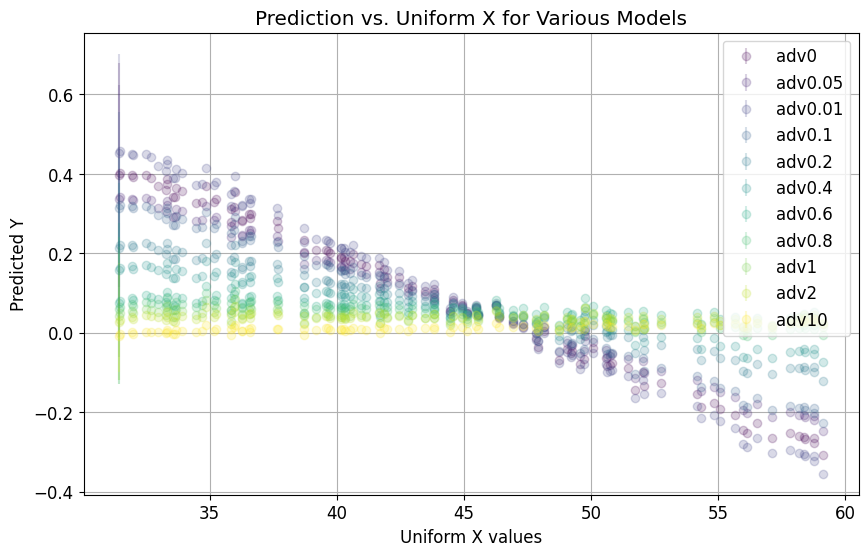

In [ ]:
# Plot setup
plt.figure(figsize=(10, 6))
# plt.ylim(-0.8, 1.4)

# Plot error bars
for i in range(len(lambda_unique)):
    lamb = lambda_unique[i]
    print(lamb)
    predY_a_prime = np.array(predY_a_prime_dict[lamb])
    for x in unique_X:
        mask = Unif_X_np == x

        mask = np.tile(mask, (num_exps, 1))
        # mean_predY[x].append(np.mean(predY_a_prime[mask.reshape(-1)]))
        # std_predY[x].append(np.std(predY_a_prime[mask.reshape(-1)]))

        print('--')
        print(np.mean(predY_a_prime[mask.reshape(-1)]))
        print(np.std(predY_a_prime[mask.reshape(-1)]))

    # for x in unique_X:
        print(len(mask.reshape(-1)))

        mean_value = np.mean(predY_a_prime[mask.reshape(-1)])
        std_value = np.std(predY_a_prime[mask.reshape(-1)])

        if x == np.min(unique_X):
            plt.errorbar(x, mean_value, yerr=std_value, fmt='o', label = 'adv' + str(lamb), color=colors[i], alpha=0.2)
        else:
            # plt.errorbar(x, mean_value, yerr=std_value, fmt='o', color=colors[i], alpha=0.2)
            plt.errorbar(x, mean_value, yerr=0, fmt='o', color=colors[i], alpha=0.2)


plt.title('Prediction vs. Uniform X for Various Models')
plt.xlabel('Uniform X values')
plt.ylabel('Predicted Y')
plt.legend()
plt.grid(True)
plt.show()

## OB predictor training

In [ ]:
ob_results = {}

In [ ]:
# X_HAT_x_prime[:len(recon_X_aprime)].shape

In [ ]:
# len(recon_X_aprime)

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(X_HAT.shape[1], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        return x

In [ ]:
# OB method
for i in range(num_exps):
    set_seeds(seed=i)
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset

    start = time.time()

    X_combined = np.vstack([X_train, X_test])
    Z_combined = np.vstack([Z_train.values.reshape(-1, 1), Z_test.values.reshape(-1, 1)])
    # X_train, y_train, Z_train
    from sklearn.linear_model import LinearRegression
    S, U = OG(X_combined, Z_combined, K=4, rescale=False)
    # S, U = SOG(X_combined, Z_combined, K=4, rescale=False)
    X_HAT = np.matmul(S, U)
    # X_HAT = X_combined
    # print(S,U)
    # print('finish SOG' if (algorithm == 'SOG' or algorithm == 'sog') else 'finish OG')
    # correlation(X_HAT, z, algorithm, "X_HAT", "Z")
    # frobenius_distance = frobenius(X_HAT.values, X.values)
    frobenius_distance = frobenius(X_combined, X_HAT)
    print('Frobenius distance/num of element of {}: {}'.format('OG', frobenius_distance))


    # Convert X_HAT and y_train to PyTorch tensors
    X = torch.tensor(X_HAT[:-len(X_test)].values, dtype=torch.float32)
    y = torch.tensor(y_train.values, dtype=torch.float32)

    # Create a dataset and data loader for mini-batch processing
    dataset = TensorDataset(X, y)
    # batch_size = 64  # You can adjust the batch size
    batch_size = 256
    num_epochs= 2
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    lr=0.0001
    # Instantiate the model
    model = NN()
    model.train()  # Set the model to training mode

    # Define the loss function and optimizer
    criterion = nn.MSELoss()  # Assuming a regression task
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    # num_epochs = 500  # Number of epochs to train
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, targets in dataloader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))  # Ensure correct shape

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        if epoch % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}')

    # Set the model to evaluation mode for predictions
    model.eval()



    # senstest=torch.tensor(np.expand_dims(Z_test,axis = 1)).float().to(device)
    # datatest=torch.tensor(X_test.values).float().to(device)
    ydatatest= Variable(torch.FloatTensor(np.expand_dims(y_train,axis = 1))).to(device)

    y_hat = model(torch.tensor(X_HAT[:-len(X_test)].values, dtype=torch.float32))
    tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()

    # Yhat_test=CF_PREDICTOR_S0.predict(datatest,senstest)
    MSE_Train = F.mse_loss(tensor_from_numpy.to(device),ydatatest.to(device))
    print("Train MSE:",MSE_Train.cpu().detach().numpy())
    RMSE_Train = torch.sqrt(MSE_Train)
    print("Train RMSE:",RMSE_Train.cpu().detach().numpy())

    # Calculate the relative mean squared error as a percentage of the mean of y_train
    mean_y_train = y_train.mean()
    relative_MSE_Train = (RMSE_Train / mean_y_train)
    relative_MSE_percent_train = relative_MSE_Train.cpu().detach().numpy()
    print('Relative MSE Percentage (Test): {:.2f}%'.format(relative_MSE_percent_train))

    ydatatest= Variable(torch.FloatTensor(np.expand_dims(y_test,axis = 1))).to(device)

    y_hat = model(torch.tensor(X_HAT[-len(X_test):].values, dtype=torch.float32))
    tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()

    # Yhat_test=CF_PREDICTOR_S0.predict(datatest,senstest)
    MSE_Test = F.mse_loss(tensor_from_numpy.to(device),ydatatest.to(device))
    print("Test MSE:",MSE_Test.cpu().detach().numpy())
    RMSE_Test = torch.sqrt(MSE_Test)
    MSE_Test =MSE_Test.cpu().detach().numpy()
    print("Test RMSE:",RMSE_Train.cpu().detach().numpy())
    RMSE_Train = RMSE_Train.cpu().detach().numpy()

    # Calculate MAPE
    mape = torch.mean(torch.abs((ydatatest - tensor_from_numpy) / ydatatest))
    print("Test MAPE:", mape.cpu().detach().numpy() * 100, "%")

    # Calculate the relative mean squared error as a percentage of the mean of y_train
    mean_y_test = y_test.mean()
    relative_MSE_Test = (RMSE_Test / mean_y_test)
    relative_MSE_percent_test = relative_MSE_Test.cpu().detach().numpy()
    print('Relative MSE Percentage (Test): {:.2f}%'.format(relative_MSE_percent_test))

    print('X_train',X_train.shape)
    X_combined = np.vstack([X_train, recon_X_aprime.detach().numpy()])
    print('X_combined', X_combined.shape)
    Z_combined = np.vstack([Z_train.values.reshape(-1,1), Unif_X.detach().numpy()])
    S, U = OG(X_combined, Z_combined, K=4, rescale=False)
    X_HAT_x_prime = np.matmul(S, U)

    y_hat = model(torch.tensor(X_HAT_x_prime[-len(recon_X_aprime):].values, dtype=torch.float32))
    print('y_hat', y_hat.shape)
    predY_a_prime = torch.tensor(y_hat.reshape(-1, 1)).float()

    print('predY_a_prime', predY_a_prime.shape)

    X_combined = np.vstack([X_train, recon_X_a.detach().numpy()])
    Z_combined = np.vstack([Z_train.values.reshape(-1,1), Z_test_X.unsqueeze(1).detach().numpy()])
    S, U = OG(X_combined, Z_combined, K=4, rescale=False)
    X_HAT_x = np.matmul(S, U)

    y_hat = model(torch.tensor(X_HAT_x[-len(recon_X_a):].values, dtype=torch.float32))
    predY_a = torch.tensor(y_hat.reshape(-1, 1)).float()

    cf = torch.mean((predY_a_prime - predY_a)**2).item()  # Compute MSE using PyTorch and convert to Python float

    # Print the formatted CF Value
    print('CF test Value: {:9f}'.format(cf))


    print('X_train',X_train.shape)
    X_combined = np.vstack([X_train, recon_X_aprime_train.detach().numpy()])
    print('X_combined', X_combined.shape)
    Z_combined = np.vstack([Z_train.values.reshape(-1,1), Unif_X_train.detach().numpy()])
    S, U = OG(X_combined, Z_combined, K=4, rescale=False)
    X_HAT_x_prime = np.matmul(S, U)

    y_hat_train = model(torch.tensor(X_HAT_x_prime[-len(recon_X_aprime):].values, dtype=torch.float32))
    print('y_hat', y_hat_train.shape)
    predY_a_prime_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()

    print('predY_a_prime', predY_a_prime.shape)

    X_combined = np.vstack([X_train, recon_X_a_train.detach().numpy()])
    Z_combined = np.vstack([Z_train.values.reshape(-1,1), Z_train_X.unsqueeze(1).detach().numpy()])
    S, U = OG(X_combined, Z_combined, K=4, rescale=False)
    X_HAT_x = np.matmul(S, U)

    y_hat_train = model(torch.tensor(X_HAT_x[-len(recon_X_a):].values, dtype=torch.float32))
    predY_a_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()

    cf_train = torch.mean((predY_a_prime_train - predY_a_train)**2).item()  # Compute MSE using PyTorch and convert to Python float

    # Print the formatted CF Value
    print('CF train Value: {:9f}'.format(cf_train))


    print("time taken", length)
    end = time.time()
    length = end - start

    ob_results[(i)] = {
        'train_mse': MSE_Train,
        'test_mse': MSE_Test,
        'mape':mape,
        'relative_train_mse': relative_MSE_percent_train,
        'relative_test_mse': relative_MSE_percent_test,
        'cf': cf,
        'cf_train': cf_train,
        'time_taken': length
    }
    # predY_a_prime_dict['OB'] = predY_a_prime

    if 'OB' in predY_a_prime_dict:
        predY_a_prime_dict['OB'] += predY_a_prime.flatten().tolist()
    else:
        predY_a_prime_dict['OB']=predY_a_prime.flatten().tolist()



z (1000, 1)
u (1000, 4)
d_d (4, 4)
Frobenius distance/num of element of OG: 0.00788963262661065
Epoch [1/2], Loss: 0.9245
Train MSE: 0.986062
Train RMSE: 0.9930065
Relative MSE Percentage (Test): 1228599956865024.00%
Test MSE: 1.0070723
Test RMSE: 0.9930065
Test MAPE: 99.6816635131836 %
Relative MSE Percentage (Test): 7.65%
X_train (800, 4)
X_combined (20800, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/2398022364.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/2398022364.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()


z (20800, 1)
u (20800, 4)
d_d (4, 4)
y_hat torch.Size([20000, 1])
predY_a_prime torch.Size([20000, 1])


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/2398022364.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime = torch.tensor(y_hat.reshape(-1, 1)).float()


z (20800, 1)
u (20800, 4)
d_d (4, 4)
CF test Value:  0.000014
X_train (800, 4)
X_combined (8800, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/2398022364.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a = torch.tensor(y_hat.reshape(-1, 1)).float()


z (8800, 1)
u (8800, 4)
d_d (4, 4)
y_hat torch.Size([8800, 1])
predY_a_prime torch.Size([20000, 1])


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/2398022364.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()


z (8800, 1)
u (8800, 4)
d_d (4, 4)
CF train Value:  0.000013
time taken 0.16311097145080566
z (1000, 1)
u (1000, 4)
d_d (4, 4)
Frobenius distance/num of element of OG: 0.00788963262661065
Epoch [1/2], Loss: 1.0172
Train MSE: 1.0223744
Train RMSE: 1.0111253
Relative MSE Percentage (Test): 1251017404448768.00%
Test MSE: 1.0954578
Test RMSE: 1.0111253
Test MAPE: 141.99539422988892 %
Relative MSE Percentage (Test): 7.98%
X_train (800, 4)
X_combined (20800, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/2398022364.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/2398022364.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/2398022364.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.te

z (20800, 1)
u (20800, 4)
d_d (4, 4)
y_hat torch.Size([20000, 1])
predY_a_prime torch.Size([20000, 1])


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/2398022364.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime = torch.tensor(y_hat.reshape(-1, 1)).float()


KeyboardInterrupt: 

In [ ]:
recon_X_aprime.shape

torch.Size([20000, 4])

In [ ]:
print(predY_a_prime.shape)

torch.Size([20000, 1])


In [ ]:
recon_X_aprime.shape

torch.Size([20000, 4])

In [ ]:
ob_results

{0: {'train_mse': tensor(0.0045),
  'test_mse': array(0.00537867, dtype=float32),
  'mape': tensor(0.3106),
  'relative_train_mse': array(8.287724e+13, dtype=float32),
  'relative_test_mse': array(0.55907536, dtype=float32),
  'cf': 0.13756561279296875,
  'cf_train': 0.1282360702753067},
 1: {'train_mse': tensor(0.0044),
  'test_mse': array(0.00523424, dtype=float32),
  'mape': tensor(0.3382),
  'relative_train_mse': array(8.193985e+13, dtype=float32),
  'relative_test_mse': array(0.55151796, dtype=float32),
  'cf': 0.13658004999160767,
  'cf_train': 0.12730886042118073},
 2: {'train_mse': tensor(0.0045),
  'test_mse': array(0.00532157, dtype=float32),
  'mape': tensor(0.3230),
  'relative_train_mse': array(8.2711515e+13, dtype=float32),
  'relative_test_mse': array(0.5561001, dtype=float32),
  'cf': 0.1408170908689499,
  'cf_train': 0.13125193119049072},
 3: {'train_mse': tensor(0.0044),
  'test_mse': array(0.00546402, dtype=float32),
  'mape': tensor(0.3274),
  'relative_train_mse': 

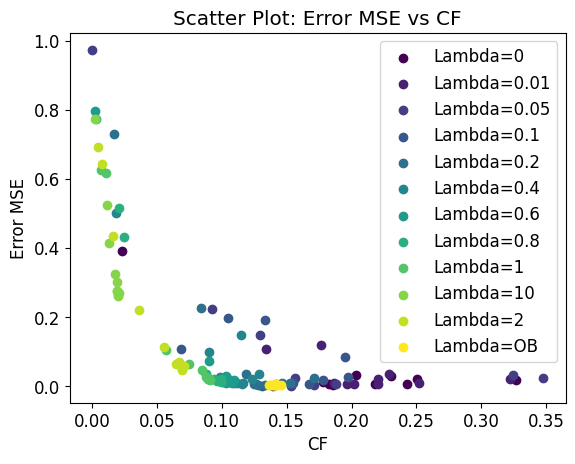

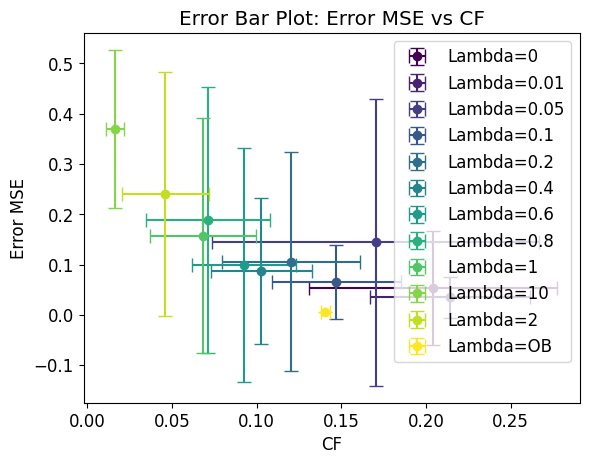

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data provided, updated with new lambda 0.8 data point
# Initialize lists to store the data
lambda_or_ob = []
mse = []
cf = []

# Iterate over the OB results and add them to the lists
for i in ob_results:
    lambda_or_ob.append('OB')  # Mark this data point as 'OB'
    mse.append(ob_results[i]['test_mse'])
    cf.append(ob_results[i]['cf'])

# Iterate over the adversarial results and add them to the lists
for (i, lambdap) in adv_results:
    lambda_or_ob.append(lambdap)  # Use the lambda value for this data point
    mse.append(adv_results[(i, lambdap)]['test_mse'])
    cf.append(adv_results[(i, lambdap)]['cf'])

# Now create the dictionary for plotting
data = {
    'lambda': np.array(lambda_or_ob),
    'MSE': np.array(mse),
    'CF': np.array(cf)
}

# data = {
#     'lambda': np.array([0.8, 0.8, 0.1, 0.1, 0.05, 0.05, 0.05, 0, 0, 0, 0.8, 0.2, 0.3]),
#     'MSE': np.array([0.46403912, 0.595219, 0.498225, 0.50458, 0.458623, 0.479910, 0.515498, 0.5262419, 0.4848239, 0.477124, 0.79485, 0.59179, 0.45065]),
#     'CF': np.array([0.040312, 0.030766, 0.08441, 0.11759, 0.08023, 0.04325, 0.11955, 0.079952, 0.121684, 0.057369, 0.01218, 0.09550, 0.05920])
# }

# Unique lambda values and their colors
lambda_unique = np.unique(data['lambda'])
colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_unique)))

# Plot 1: Scatter plot only
fig1, ax1 = plt.subplots()
for i, lamb in enumerate(lambda_unique):
    indices = data['lambda'] == lamb
    ax1.scatter(data['CF'][indices], data['MSE'][indices], color=colors[i], label=f'Lambda={lamb}')
ax1.set_xlabel('CF')
ax1.set_ylabel('Error MSE')
ax1.set_title('Scatter Plot: Error MSE vs CF')
ax1.legend()

# Plot 2: Error bar plot with center marker
fig2, ax2 = plt.subplots()
for i, lamb in enumerate(lambda_unique):
    indices = data['lambda'] == lamb
    mean_MSE = np.mean(data['MSE'][indices])
    std_MSE = np.std(data['MSE'][indices])
    mean_CF = np.mean(data['CF'][indices])
    std_CF = np.std(data['CF'][indices])

    # Error bar for mean and standard deviation
    ax2.errorbar(mean_CF, mean_MSE, xerr=std_CF, yerr=std_MSE, fmt='o', color=colors[i], capsize=5, label=f'Lambda={lamb}')
ax2.set_xlabel('CF')
ax2.set_ylabel('Error MSE')
ax2.set_title('Error Bar Plot: Error MSE vs CF')
ax2.legend()

plt.show()


## SOB

In [ ]:
sob_results = {}

In [ ]:
# OB method
for i in range(num_exps):
    set_seeds(seed=i)
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset

    X_combined = np.vstack([X_train, X_test])
    Z_combined = np.vstack([Z_train.values.reshape(-1, 1), Z_test.values.reshape(-1, 1)])
    # X_train, y_train, Z_train
    from sklearn.linear_model import LinearRegression
    # S, U = OG(X_combined, Z_combined, K=4, rescale=False)
    S, U = SOG(X_combined, Z_combined, K=4, rescale=False)
    X_HAT = np.matmul(S, U)
    # X_HAT = X_combined
    # print(S,U)
    # print('finish SOG' if (algorithm == 'SOG' or algorithm == 'sog') else 'finish OG')
    # correlation(X_HAT, z, algorithm, "X_HAT", "Z")
    # frobenius_distance = frobenius(X_HAT.values, X.values)
    frobenius_distance = frobenius(X_combined, X_HAT)
    print('Frobenius distance/num of element of {}: {}'.format('OG', frobenius_distance))

    class NN(nn.Module):
        def __init__(self):
            super(NN, self).__init__()
            self.fc1 = nn.Linear(X_HAT.shape[1], 64)
            self.fc2 = nn.Linear(64, 64)
            self.fc3 = nn.Linear(64, 16)
            self.fc4 = nn.Linear(16, 1)
        def forward(self, x):
            x = self.fc1(x)
            x = torch.relu(x)
            x = self.fc2(x)
            x = torch.relu(x)
            x = self.fc3(x)
            x = torch.relu(x)
            x = self.fc4(x)
            return x

    # Convert X_HAT and y_train to PyTorch tensors
    X = torch.tensor(X_HAT[:-len(X_test)].values, dtype=torch.float32)
    y = torch.tensor(y_train.values, dtype=torch.float32)

    # Create a dataset and data loader for mini-batch processing
    dataset = TensorDataset(X, y)
    # batch_size = 64  # You can adjust the batch size
    batch_size = 256
    num_epochs= 2000
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    lr=0.0001
    # Instantiate the model
    model = NN()
    model.train()  # Set the model to training mode

    # Define the loss function and optimizer
    criterion = nn.MSELoss()  # Assuming a regression task
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    # num_epochs = 500  # Number of epochs to train
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, targets in dataloader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))  # Ensure correct shape

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        if epoch % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}')

    # Set the model to evaluation mode for predictions
    model.eval()

    # senstest=torch.tensor(np.expand_dims(Z_test,axis = 1)).float().to(device)
    # datatest=torch.tensor(X_test.values).float().to(device)
    ydatatest= Variable(torch.FloatTensor(np.expand_dims(y_train,axis = 1))).to(device)

    y_hat = model(torch.tensor(X_HAT[:-len(X_test)].values, dtype=torch.float32))
    tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()

    # Yhat_test=CF_PREDICTOR_S0.predict(datatest,senstest)
    MSE_Train = F.mse_loss(tensor_from_numpy.to(device),ydatatest.to(device))
    print("Train MSE:",MSE_Train.cpu().detach().numpy())
    RMSE_Train = torch.sqrt(MSE_Train)
    print("Train RMSE:",RMSE_Train.cpu().detach().numpy())

    # Calculate the relative mean squared error as a percentage of the mean of y_train
    mean_y_train = y_train.mean()
    relative_MSE_Train = (RMSE_Train / mean_y_train)
    relative_MSE_percent_train = relative_MSE_Train.cpu().detach().numpy()
    print('Relative MSE Percentage (Test): {:.2f}%'.format(relative_MSE_percent_train))

    ydatatest= Variable(torch.FloatTensor(np.expand_dims(y_test,axis = 1))).to(device)

    y_hat = model(torch.tensor(X_HAT[-len(X_test):].values, dtype=torch.float32))
    tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()

    # Yhat_test=CF_PREDICTOR_S0.predict(datatest,senstest)
    MSE_Test = F.mse_loss(tensor_from_numpy.to(device),ydatatest.to(device))
    print("Test MSE:",MSE_Test.cpu().detach().numpy())
    RMSE_Test = torch.sqrt(MSE_Test)
    MSE_Test =MSE_Test.cpu().detach().numpy()
    print("Test RMSE:",RMSE_Test.cpu().detach().numpy())
    RMSE_Test = RMSE_Test.cpu().detach().numpy()

    # Calculate MAPE
    mape = torch.mean(torch.abs((ydatatest - tensor_from_numpy) / ydatatest))
    print("Test MAPE:", mape.cpu().detach().numpy() * 100, "%")

    # Calculate the relative mean squared error as a percentage of the mean of y_train
    mean_y_test = y_test.mean()
    relative_MSE_Test = (RMSE_Test / mean_y_test)
    relative_MSE_percent_test = relative_MSE_Test
    print('Relative MSE Percentage (Test): {:.2f}%'.format(relative_MSE_percent_test))

    X_combined = np.vstack([X_train, recon_X_aprime.detach().numpy()])
    Z_combined = np.vstack([Z_train.values.reshape(-1,1), Unif_X.detach().numpy()])
    S, U = OG(X_combined, Z_combined, K=4, rescale=False)
    X_HAT_x_prime = np.matmul(S, U)

    y_hat = model(torch.tensor(X_HAT_x_prime[-len(recon_X_aprime):].values, dtype=torch.float32))
    predY_a_prime = torch.tensor(y_hat.reshape(-1, 1)).float()


    X_combined = np.vstack([X_train, recon_X_a.detach().numpy()])
    Z_combined = np.vstack([Z_train.values.reshape(-1,1), Z_test_X.unsqueeze(1).detach().numpy()])
    S, U = OG(X_combined, Z_combined, K=4, rescale=False)
    X_HAT_x = np.matmul(S, U)

    y_hat = model(torch.tensor(X_HAT_x[-len(recon_X_a):].values, dtype=torch.float32))
    predY_a = torch.tensor(y_hat.reshape(-1, 1)).float()

    cf = torch.mean((predY_a_prime - predY_a)**2).item()  # Compute MSE using PyTorch and convert to Python float

    # Print the formatted CF Value
    # Print the formatted CF Value
    print('CF test Value: {:9f}'.format(cf))


    print('X_train',X_train.shape)
    X_combined = np.vstack([X_train, recon_X_aprime_train.detach().numpy()])
    print('X_combined', X_combined.shape)
    Z_combined = np.vstack([Z_train.values.reshape(-1,1), Unif_X_train.detach().numpy()])
    S, U = OG(X_combined, Z_combined, K=4, rescale=False)
    X_HAT_x_prime = np.matmul(S, U)

    y_hat_train = model(torch.tensor(X_HAT_x_prime[-len(recon_X_aprime):].values, dtype=torch.float32))
    print('y_hat', y_hat_train.shape)
    predY_a_prime_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()

    print('predY_a_prime', predY_a_prime.shape)

    X_combined = np.vstack([X_train, recon_X_a_train.detach().numpy()])
    Z_combined = np.vstack([Z_train.values.reshape(-1,1), Z_train_X.unsqueeze(1).detach().numpy()])
    S, U = OG(X_combined, Z_combined, K=4, rescale=False)
    X_HAT_x = np.matmul(S, U)

    y_hat_train = model(torch.tensor(X_HAT_x[-len(recon_X_a):].values, dtype=torch.float32))
    predY_a_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()

    cf_train = torch.mean((predY_a_prime_train - predY_a_train)**2).item()  # Compute MSE using PyTorch and convert to Python float

    # Print the formatted CF Value
    print('CF train Value: {:9f}'.format(cf_train))
    print("time taken", length)
    end = time.time()
    length = end - start

    sob_results[(i)] = {
        'train_mse': MSE_Train,
        'test_mse': MSE_Test,
        'mape':mape,
        'relative_train_mse': relative_MSE_percent_train,
        'relative_test_mse': relative_MSE_percent_test,
        'cf': cf,
        'cf_train': cf_train,
        'time_taken': length
    }

    if 'SOB' in predY_a_prime_dict:
        predY_a_prime_dict['SOB'] += predY_a_prime.flatten().tolist()
    else:
        predY_a_prime_dict['SOB']=predY_a_prime.flatten().tolist()


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:15: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  X_HAT = np.matmul(S, U)


Frobenius distance/num of element of OG: 0.007889926590343876
Epoch [1/2000], Loss: 0.9245
Epoch [101/2000], Loss: 0.4063
Epoch [201/2000], Loss: 0.0127
Epoch [301/2000], Loss: 0.0062
Epoch [401/2000], Loss: 0.0048
Epoch [501/2000], Loss: 0.0050
Epoch [601/2000], Loss: 0.0048
Epoch [701/2000], Loss: 0.0053
Epoch [801/2000], Loss: 0.0051
Epoch [901/2000], Loss: 0.0048
Epoch [1001/2000], Loss: 0.0047
Epoch [1101/2000], Loss: 0.0044
Epoch [1201/2000], Loss: 0.0049
Epoch [1301/2000], Loss: 0.0044
Epoch [1401/2000], Loss: 0.0046
Epoch [1501/2000], Loss: 0.0044
Epoch [1601/2000], Loss: 0.0054
Epoch [1701/2000], Loss: 0.0042
Epoch [1801/2000], Loss: 0.0051
Epoch [1901/2000], Loss: 0.0045


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()


Train MSE: 0.0044715684
Train RMSE: 0.06686979
Relative MSE Percentage (Test): 82734819049472.00%
Test MSE: 0.005335717
Test RMSE: 0.07304599
Test MAPE: 31.653204560279846 %
Relative MSE Percentage (Test): 0.56%
z (20800, 1)
u (20800, 4)
d_d (4, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime = torch.tensor(y_hat.reshape(-1, 1)).float()


z (20800, 1)
u (20800, 4)
d_d (4, 4)
CF test Value:  0.138366
X_train (800, 4)
X_combined (8800, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a = torch.tensor(y_hat.reshape(-1, 1)).float()


z (8800, 1)
u (8800, 4)
d_d (4, 4)
y_hat torch.Size([8800, 1])
predY_a_prime torch.Size([20000, 1])


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()


z (8800, 1)
u (8800, 4)
d_d (4, 4)
CF train Value:  0.129304


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:15: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  X_HAT = np.matmul(S, U)


Frobenius distance/num of element of OG: 0.007889926888599921
Epoch [1/2000], Loss: 1.0173
Epoch [101/2000], Loss: 0.5868
Epoch [201/2000], Loss: 0.0361
Epoch [301/2000], Loss: 0.0128
Epoch [401/2000], Loss: 0.0070
Epoch [501/2000], Loss: 0.0054
Epoch [601/2000], Loss: 0.0053
Epoch [701/2000], Loss: 0.0050
Epoch [801/2000], Loss: 0.0047
Epoch [901/2000], Loss: 0.0047
Epoch [1001/2000], Loss: 0.0045
Epoch [1101/2000], Loss: 0.0047
Epoch [1201/2000], Loss: 0.0051
Epoch [1301/2000], Loss: 0.0043
Epoch [1401/2000], Loss: 0.0044
Epoch [1501/2000], Loss: 0.0044
Epoch [1601/2000], Loss: 0.0042
Epoch [1701/2000], Loss: 0.0044
Epoch [1801/2000], Loss: 0.0050
Epoch [1901/2000], Loss: 0.0044


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()


Train MSE: 0.004399414
Train RMSE: 0.06632808
Relative MSE Percentage (Test): 82064586047488.00%
Test MSE: 0.00524301
Test RMSE: 0.07240863
Test MAPE: 33.685603737831116 %
Relative MSE Percentage (Test): 0.55%
z (20800, 1)
u (20800, 4)
d_d (4, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime = torch.tensor(y_hat.reshape(-1, 1)).float()


z (20800, 1)
u (20800, 4)
d_d (4, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a = torch.tensor(y_hat.reshape(-1, 1)).float()


CF test Value:  0.134477
X_train (800, 4)
X_combined (8800, 4)
z (8800, 1)
u (8800, 4)
d_d (4, 4)
y_hat torch.Size([8800, 1])
predY_a_prime torch.Size([20000, 1])


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()


z (8800, 1)
u (8800, 4)
d_d (4, 4)
CF train Value:  0.125650


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:15: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  X_HAT = np.matmul(S, U)


Frobenius distance/num of element of OG: 0.007889926870322988
Epoch [1/2000], Loss: 1.1125
Epoch [101/2000], Loss: 0.3895
Epoch [201/2000], Loss: 0.0123
Epoch [301/2000], Loss: 0.0078
Epoch [401/2000], Loss: 0.0067
Epoch [501/2000], Loss: 0.0053
Epoch [601/2000], Loss: 0.0055
Epoch [701/2000], Loss: 0.0054
Epoch [801/2000], Loss: 0.0050
Epoch [901/2000], Loss: 0.0055
Epoch [1001/2000], Loss: 0.0047
Epoch [1101/2000], Loss: 0.0049
Epoch [1201/2000], Loss: 0.0044
Epoch [1301/2000], Loss: 0.0043
Epoch [1401/2000], Loss: 0.0041
Epoch [1501/2000], Loss: 0.0043
Epoch [1601/2000], Loss: 0.0047
Epoch [1701/2000], Loss: 0.0042
Epoch [1801/2000], Loss: 0.0045
Epoch [1901/2000], Loss: 0.0043


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()


Train MSE: 0.00446028
Train RMSE: 0.06678533
Relative MSE Percentage (Test): 82630322159616.00%
Test MSE: 0.0051079122
Test RMSE: 0.07146966
Test MAPE: 32.69699811935425 %
Relative MSE Percentage (Test): 0.54%
z (20800, 1)
u (20800, 4)
d_d (4, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime = torch.tensor(y_hat.reshape(-1, 1)).float()


z (20800, 1)
u (20800, 4)
d_d (4, 4)
CF test Value:  0.139846
X_train (800, 4)
X_combined (8800, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a = torch.tensor(y_hat.reshape(-1, 1)).float()


z (8800, 1)
u (8800, 4)
d_d (4, 4)
y_hat torch.Size([8800, 1])
predY_a_prime torch.Size([20000, 1])


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()


z (8800, 1)
u (8800, 4)
d_d (4, 4)
CF train Value:  0.130669


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:15: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  X_HAT = np.matmul(S, U)


Frobenius distance/num of element of OG: 0.007889926879781637
Epoch [1/2000], Loss: 1.0072
Epoch [101/2000], Loss: 0.5959
Epoch [201/2000], Loss: 0.0302
Epoch [301/2000], Loss: 0.0084
Epoch [401/2000], Loss: 0.0060
Epoch [501/2000], Loss: 0.0062
Epoch [601/2000], Loss: 0.0048
Epoch [701/2000], Loss: 0.0052
Epoch [801/2000], Loss: 0.0046
Epoch [901/2000], Loss: 0.0047
Epoch [1001/2000], Loss: 0.0049
Epoch [1101/2000], Loss: 0.0051
Epoch [1201/2000], Loss: 0.0045
Epoch [1301/2000], Loss: 0.0049
Epoch [1401/2000], Loss: 0.0051
Epoch [1501/2000], Loss: 0.0045
Epoch [1601/2000], Loss: 0.0048
Epoch [1701/2000], Loss: 0.0041
Epoch [1801/2000], Loss: 0.0048
Epoch [1901/2000], Loss: 0.0046


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()


Train MSE: 0.0044084354
Train RMSE: 0.06639605
Relative MSE Percentage (Test): 82148690231296.00%
Test MSE: 0.005470857
Test RMSE: 0.073965244
Test MAPE: 32.8840970993042 %
Relative MSE Percentage (Test): 0.56%
z (20800, 1)
u (20800, 4)
d_d (4, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime = torch.tensor(y_hat.reshape(-1, 1)).float()


z (20800, 1)
u (20800, 4)
d_d (4, 4)
CF test Value:  0.139244
X_train (800, 4)
X_combined (8800, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a = torch.tensor(y_hat.reshape(-1, 1)).float()


z (8800, 1)
u (8800, 4)
d_d (4, 4)
y_hat torch.Size([8800, 1])
predY_a_prime torch.Size([20000, 1])


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()


z (8800, 1)
u (8800, 4)
d_d (4, 4)
CF train Value:  0.129736


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:15: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  X_HAT = np.matmul(S, U)


Frobenius distance/num of element of OG: 0.007889926559658948
Epoch [1/2000], Loss: 1.0553
Epoch [101/2000], Loss: 0.4575
Epoch [201/2000], Loss: 0.0142
Epoch [301/2000], Loss: 0.0072
Epoch [401/2000], Loss: 0.0060
Epoch [501/2000], Loss: 0.0058
Epoch [601/2000], Loss: 0.0056
Epoch [701/2000], Loss: 0.0051
Epoch [801/2000], Loss: 0.0048
Epoch [901/2000], Loss: 0.0046
Epoch [1001/2000], Loss: 0.0049
Epoch [1101/2000], Loss: 0.0054
Epoch [1201/2000], Loss: 0.0044
Epoch [1301/2000], Loss: 0.0043
Epoch [1401/2000], Loss: 0.0045
Epoch [1501/2000], Loss: 0.0048
Epoch [1601/2000], Loss: 0.0044
Epoch [1701/2000], Loss: 0.0049
Epoch [1801/2000], Loss: 0.0043
Epoch [1901/2000], Loss: 0.0041


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()


Train MSE: 0.0045861807
Train RMSE: 0.067721345
Relative MSE Percentage (Test): 83788411437056.00%
Test MSE: 0.005391079
Test RMSE: 0.07342397
Test MAPE: 32.828688621520996 %
Relative MSE Percentage (Test): 0.56%
z (20800, 1)
u (20800, 4)
d_d (4, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime = torch.tensor(y_hat.reshape(-1, 1)).float()


z (20800, 1)
u (20800, 4)
d_d (4, 4)
CF test Value:  0.138387
X_train (800, 4)
X_combined (8800, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a = torch.tensor(y_hat.reshape(-1, 1)).float()


z (8800, 1)
u (8800, 4)
d_d (4, 4)
y_hat torch.Size([8800, 1])
predY_a_prime torch.Size([20000, 1])


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()


z (8800, 1)
u (8800, 4)
d_d (4, 4)
CF train Value:  0.129251


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:15: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  X_HAT = np.matmul(S, U)


Frobenius distance/num of element of OG: 0.007889926870240123
Epoch [1/2000], Loss: 1.0409
Epoch [101/2000], Loss: 0.4803
Epoch [201/2000], Loss: 0.0146
Epoch [301/2000], Loss: 0.0086
Epoch [401/2000], Loss: 0.0056
Epoch [501/2000], Loss: 0.0056
Epoch [601/2000], Loss: 0.0048
Epoch [701/2000], Loss: 0.0047
Epoch [801/2000], Loss: 0.0052
Epoch [901/2000], Loss: 0.0048
Epoch [1001/2000], Loss: 0.0045
Epoch [1101/2000], Loss: 0.0046
Epoch [1201/2000], Loss: 0.0049
Epoch [1301/2000], Loss: 0.0047
Epoch [1401/2000], Loss: 0.0043
Epoch [1501/2000], Loss: 0.0048
Epoch [1601/2000], Loss: 0.0046
Epoch [1701/2000], Loss: 0.0044
Epoch [1801/2000], Loss: 0.0043
Epoch [1901/2000], Loss: 0.0042


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()


Train MSE: 0.0043507647
Train RMSE: 0.065960325
Relative MSE Percentage (Test): 81609587949568.00%
Test MSE: 0.005554474
Test RMSE: 0.074528344
Test MAPE: 32.78254270553589 %
Relative MSE Percentage (Test): 0.57%
z (20800, 1)
u (20800, 4)
d_d (4, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime = torch.tensor(y_hat.reshape(-1, 1)).float()


z (20800, 1)
u (20800, 4)
d_d (4, 4)
CF test Value:  0.142276
X_train (800, 4)
X_combined (8800, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a = torch.tensor(y_hat.reshape(-1, 1)).float()


z (8800, 1)
u (8800, 4)
d_d (4, 4)
y_hat torch.Size([8800, 1])
predY_a_prime torch.Size([20000, 1])


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()


z (8800, 1)
u (8800, 4)
d_d (4, 4)
CF train Value:  0.132969


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:15: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  X_HAT = np.matmul(S, U)


Frobenius distance/num of element of OG: 0.007889926595550795
Epoch [1/2000], Loss: 1.0545
Epoch [101/2000], Loss: 0.5338
Epoch [201/2000], Loss: 0.0148
Epoch [301/2000], Loss: 0.0069
Epoch [401/2000], Loss: 0.0056
Epoch [501/2000], Loss: 0.0053
Epoch [601/2000], Loss: 0.0053
Epoch [701/2000], Loss: 0.0058
Epoch [801/2000], Loss: 0.0048
Epoch [901/2000], Loss: 0.0051
Epoch [1001/2000], Loss: 0.0049
Epoch [1101/2000], Loss: 0.0054
Epoch [1201/2000], Loss: 0.0049
Epoch [1301/2000], Loss: 0.0044
Epoch [1401/2000], Loss: 0.0050
Epoch [1501/2000], Loss: 0.0048
Epoch [1601/2000], Loss: 0.0049
Epoch [1701/2000], Loss: 0.0046
Epoch [1801/2000], Loss: 0.0051
Epoch [1901/2000], Loss: 0.0049


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()


Train MSE: 0.0046236967
Train RMSE: 0.06799777
Relative MSE Percentage (Test): 84130414985216.00%
Test MSE: 0.00509832
Test RMSE: 0.07140252
Test MAPE: 32.4968695640564 %
Relative MSE Percentage (Test): 0.54%
z (20800, 1)
u (20800, 4)
d_d (4, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime = torch.tensor(y_hat.reshape(-1, 1)).float()


z (20800, 1)
u (20800, 4)
d_d (4, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a = torch.tensor(y_hat.reshape(-1, 1)).float()


CF test Value:  0.136816
X_train (800, 4)
X_combined (8800, 4)
z (8800, 1)
u (8800, 4)
d_d (4, 4)
y_hat torch.Size([8800, 1])
predY_a_prime torch.Size([20000, 1])


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()


z (8800, 1)
u (8800, 4)
d_d (4, 4)
CF train Value:  0.127720


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:15: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  X_HAT = np.matmul(S, U)


Frobenius distance/num of element of OG: 0.007889926878103021
Epoch [1/2000], Loss: 1.0084
Epoch [101/2000], Loss: 0.5194
Epoch [201/2000], Loss: 0.0163
Epoch [301/2000], Loss: 0.0086
Epoch [401/2000], Loss: 0.0052
Epoch [501/2000], Loss: 0.0052
Epoch [601/2000], Loss: 0.0056
Epoch [701/2000], Loss: 0.0046
Epoch [801/2000], Loss: 0.0047
Epoch [901/2000], Loss: 0.0044
Epoch [1001/2000], Loss: 0.0048
Epoch [1101/2000], Loss: 0.0049
Epoch [1201/2000], Loss: 0.0043
Epoch [1301/2000], Loss: 0.0046
Epoch [1401/2000], Loss: 0.0045
Epoch [1501/2000], Loss: 0.0044
Epoch [1601/2000], Loss: 0.0050
Epoch [1701/2000], Loss: 0.0049
Epoch [1801/2000], Loss: 0.0049
Epoch [1901/2000], Loss: 0.0047


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()


Train MSE: 0.004435698
Train RMSE: 0.06660104
Relative MSE Percentage (Test): 82402311405568.00%
Test MSE: 0.005636105
Test RMSE: 0.075073995
Test MAPE: 33.6999773979187 %
Relative MSE Percentage (Test): 0.57%
z (20800, 1)
u (20800, 4)
d_d (4, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime = torch.tensor(y_hat.reshape(-1, 1)).float()


z (20800, 1)
u (20800, 4)
d_d (4, 4)
CF test Value:  0.140299
X_train (800, 4)
X_combined (8800, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a = torch.tensor(y_hat.reshape(-1, 1)).float()


z (8800, 1)
u (8800, 4)
d_d (4, 4)
y_hat torch.Size([8800, 1])
predY_a_prime torch.Size([20000, 1])


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()


z (8800, 1)
u (8800, 4)
d_d (4, 4)
CF train Value:  0.131046


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:15: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  X_HAT = np.matmul(S, U)


Frobenius distance/num of element of OG: 0.007889926580179117
Epoch [1/2000], Loss: 1.0728
Epoch [101/2000], Loss: 0.3992
Epoch [201/2000], Loss: 0.0119
Epoch [301/2000], Loss: 0.0065
Epoch [401/2000], Loss: 0.0056
Epoch [501/2000], Loss: 0.0054
Epoch [601/2000], Loss: 0.0051
Epoch [701/2000], Loss: 0.0046
Epoch [801/2000], Loss: 0.0052
Epoch [901/2000], Loss: 0.0051
Epoch [1001/2000], Loss: 0.0050
Epoch [1101/2000], Loss: 0.0049
Epoch [1201/2000], Loss: 0.0047
Epoch [1301/2000], Loss: 0.0043
Epoch [1401/2000], Loss: 0.0047
Epoch [1501/2000], Loss: 0.0048
Epoch [1601/2000], Loss: 0.0041
Epoch [1701/2000], Loss: 0.0043
Epoch [1801/2000], Loss: 0.0040
Epoch [1901/2000], Loss: 0.0046


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()


Train MSE: 0.0043456987
Train RMSE: 0.06592192
Relative MSE Percentage (Test): 81562066485248.00%
Test MSE: 0.0055154283
Test RMSE: 0.07426593
Test MAPE: 31.690171360969543 %
Relative MSE Percentage (Test): 0.57%
z (20800, 1)
u (20800, 4)
d_d (4, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime = torch.tensor(y_hat.reshape(-1, 1)).float()


z (20800, 1)
u (20800, 4)
d_d (4, 4)
CF test Value:  0.137486
X_train (800, 4)
X_combined (8800, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a = torch.tensor(y_hat.reshape(-1, 1)).float()


z (8800, 1)
u (8800, 4)
d_d (4, 4)
y_hat torch.Size([8800, 1])
predY_a_prime torch.Size([20000, 1])


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()


z (8800, 1)
u (8800, 4)
d_d (4, 4)
CF train Value:  0.128212


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:15: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  X_HAT = np.matmul(S, U)


Frobenius distance/num of element of OG: 0.007889926845197494
Epoch [1/2000], Loss: 0.9850
Epoch [101/2000], Loss: 0.6516
Epoch [201/2000], Loss: 0.0419
Epoch [301/2000], Loss: 0.0102
Epoch [401/2000], Loss: 0.0065
Epoch [501/2000], Loss: 0.0053
Epoch [601/2000], Loss: 0.0055
Epoch [701/2000], Loss: 0.0051
Epoch [801/2000], Loss: 0.0053
Epoch [901/2000], Loss: 0.0046
Epoch [1001/2000], Loss: 0.0055
Epoch [1101/2000], Loss: 0.0050
Epoch [1201/2000], Loss: 0.0047
Epoch [1301/2000], Loss: 0.0045
Epoch [1401/2000], Loss: 0.0044
Epoch [1501/2000], Loss: 0.0046
Epoch [1601/2000], Loss: 0.0053
Epoch [1701/2000], Loss: 0.0048
Epoch [1801/2000], Loss: 0.0046
Epoch [1901/2000], Loss: 0.0048


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()
/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_numpy = torch.tensor(y_hat.reshape(-1, 1)).float()


Train MSE: 0.0045266403
Train RMSE: 0.067280315
Relative MSE Percentage (Test): 83242749263872.00%
Test MSE: 0.0055489866
Test RMSE: 0.07449152
Test MAPE: 29.664769768714905 %
Relative MSE Percentage (Test): 0.57%
z (20800, 1)
u (20800, 4)
d_d (4, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime = torch.tensor(y_hat.reshape(-1, 1)).float()


z (20800, 1)
u (20800, 4)
d_d (4, 4)
CF test Value:  0.140607
X_train (800, 4)
X_combined (8800, 4)


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a = torch.tensor(y_hat.reshape(-1, 1)).float()


z (8800, 1)
u (8800, 4)
d_d (4, 4)
y_hat torch.Size([8800, 1])
predY_a_prime torch.Size([20000, 1])


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_prime_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()


z (8800, 1)
u (8800, 4)
d_d (4, 4)
CF train Value:  0.131218


/var/folders/13/tl9dsyws2q95n8z5qcc79p1w0000gn/T/ipykernel_33846/8126144.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predY_a_train = torch.tensor(y_hat_train.reshape(-1, 1)).float()


## ML training

In [ ]:
ml_results = {}
predY_a_prime_dict['ML'] = []

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define the neural network model
class NN(nn.Module):
    def __init__(self, input_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Prepare data
# Assuming X_train, y_train, Z_train, X_test, y_test, Z_test are numpy arrays
XZ_train = np.column_stack((X_train, Z_train))  # Concatenate X and Z for training
XZ_test = np.column_stack((X_test, Z_test))  # Concatenate X and Z for testing

XZ_train_tensor = torch.tensor(XZ_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
XZ_test_tensor = torch.tensor(XZ_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Combining X and Z if needed
# XZ_train_tensor = torch.hstack((X_train_tensor, Z_train.reshape(-1, 1)))

for i in range(num_exps):
    set_seeds(i)
    start = time.time()
    # Load data into DataLoader for mini-batch gradient descent
    train_data = TensorDataset(XZ_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=256, shuffle=True)

    # Initialize the model
    model = NN(XZ_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 2000
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Print loss every few epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(XZ_test_tensor)
        test_loss = criterion(predictions, y_test_tensor)
        MSE_Test = test_loss.item()
        RMSE_Test = torch.sqrt(test_loss).item()

        print(f'Test MSE: {MSE_Test}')
        print(f'Test RMSE: {RMSE_Test}')

        # Calculate relative MSE percentage to the mean of y_test
        mean_y_test = y_test.mean()
        relative_MSE_percent_test = RMSE_Test / mean_y_test
        # print("Relative MSE Percentage (Test):", relative_MSE_percent_test)
        print('Relative MSE Percentage (Test): {:.2f}%'.format(relative_MSE_percent_test * 100))

        # Calculate MAPE
        mape = torch.mean(torch.abs((y_test_tensor - predictions) / y_test_tensor))
        print(f"MAPE: {mape.item() * 100:.2f}%")
        mape = mape.item()

    # y_hat = model2.predict(recon_X_aprime.detach().numpy())
    # with torch.no_grad():
        predictions = model(torch.tensor(np.column_stack((recon_X_aprime.detach().numpy(), Unif_X))))
        # test_loss = criterion(predictions, y_test_tensor)
        # print(f'Test MSE: {test_loss.item()}')

        predY_a_prime = predictions.cpu().detach().numpy()

    # # y_hat = model2.predict(recon_X_aprime.detach().numpy())
    # with torch.no_grad():
        predictions = model(torch.tensor(np.column_stack((recon_X_a.detach().numpy(), Z_test_X))))
        # test_loss = criterion(predictions, y_test_tensor)
        # print(f'Test MSE: {test_loss.item()}')

        predY_a = predictions.cpu().detach().numpy()

    cf = np.mean((predY_a_prime-predY_a)**2)

    # Print the formatted CF Value
    print('CF test: {:9f}'.format(cf))

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        # predictions = model(XZ_train_tensor)
        # test_loss = criterion(predictions, y_train_tensor)
        # MSE_Test = test_loss.item()
        # RMSE_Test = torch.sqrt(test_loss).item()

        # print(f'Test MSE: {MSE_Test}')
        # print(f'Test RMSE: {RMSE_Test}')

        # # Calculate relative MSE percentage to the mean of y_test
        # mean_y_test = y_test.mean()
        # relative_MSE_percent_test = RMSE_Test / mean_y_test
        # # print("Relative MSE Percentage (Test):", relative_MSE_percent_test)
        # print('Relative MSE Percentage (Test): {:.2f}%'.format(relative_MSE_percent_test * 100))

        # # Calculate MAPE
        # mape = torch.mean(torch.abs((y_train_tensor - predictions) / y_train_tensor))
        # print(f"MAPE: {mape.item() * 100:.2f}%")
        # mape = mape.item()

    # y_hat = model2.predict(recon_X_aprime.detach().numpy())
    # with torch.no_grad():
        predictions = model(torch.tensor(np.column_stack((recon_X_aprime_train.detach().numpy(), Unif_X_train))))
        # test_loss = criterion(predictions, y_test_tensor)
        # print(f'Test MSE: {test_loss.item()}')

        predY_a_prime_train = predictions.cpu().detach().numpy()

    # # y_hat = model2.predict(recon_X_aprime.detach().numpy())
    # with torch.no_grad():
        predictions = model(torch.tensor(np.column_stack((recon_X_a_train.detach().numpy(), Z_train_X))))
        # test_loss = criterion(predictions, y_test_tensor)
        # print(f'Test MSE: {test_loss.item()}')

        predY_a_train = predictions.cpu().detach().numpy()

    cf_train = np.mean((predY_a_prime_train-predY_a_train)**2)

    # Print the formatted CF Value
    print('CF train: {:9f}'.format(cf_train))
    print("time taken", length)
    end = time.time()
    length = end - start


    ml_results[i] = {
        # 'train_mse': MSE_Train,
        'test_mse': MSE_Test,
        'mape': mape,
        'relative_test_mse': relative_MSE_percent_test,
        'cf': cf,
        'cf_train': cf_train,
        'time_taken': length
    }
    # predY_a_prime_dict['ML'] = predY_a_prime

    if 'ML' in predY_a_prime_dict:
        predY_a_prime_dict['ML'] += predY_a_prime.flatten().tolist()
    else:
        predY_a_prime_dict['ML']=predY_a_prime.flatten().tolist()


Epoch 1, Loss: 0.8343149423599243
Epoch 101, Loss: 0.7575786113739014
Epoch 201, Loss: 0.006262985989451408
Epoch 301, Loss: 0.0021231581922620535
Epoch 401, Loss: 0.0004172651097178459
Epoch 501, Loss: 0.0019907027017325163
Epoch 601, Loss: 0.0005283444188535213
Epoch 701, Loss: 0.004628745373338461
Epoch 801, Loss: 2.5813913453021087e-05
Epoch 901, Loss: 0.000532438512891531
Test MSE: 0.000943836581427604
Test RMSE: 0.03072192333638668
Relative MSE Percentage (Test): 23.42%
MAPE: 13.25%
CF test:  0.138133
CF train:  0.141254
Epoch 1, Loss: 0.982506275177002
Epoch 101, Loss: 0.25771284103393555
Epoch 201, Loss: 0.007747122552245855
Epoch 301, Loss: 0.0025554310996085405
Epoch 401, Loss: 0.001032255357131362
Epoch 501, Loss: 0.0002760022471193224
Epoch 601, Loss: 0.0006819239933975041
Epoch 701, Loss: 4.7571003960911185e-05
Epoch 801, Loss: 0.00031971800490282476
Epoch 901, Loss: 0.002640610095113516
Test MSE: 9.354225039714947e-05
Test RMSE: 0.009671724401414394
Relative MSE Percentag

In [ ]:
len(predY_a_prime_dict['OB'])

200000

In [ ]:
predY_a_prime_dict['ML'] = predY_a_prime_dict['ML'][:40000]

In [ ]:
# len(predY_a_prime_dict['FTU'])

In [ ]:
ml_results

{0: {'test_mse': 0.0008382506784982979,
  'mape': 0.11842985451221466,
  'relative_test_mse': 0.22070899490988405,
  'cf': 0.1381333,
  'cf_train': 0.14125408},
 1: {'test_mse': 3.322810516692698e-05,
  'mape': 0.021338751539587975,
  'relative_test_mse': 0.043942610786272304,
  'cf': 0.13904423,
  'cf_train': 0.14207093},
 2: {'test_mse': 5.128461998538114e-05,
  'mape': 0.02115253359079361,
  'relative_test_mse': 0.05459170303438516,
  'cf': 0.13749318,
  'cf_train': 0.14051946},
 3: {'test_mse': 0.00048760755453258753,
  'mape': 0.08945932984352112,
  'relative_test_mse': 0.1683326156438059,
  'cf': 0.13823532,
  'cf_train': 0.14131783},
 4: {'test_mse': 9.478748324909247e-06,
  'mape': 0.007306419778615236,
  'relative_test_mse': 0.023469755273116254,
  'cf': 0.1390519,
  'cf_train': 0.14205438},
 5: {'test_mse': 0.0025282292626798153,
  'mape': 0.20682275295257568,
  'relative_test_mse': 0.38330217510443104,
  'cf': 0.13871634,
  'cf_train': 0.14184259},
 6: {'test_mse': 9.9591188

In [ ]:
# mse = torch.mean((predY_a_prime - predY_a)**2).item()  # Compute MSE using PyTorch and convert to Python float

# # Print the formatted CF Value
# print('CF Value with X and Z: {:9f}'.format(mse))

## FTU training

In [ ]:
ftu_results = {}
predY_a_prime_dict['FTU'] = []

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define the neural network model
class NN(nn.Module):
    def __init__(self, input_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Prepare data
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


for i in range(num_exps):
    set_seeds(i)
    start = time.time()
    # Load data into DataLoader for mini-batch gradient descent
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=256, shuffle=True)

    # Initialize the model
    model = NN(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 2000
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Print loss every few epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')


    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        test_loss = criterion(predictions, y_test_tensor)
        MSE_Test = test_loss.item()
        RMSE_Test = torch.sqrt(test_loss).item()

        print(f'Test MSE: {MSE_Test}')
        print(f'Test RMSE: {RMSE_Test}')

        # Calculate MAPE
        mape = torch.mean(torch.abs((y_test_tensor - predictions) / y_test_tensor))
        print(f"MAPE: {mape.item() * 100:.2f}%")
        mape = mape.item()

        # Calculate relative MSE percentage to the mean of y_test
        mean_y_test = y_test.mean()
        relative_MSE_percent_test = RMSE_Test / mean_y_test
        # print("Relative MSE Percentage (Test):", relative_MSE_percent_test)
        print('Relative MSE Percentage (Test): {:.2f}%'.format(relative_MSE_percent_test))

    # y_hat = model2.predict(recon_X_aprime.detach().numpy())
    # with torch.no_grad():
        predictions = model(recon_X_aprime)
        # test_loss = criterion(predictions, y_test_tensor)
        # print(f'Test MSE: {test_loss.item()}')

        predY_a_prime = predictions.cpu().detach().numpy()

    # # y_hat = model2.predict(recon_X_aprime.detach().numpy())
    # with torch.no_grad():
        predictions = model(recon_X_a)
        # test_loss = criterion(predictions, y_test_tensor)
        # print(f'Test MSE: {test_loss.item()}')

        predY_a = predictions.cpu().detach().numpy()

    cf = np.mean((predY_a_prime-predY_a)**2)

    # Print the formatted CF Value
    print('CF test: {:9f}'.format(cf))

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(X_train_tensor)
        test_loss = criterion(predictions, y_train_tensor)
        MSE_Test = test_loss.item()
        RMSE_Test = torch.sqrt(test_loss).item()

        print(f'Test MSE: {MSE_Test}')
        print(f'Test RMSE: {RMSE_Test}')

        # Calculate relative MSE percentage to the mean of y_test
        mean_y_test = y_test.mean()
        relative_MSE_percent_test = RMSE_Test / mean_y_test
        # print("Relative MSE Percentage (Test):", relative_MSE_percent_test)
        print('Relative MSE Percentage (Test): {:.2f}%'.format(relative_MSE_percent_test * 100))

        # Calculate MAPE
        mape = torch.mean(torch.abs((y_train_tensor - predictions) / y_train_tensor))
        print(f"MAPE: {mape.item() * 100:.2f}%")
        mape = mape.item()

    # y_hat = model2.predict(recon_X_aprime.detach().numpy())
    # with torch.no_grad():
        predictions = model(recon_X_aprime_train)
        # test_loss = criterion(predictions, y_test_tensor)
        # print(f'Test MSE: {test_loss.item()}')

        predY_a_prime_train = predictions.cpu().detach().numpy()

    # # y_hat = model2.predict(recon_X_aprime.detach().numpy())
    # with torch.no_grad():
        predictions = model(recon_X_a_train)
        # test_loss = criterion(predictions, y_test_tensor)
        # print(f'Test MSE: {test_loss.item()}')

        predY_a_train = predictions.cpu().detach().numpy()

    cf_train = np.mean((predY_a_prime_train-predY_a_train)**2)

    # Print the formatted CF Value
    print('CF train: {:9f}'.format(cf_train))

    print("time taken", length)
    end = time.time()
    length = end - start

    ftu_results[i] = {
        # 'train_mse': MSE_Train,
        'test_mse': MSE_Test,
        'mape': mape,
        'relative_test_mse': relative_MSE_percent_test,
        'cf': cf,
        'cf_train': cf_train,
        'time_taken': length
    }
    # predY_a_prime_dict['ML'] = predY_a_prime
    # predY_a_prime_dict['FTU'] = predY_a_prime


    if 'FTU' in predY_a_prime_dict:
        predY_a_prime_dict['FTU'] += predY_a_prime.flatten().tolist()
    else:
        predY_a_prime_dict['FTU']=predY_a_prime.flatten().tolist()



Epoch 1, Loss: 0.7848337888717651
Epoch 101, Loss: 8.0191130109597e-05
Epoch 201, Loss: 2.493667125236243e-05
Epoch 301, Loss: 6.727050640620291e-05
Epoch 401, Loss: 1.0344609108869918e-05
Epoch 501, Loss: 9.921105856847134e-07
Epoch 601, Loss: 7.561541679024231e-06
Epoch 701, Loss: 3.44413115271891e-06
Epoch 801, Loss: 2.703566860873252e-05
Epoch 901, Loss: 5.04177987750154e-05
Test MSE: 6.407590990420431e-05
Test RMSE: 0.008004742674529552
MAPE: 0.62%
Relative MSE Percentage (Test): 0.06%
CF test:  0.138623
Test MSE: 2.0068155208718963e-06
Test RMSE: 0.0014166211476549506
Relative MSE Percentage (Test): 1.08%
MAPE: 0.21%
CF train:  0.141689
Epoch 1, Loss: 0.8904819488525391
Epoch 101, Loss: 0.00016074403538368642
Epoch 201, Loss: 4.321998858358711e-05
Epoch 301, Loss: 4.751604865305126e-05
Epoch 401, Loss: 0.0001191655537695624
Epoch 501, Loss: 0.0001127001887653023
Epoch 601, Loss: 0.00031786400359123945
Epoch 701, Loss: 5.669394158758223e-05
Epoch 801, Loss: 2.4087479687295854e-05


In [ ]:
# # y_hat = model2.predict(recon_X_aprime.detach().numpy())
# with torch.no_grad():
#     predictions = model(recon_X_aprime)
#     # test_loss = criterion(predictions, y_test_tensor)
#     # print(f'Test MSE: {test_loss.item()}')

#     predY_a_prime = predictions

In [ ]:
# # y_hat = model2.predict(recon_X_aprime.detach().numpy())
# with torch.no_grad():
#     predictions = model(recon_X_a)
#     # test_loss = criterion(predictions, y_test_tensor)
#     # print(f'Test MSE: {test_loss.item()}')

#     predY_a = predictions

In [ ]:
# mse = torch.mean((predY_a_prime - predY_a)**2).item()  # Compute MSE using PyTorch and convert to Python float

# # Print the formatted CF Value
# print('CF Value with X and Z: {:9f}'.format(mse))

In [ ]:
ftu_results

{0: {'test_mse': 2.0068155208718963e-06,
  'mape': 0.0020995798986405134,
  'relative_test_mse': 0.010799080825296115,
  'cf': 0.1386233,
  'cf_train': 0.14073738},
 1: {'test_mse': 1.0048347576230299e-05,
  'mape': 0.011161234229803085,
  'relative_test_mse': 0.024164643509555786,
  'cf': 0.13883798,
  'cf_train': 0.14073738},
 2: {'test_mse': 1.8601925830807886e-06,
  'mape': 0.00143808766733855,
  'relative_test_mse': 0.010397095002896704,
  'cf': 0.1388491,
  'cf_train': 0.14073738},
 3: {'test_mse': 2.4132796170306392e-05,
  'mape': 0.01712227426469326,
  'relative_test_mse': 0.03744871267532162,
  'cf': 0.1384917,
  'cf_train': 0.14073738},
 4: {'test_mse': 9.701909220893867e-06,
  'mape': 0.006734620779752731,
  'relative_test_mse': 0.023744425942893263,
  'cf': 0.13840306,
  'cf_train': 0.14073738},
 5: {'test_mse': 3.697194915730506e-05,
  'mape': 0.024275969713926315,
  'relative_test_mse': 0.04635208346209147,
  'cf': 0.13839698,
  'cf_train': 0.14073738},
 6: {'test_mse': 8

## Plot results

In [ ]:
# np.unique(data['lambda'])

In [ ]:
# lambda_or_ob

In [ ]:
# import pickle

# # a = {'hello': 'world'}

# with open('/content/data.pickle', 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('/content/data.pickle', 'rb') as handle:
#     b = pickle.load(handle)

# print(data == b)

In [ ]:
# b

In [ ]:
# data

In [ ]:
sob_results

{0: {'train_mse': tensor(0.0045),
  'test_mse': array(0.00533572, dtype=float32),
  'mape': tensor(0.3165),
  'relative_train_mse': array(8.273482e+13, dtype=float32),
  'relative_test_mse': 0.5568387610044224,
  'cf': 0.13836632668972015,
  'cf_train': 0.12930355966091156},
 1: {'train_mse': tensor(0.0044),
  'test_mse': array(0.00524301, dtype=float32),
  'mape': tensor(0.3369),
  'relative_train_mse': array(8.206459e+13, dtype=float32),
  'relative_test_mse': 0.5519800863533696,
  'cf': 0.1344766914844513,
  'cf_train': 0.1256496012210846},
 2: {'train_mse': tensor(0.0045),
  'test_mse': array(0.00510791, dtype=float32),
  'mape': tensor(0.3270),
  'relative_train_mse': array(8.263032e+13, dtype=float32),
  'relative_test_mse': 0.544822167243565,
  'cf': 0.13984572887420654,
  'cf_train': 0.1306692510843277},
 3: {'train_mse': tensor(0.0044),
  'test_mse': array(0.00547086, dtype=float32),
  'mape': tensor(0.3288),
  'relative_train_mse': array(8.214869e+13, dtype=float32),
  'relat

0.01
0.035051545267924665
0.04111706651102136
0.20438938289880754
0.04426378719123134
0.1
0.06583234565332532
0.07309006065679789
0.14222690239548683
0.03610256959180287
0.4
0.08697931128554046
0.14480278220147635
0.10208509285002947
0.030056038732137687
0.6
0.09991391068324447
0.23278024211002263
0.09357437423896045
0.030951259237212085
0.8
0.18868239503353834
0.2647470582260949
0.07206530082039535
0.0376174133279123
1
0.15782074332237245
0.23375484020619477
0.06910791005939246
0.031886362372948895
2
0.23983657471835612
0.24218274430002962
0.04681389322504401
0.026429616648986347
FTU
1.1879181454332865e-05
1.0388582988090465e-05
0.14175469279289246
0.00018818534812802606
ML
0.0007943677512230352
0.0009290857390370885
0.14137853384017945
0.0007657260522395655
OB
0.0054090152960270645
0.00014977761803238124
0.13092378824949263
0.002313067141395686
SOB
0.005390188889577985
0.00018010284737285577
0.12957751303911208
0.0019620372382372605


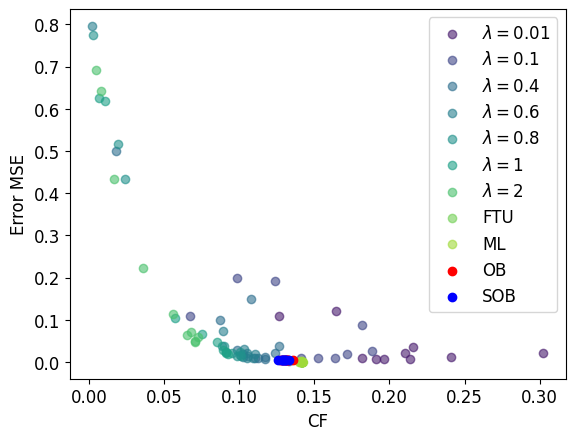

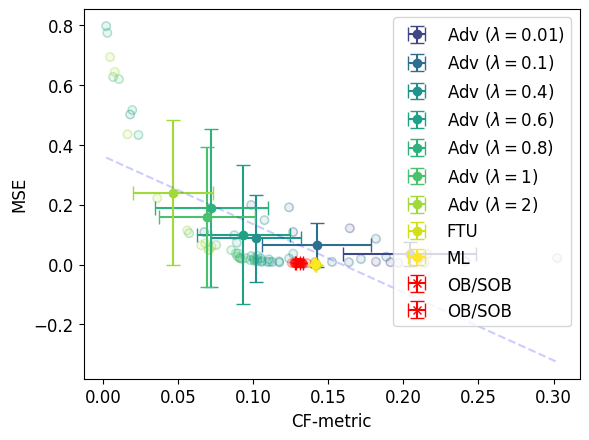

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data provided, updated with new lambda 0.8 data point
# Initialize lists to store the data
lambda_or_ob = []
mse = []
cf = []

x_metric = 'test_mse'
y_metric = 'cf_train'


# Define the font size settings
plt.rcParams.update({'font.size': 12})  # Adjust the base font size

# Add data for ML, FTU, and SOB results
for i in ml_results:
    lambda_or_ob.append('ML')
    mse.append(ml_results[i][x_metric])
    cf.append(ml_results[i][y_metric])

for i in ftu_results:
    lambda_or_ob.append('FTU')
    mse.append(ftu_results[i][x_metric])
    cf.append(ftu_results[i][y_metric])

for i in sob_results:
    lambda_or_ob.append('SOB')
    mse.append(sob_results[i][x_metric])
    cf.append(sob_results[i][y_metric])

# Iterate over the OB results and add them to the lists
for i in ob_results:
    lambda_or_ob.append('OB')  # Mark this data point as 'OB'
    mse.append(ob_results[i][x_metric])
    cf.append(ob_results[i][y_metric])

# Iterate over the adversarial results and add them to the lists
for (i, lambdap) in adv_results:
    lambda_or_ob.append(lambdap)  # Use the lambda value for this data point
    mse.append(adv_results[(i, lambdap)][x_metric])
    cf.append(adv_results[(i, lambdap)][y_metric])

# Now create the dictionary for plotting
data = {
    'lambda': np.array(lambda_or_ob),
    'MSE': np.array(mse),
    'CF': np.array(cf)
}

# Assume data dictionary setup has been done as before
# Unique lambda values and their colors
lambda_unique = np.unique(data['lambda'])
# lambda_unique = ['ML', 'FTU','0.01','0.1','0.2', '1','10', 'OB', 'SOB']
# lambda_unique = ['ML', 'FTU','0','0.01','0.1','0.4','1','10','OB', 'SOB']
# for lambdap in [0, 0.05, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 10]:
    

# [0,0.8,1, 1.2]
# 0, 0.1, 0.2, 0.4, 0.6, 0.8, 1
colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_unique)))


# Scatter plot setup
fig1, ax1 = plt.subplots()
for i, lamb in enumerate(lambda_unique):

    if lamb =="0":
        continue
    if lamb =="0.05":
        continue
    if lamb =="0.2":
        continue
    if lamb =="10":
        continue
    indices = data['lambda'] == lamb
    # Customize label based on type
    if lamb in ['OB', 'SOB', 'ML', 'FTU']:
        label = lamb  # Directly use the model name
    else:
        label = f'$\lambda={lamb}$'  # Use Lambda notation for numerical values

    if lamb in ['OB']:
        ax1.scatter(data['CF'][indices], data['MSE'][indices], color='red', label=label)
    elif lamb in ['SOB']:
        ax1.scatter(data['CF'][indices], data['MSE'][indices], color='blue', label=label)
    else:
        ax1.scatter(data['CF'][indices], data['MSE'][indices], color=colors[i], label=label, alpha = 0.6)

ax1.set_xlabel('CF')
ax1.set_ylabel('Error MSE')
# ax1.set_title('Scatter Plot: Error MSE vs CF')
ax1.legend()

# Error bar plot setup
fig2, ax2 = plt.subplots()
mean_mse_values = []
mean_cf_values = []
for i, lamb in enumerate(lambda_unique):
    # if lamb =="OB":
    #     continue

    # if lamb =="1":
    #     continue
    if lamb =="0":
        continue
    if lamb =="0.05":
        continue
    if lamb =="0.2":
        continue
    if lamb =="10":
        continue
    indices = data['lambda'] == lamb
    mean_MSE = np.mean(data['MSE'][indices])
    std_MSE = np.std(data['MSE'][indices])
    mean_CF = np.mean(data['CF'][indices])
    std_CF = np.std(data['CF'][indices])
    if lamb in ['OB', 'SOB', 'ML', 'FTU']:
        label = lamb  # Directly use the model name
    else:
        label = f'Adv ($\lambda={lamb}$)'  # Use Lambda notation for numerical values


    if lamb in ['OB']:
        ax2.errorbar(mean_CF, mean_MSE, xerr=std_CF, yerr=std_MSE, fmt='x', color='red', capsize=5, label='OB/SOB')
        ax2.scatter(data['CF'][indices], data['MSE'][indices], color='red', alpha=0.1)  # Reduced opacity for overlay
        ax2.scatter(data['CF'][indices], data['MSE'][indices], facecolors='none', color='red', alpha=0.3)  # Reduced opacity for overlay

    elif lamb in ['SOB']:
        ax2.errorbar(mean_CF, mean_MSE, xerr=std_CF, yerr=std_MSE, fmt='x', color='red', capsize=5, label='OB/SOB')
        ax2.scatter(data['CF'][indices], data['MSE'][indices], color='red', alpha=0.1)  # Reduced opacity for overlay
        ax2.scatter(data['CF'][indices], data['MSE'][indices], facecolors='none', color='red', alpha=0.3)  # Reduced opacity for overlay

    else:
        ax2.errorbar(mean_CF, mean_MSE, xerr=std_CF, yerr=std_MSE, fmt='o', color=colors[i + 2], capsize=5, label=label)

        ax2.scatter(data['CF'][indices], data['MSE'][indices], color=colors[i + 2], alpha=0.1)  # Reduced opacity for overlay
        ax2.scatter(data['CF'][indices], data['MSE'][indices], facecolors='none', color=colors[i + 2], alpha=0.3)  # Reduced opacity for overlay


    print(lamb)
    print(mean_MSE)
    print(std_MSE)
    print(mean_CF)
    print(std_CF)

    if lamb in ['OB', 'SOB','ML','FTU']:  # Skip your methods for regression line
        continue
    else:
        # mean_mse_values.append(mean_MSE)
        # mean_cf_values.append(mean_CF)
        mean_mse_values.append(data['MSE'][indices])
        mean_cf_values.append(data['CF'][indices])


ax2.set_xlabel('CF-metric')
ax2.set_ylabel('MSE')
# ax2.set_title('Error Bar Plot: Error MSE vs CF')
ax2.legend()

from scipy.optimize import curve_fit

def linear_func(x, a, b):
    return a * x + b

# Define the exponential function for fitting
def exp_func(x, a, b, c):
    return a * 2.718**(-c*x) + b
# def exp_func(x, a, b):
#     return a *x + b


mean_cf_values = [item for sublist in mean_cf_values for item in sublist]
mean_mse_values = [item for sublist in mean_mse_values for item in sublist]

# Only attempt fitting if there are enough data points and they vary
if len(set(mean_cf_values)) > 1:
    try:
        params, params_covariance = curve_fit(exp_func, mean_cf_values, mean_mse_values, maxfev=100000)
        x_line = np.linspace(min(mean_cf_values), max(mean_cf_values), 100)
        ax2.plot(x_line, exp_func(x_line, *params), '--', label='Fitted Line', color = 'blue', alpha = 0.2)
        # ax2.plot(x_line, exp_func(x_line, 0.5251519, 0.0510268, 2), 'r--', label='Fitted Line')

    except Exception as e:
        print(f"Failed to fit a line: {e}")
else:
    print("Not enough variability in CF-Metric values to fit a line.")



plt.show()

In [ ]:
fig2.savefig('Error_MSE_vs_CF_Plot_all.pdf')

In [ ]:
Unif_X_np = Unif_X.detach().numpy()

In [ ]:
Unif_X_np.shape

(20000, 1)

In [ ]:
len(predY_a_prime_dict['FTU'])

80000

In [ ]:
len(predY_a_prime_dict[1])

200000

ML
--
0.03641397523903288
0.23717380110744665
200000
--
0.04539610905374866
0.2504473940538975
200000
--
0.051601782567217015
0.2462769475022447
200000
--
0.04770227356720716
0.24610870976242524
200000
--
0.0655974861860741
0.22467131127307885
200000
--
0.06387943345296662
0.2417574321426126
200000
--
0.050615089964238
0.2624641872380136
200000
--
0.04771768137230538
0.23909134640860472
200000
--
0.06481910988024901
0.22174423082517605
200000
--
0.07494551980134566
0.24502164280542213
200000
--
0.036284480504808016
0.24488277692962507
200000
--
0.039398045485955664
0.25308322113551085
200000
--
0.06448569923662581
0.25258011595838037
200000
--
0.06322311775805428
0.264380554533818
200000
--
0.04765829794423189
0.24098052954908927
200000
--
0.05642015064076986
0.256738309750211
200000
--
0.10147828416677658
0.266036779623714
200000
--
0.06742108116659802
0.259297411875957
200000
--
0.07853908792254514
0.23494833149373212
200000
--
0.03182034351467155
0.25118104549391773
200000
--
0.0665

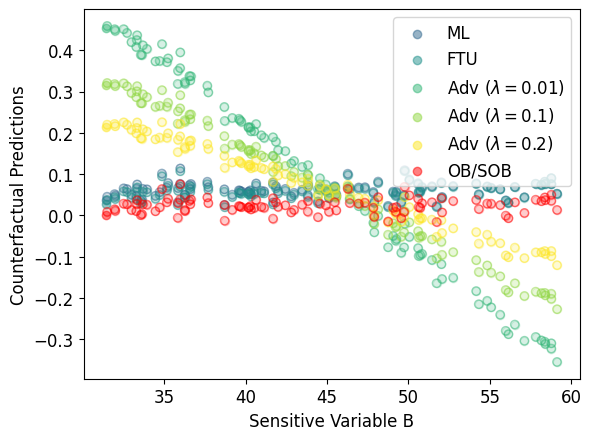

In [ ]:
# Plot setup
# plt.figure(figsize=(10, 6))

# Error bar plot setup
fig, ax = plt.subplots()
# plt.ylim(-0.8, 1.4)
# Define the font size settings
plt.rcParams.update({'font.size': 12})  # Adjust the base font size

# lambda_unique = ['ML', 'FTU', 0, 0.1, 1, 'OB', 'SOB']
lambda_unique = ['ML', 'FTU', 0.01, 0.1, 0.2, 'OB', 'SOB']
colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_unique)))
# Plot error bars
for i in range(len(lambda_unique)):
    if lambda_unique[i] not in list(predY_a_prime_dict.keys()):
        continue

    # if lambda_unique[i] == 1:
    #     continue
    lamb = lambda_unique[i]
    print(lamb)
    if lamb in ['OB']:
        continue
    predY_a_prime = np.array(predY_a_prime_dict[lamb])

    # Customize label based on type
    if lamb in ['OB', 'SOB', 'ML', 'FTU']:
        label = lamb  # Directly use the model name
    else:
        label = f'Adv ($\lambda={lamb}$)'  # Use Lambda notation for numerical values
    
    if label in ('OB', 'SOB'):
        label = 'OB/SOB'

    for x in unique_X:
        mask = Unif_X_np == x

        mask = np.tile(mask, (num_exps, 1))
        # mean_predY[x].append(np.mean(predY_a_prime[mask.reshape(-1)]))
        # std_predY[x].append(np.std(predY_a_prime[mask.reshape(-1)]))

        print('--')
        print(np.mean(predY_a_prime[mask.reshape(-1)]))
        print(np.std(predY_a_prime[mask.reshape(-1)]))

    # for x in unique_X:
        print(len(mask.reshape(-1)))

        mean_value = np.mean(predY_a_prime[mask.reshape(-1)])
        std_value = np.std(predY_a_prime[mask.reshape(-1)])

        if x == np.min(unique_X):
            if label == 'OB/SOB':
                ax.scatter(x, mean_value, color='red', label = label, alpha=0.5)  # Reduced opacity for overlay
            else:
                ax.scatter(x, mean_value, color=colors[i + 2], label = label, alpha=0.5)  # Reduced opacity for overlay
        else:
            # plt.scatter(x, mean_value, facecolors='none', label = label, color=colors[i], alpha=0.3)  # Reduced opacity for overlay

            # plt.errorbar(x, mean_value, yerr=std_value, fmt='o', label = label, color=colors[i], alpha=0.2)
        # else:
            # plt.errorbar(x, mean_value, yerr=std_value, fmt='o', color=colors[i], alpha=0.2)
        # plt.errorbar(x, mean_value, yerr=0, fmt='o', color=colors[i], alpha=0.2)
            if label == 'OB/SOB':
                ax.scatter(x, mean_value, color='red', alpha=0.2)  # Reduced opacity for overlay
                ax.scatter(x, mean_value, facecolors='none', color='red', alpha=0.5)  # Reduced opacity for overlay
            
            else:
                ax.scatter(x, mean_value, color=colors[i + 2], alpha=0.2)  # Reduced opacity for overlay
                ax.scatter(x, mean_value, facecolors='none', color=colors[i + 2], alpha=0.5)  # Reduced opacity for overlay

# plt.title('Prediction vs. Uniform X for Various Models')
ax.set_xlabel('Sensitive Variable B')
ax.set_ylabel('Counterfactual Predictions')
ax.legend()
# ax.grid(True)
# plt.savefig('cf_fair.pdf', format='pdf')
# ax.show()
plt.show()

In [ ]:
# fig2.savefig('fair_plot.pdf')

In [ ]:
fig.savefig('fair_plot.pdf')

In [ ]:
data

{'lambda': array(['ML', 'ML', 'ML', 'ML', 'ML', 'FTU', 'FTU', 'FTU', 'FTU', 'FTU',
        'SOB', 'SOB', 'OB', 'OB', '0', '0.4', '1', '0', '0.4', '1'],
       dtype='<U32'),
 'MSE': array([1.56665614e-04, 6.03296321e-05, 7.66329002e-04, 1.05590494e-04,
        3.22805601e-04, 1.25126360e-04, 7.24502679e-05, 9.25557251e-05,
        1.15612333e-04, 2.15935404e-04, 5.58903115e-03, 5.48120728e-03,
        5.62609173e-03, 5.47930971e-03, 3.90225947e-01, 7.35795964e-03,
        2.07562558e-02, 4.60577570e-03, 9.70876869e-03, 4.18527164e-02]),
 'CF': array([0.13907084, 0.13896741, 0.13905199, 0.13877021, 0.13901517,
        0.1387846 , 0.13932858, 0.13935916, 0.13875222, 0.13862753,
        0.13856976, 0.1345024 , 0.13799134, 0.13652022, 0.02318363,
        0.10804892, 0.09211671, 0.1852435 , 0.11383274, 0.08140298])}

In [ ]:
# flat_list

0.13839158415794373
0.00028396994130162054
0.000593332785752775
0.000328954329752844
0.1386410266160965
9.550012214276648e-06
0.00017962321032343164
8.111253183787926e-06
0.20325224548578263
0.09279469549655914
0.10098696969341836
0.14929920012759523
0.16247108369134367
0.2018289941828698
0.1106840093875391
0.38627347159129216
0.1618918389081955
0.03515885155647993
0.026578199098811796
0.04786410249869214
0.08194950297474861
0.15245699658989906
0.03334647218924137
0.18550307333962027
0.09778902977705002
0.020537701062858106
0.0027558183958791213
0.007833894656770543
0.07296485044062137
0.12987103126943111
0.027992126181720395
0.19808577229794594


IndexError: index 9 is out of bounds for axis 0 with size 9

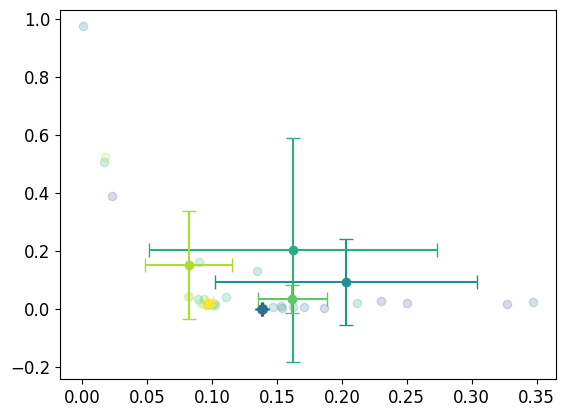

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Define the exponential function for fitting
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

# Data setup
data = {
    'lambda': np.array(lambda_or_ob),
    'MSE': np.array(mse),
    'CF': np.array(cf)
}

lambda_unique = ['ML', 'FTU', '0', '0.05', '0.1', '0.6', '0.8', '1', 'OB']
colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_unique)))

# Initialize plot
fig, ax = plt.subplots()
mean_mse_values = []
mean_cf_values = []

# Plot scatter and collect data for fitting
for i, lamb in enumerate(lambda_unique):
    if lamb == "SOB":
        continue
    indices = data['lambda'] == lamb
    mse_vals = data['MSE'][indices]
    cf_vals = data['CF'][indices]
    color = 'red' if lamb == 'OB/SOB' else colors[i]
    ax.scatter(cf_vals, mse_vals, color=color, label=lamb if lamb != 'SOB' else None, alpha=0.2)  # Reduced opacity for overlay

    mean_MSE = np.mean(data['MSE'][indices])
    std_MSE = np.std(data['MSE'][indices])
    mean_CF = np.mean(data['CF'][indices])
    std_CF = np.std(data['CF'][indices])

    if lamb in ['OB', 'SOB', 'ML', 'FTU']:
        label = lamb  # Directly use the model name
    else:
        label = f'Adv ($\lambda={lamb}$)'  # Use Lambda notation for numerical values

    if lamb in ['OB']:
        ax.errorbar(mean_CF, mean_MSE, xerr=std_CF, yerr=std_MSE, fmt='o', color='red', capsize=5, label=label)
    # elif lamb in ['SOB']:
    #     ax.errorbar(mean_CF, mean_MSE, xerr=std_CF, yerr=std_MSE, fmt='o', color='blue', capsize=5, label=label)
    else:
        print(mean_CF)
        print(mean_MSE)
        print(std_CF)
        print(std_MSE)

        ax.errorbar(mean_CF, mean_MSE, xerr=std_CF, yerr=std_MSE, fmt='o', color=colors[i + 2], capsize=5, label=label)

    if lamb in ['OB', 'SOB']:  # Skip your methods for regression line
        continue
    mean_mse_values.append(mean_MSE)
    mean_cf_values.append(mean_CF)

# Fit exponential curve to the data (excluding 'OB/SOB')
if len(mean_cf_values) > 1:
    try:
        params, params_covariance = curve_fit(exp_func, mean_cf_values, mean_mse_values, p0=(1, 0.1, 1))
        x_line = np.linspace(min(mean_cf_values), max(mean_cf_values), 100)
        ax.plot(x_line, exp_func(x_line, *params), 'r-', label='Exponential Fit')
    except Exception as e:
        print(f"Failed to fit an exponential curve: {e}")

# Set labels and titles
ax.set_xlabel('CF-metric')
ax.set_ylabel('MSE')
ax.legend()
ax.set_title('Error MSE vs CF with Exponential Fit and Dots Overlay')

plt.show()


In [ ]:
data

{'lambda': array(['ML', 'ML', 'ML', 'ML', 'ML', 'FTU', 'FTU', 'FTU', 'FTU', 'FTU',
        'SOB', 'SOB', 'SOB', 'SOB', 'SOB', 'OB', 'OB', 'OB', 'OB', 'OB',
        '0', '0.1', '0.2', '0.4', '0.6', '0.8', '1', '0', '0.1', '0.2',
        '0.4', '0.6', '0.8', '1', '0', '0.1', '0.2', '0.4', '0.6', '0.8',
        '1', '0', '0.1', '0.2', '0.4', '0.6', '0.8', '1', '0', '0.1',
        '0.2', '0.4', '0.6', '0.8', '1'], dtype='<U32'),
 'MSE': array([5.60102778, 6.67755402, 5.56286194, 5.47245604, 5.76154826,
        5.2897477 , 5.30230682, 5.30849983, 5.33784945, 5.27835745,
        6.14991617, 6.14180231, 6.14290953, 6.14765739, 6.14012241,
        6.15362692, 6.13826609, 6.14921856, 6.15649843, 6.15044975,
        5.79142686, 5.7056058 , 5.4395699 , 5.64345972, 5.98655882,
        6.64876135, 6.20749327, 5.48991633, 5.57956564, 5.74983107,
        5.78383883, 8.12774559, 7.42267569, 6.46047772, 5.59760314,
        5.74422491, 6.24907363, 6.15532699, 5.85661953, 5.96495925,
        6.304341  , 

In [ ]:
ob_results

{0: {'train_mse': tensor(0.5707),
  'test_mse': array(0.5785657, dtype=float32),
  'relative_train_mse': array(-6.06468e+14, dtype=float32),
  'relative_test_mse': array(6.153627, dtype=float32),
  'cf': 5.6729786592768505e-06},
 1: {'train_mse': tensor(0.5701),
  'test_mse': array(0.5756809, dtype=float32),
  'relative_train_mse': array(-6.0611894e+14, dtype=float32),
  'relative_test_mse': array(6.138266, dtype=float32),
  'cf': 4.196003828838002e-06},
 2: {'train_mse': tensor(0.5726),
  'test_mse': array(0.5777371, dtype=float32),
  'relative_train_mse': array(-6.074895e+14, dtype=float32),
  'relative_test_mse': array(6.1492186, dtype=float32),
  'cf': 6.3378934100910556e-06},
 3: {'train_mse': tensor(0.5687),
  'test_mse': array(0.5791058, dtype=float32),
  'relative_train_mse': array(-6.054202e+14, dtype=float32),
  'relative_test_mse': array(6.1564984, dtype=float32),
  'cf': 6.763260898878798e-06},
 4: {'train_mse': tensor(0.5679),
  'test_mse': array(0.5779684, dtype=float32),